# Start

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
import os

from Bio import SeqIO
from Bio import SeqUtils
from Bio.SeqUtils import seq3, seq1
from Bio.Seq import Seq
from Bio.Data.CodonTable import unambiguous_dna_by_id
from scipy.spatial.distance import cdist
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu as MW
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import wilcoxon, binomtest
from scipy.stats import tukey_hsd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm.notebook import tqdm
from local_functions.functions import aa_dict_creator

MT_VERT_GENCODE = 2

aa_dict_full = aa_dict_creator(True)
aa_dict = aa_dict_creator(True, full=False)
Ciona_aa_dict = aa_dict_creator(13)

CODONS=['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC',
        'ATG', 'ATT', 'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG', 'CGT',
        'CTA', 'CTC', 'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT', 'GGA', 'GGC', 
        'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT', 'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT', 
        'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT']

CU = pd.read_csv(r'..\\raw\AllGenesCodonUsage.csv', sep='\t').copy()
CU = CU.drop_duplicates()
duplicated_species = CU[CU.duplicated(subset=['Species', 'Gene'])].Species
stop_codon_species = CU.groupby('Species')[aa_dict_full['Xaa']].first()[(CU.groupby('Species')[aa_dict_full['Xaa']].sum().sum(axis=1) > 0)].index
# excluding species without CU for all 13 protein-coding genes
full_cu_species = CU.groupby('Species').first().loc[(CU.groupby('Species').count().Gene == 13)].index
CU_13 = CU[(CU.Species.isin(full_cu_species)) 
           & (~CU.Species.isin(stop_codon_species))
           & (~CU.Species.isin(duplicated_species))]
CU_12 = CU_13.loc[CU_13.Gene != 'ND6'].groupby('Species')[CODONS].sum()
CU_ND6 = CU_13.loc[CU_13.Gene == 'ND6'].set_index('Species')[CODONS]
CU_13 = CU.groupby('Species')[CODONS].sum()
MS = pd.read_csv(r'c:\Work\Lab\Practice\VertebratePolymorphisms.MutSpecData.OnlyFourFoldDegAllGenes.csv', sep=' ').copy()
table = pd.read_csv(r'C:/Work/Lab/pr-29-trna-or-mutagenesis/raw/MutSpec_CU_tRNA.csv', sep='\t').copy().convert_dtypes()
CU_13_fraction = CU_13.div(CU_13.sum(axis=1), axis=0)
CU_12_fraction = CU_12.div(CU_12.sum(axis=1), axis=0)
AAU_12 = pd.DataFrame({aa: CU_12[codons].sum(axis=1) for aa, codons in aa_dict_full.items()})

In [ ]:
# no 13 genes
CU[~CU.Species.isin(full_cu_species)].Species.unique()

array(['Aceros_waldeni', 'Aplidium_conicum', 'Ardeola_bacchus',
       'Asymmetron_inferum', 'Asymmetron_lucayanum', 'Botaurus_stellaris',
       'Botrylloides_leachii', 'Botrylloides_pizoni',
       'Branchiostoma_belcheri', 'Branchiostoma_floridae',
       'Branchiostoma_japonicum', 'Branchiostoma_lanceolatum',
       'Butorides_striata', 'Champsocephalus_gunnari',
       'Chionodraco_myersi', 'Ciona_intestinalis',
       'Datnioides_microlepis', 'Egretta_sacra',
       'Epigonichthys_cultellus', 'Epigonichthys_maldivensis',
       'Gorsachius_magnificus', 'Herdmania_momus', 'Heteronotia_binoei',
       'Hoplobatrachus_rugulosus', 'Ixobrychus_eurhythmus',
       'Ixobrychus_sinensis', 'Myrichthys_maculosus',
       'Nannopterum_brasilianus', 'Notiomystis_cincta',
       'Pelomedusa_subrufa', 'Penelopides_panini', 'Phalacrocorax_carbo',
       'Phoebastria_albatrus', 'Phoebastria_immutabilis',
       'Phoebastria_nigripes', 'Podiceps_cristatus',
       'Prioniturus_luconensis', 'Psitt

# Atypical tRNAs

In [ ]:
with open(r'..\\raw\mitotRNAdb.mfa', 'r') as handle:
    trna_parsed_list = list(SeqIO.parse(handle, "fasta"))

In [3]:
trna_list = []
for trna_record in trna_parsed_list:
    species_row = []
    description = trna_record.id.split('|')
    species = description[1]
    species_row.append(species)
    aa = description[-2]
    species_row.append(aa)
    ac = description[-1]
    species_row.append(ac)
    trna_list.append(species_row)
    
trna_df = pd.DataFrame(data=trna_list, columns=['Species', 'AA', 'AC']).drop_duplicates()
redundant_species = trna_df[trna_df.duplicated(subset=['Species', 'AA'], keep=False)].Species.unique().tolist()
trna_df_redundant = trna_df.loc[trna_df.Species.isin(redundant_species)]
trna_df = trna_df.loc[~trna_df.Species.isin(redundant_species)]
trna_df = trna_df.pivot(index='Species', columns='AA', values='AC')
trna_df = trna_df.dropna(axis=0)
trna_cu_df = trna_df[trna_df.index.isin(CU_13.Species)]

common_acs: pd.Series = trna_df.mode().iloc[0]
cognate_acs = {aa:common_acs[aa] for aa in common_acs.index}
cognate_codons = {aa:str(Seq(ac).reverse_complement()) for aa, ac in cognate_acs.items()}

In [8]:
common_acs

AA
Ala     TGC
Arg     TCG
Asn     GTT
Asp     GTC
Cys     GCA
Gln     TTG
Glu     TTC
Gly     TCC
His     GTG
Ile     GAT
Leu1    TAG
Leu2    TAA
Lys     TTT
Met     CAT
Phe     GAA
Pro     TGG
Ser1    GCT
Ser2    TGA
Thr     TGT
Trp     TCA
Tyr     GTA
Val     TAC
Name: 0, dtype: object

In [7]:
# redundant_species_cu = CU_13.loc[CU_13.Species.isin(redundant_species)].Species.unique().tolist()
# trna_df[(trna_df.duplicated(subset=['Species', 'AA'], keep=False)) & (trna_df.Species.isin(redundant_species_cu))]

# 'Mitsukurina_owstoni', 'Normichthys_operosus' have normal tRNAs
# not sure about 'Pseudalutarius_nasicornis' it will be easier to drop them

Species   AA   AC
12692    Halichoeres_tenuispinis  Gly  CCC
12693    Halichoeres_tenuispinis  Gly  TCC
17604        Mitsukurina_owstoni  Met  CAT
17605        Mitsukurina_owstoni  Met  TAT
19135       Normichthys_operosus  Asp  ATC
19136       Normichthys_operosus  Asp  GTC
23241  Pseudalutarius_nasicornis  Phe  AAA
23242  Pseudalutarius_nasicornis  Phe  GAA

# trna analysis

## Outliers

In [4]:
outliers_df = trna_cu_df.loc[~(trna_cu_df == common_acs).all(axis=1)]
atypical_ac_species_dict = {}
for species, row in outliers_df.iterrows():
    mismatches = []
    for aa, ac in row.items():
        if ac != common_acs[aa]:
            mismatches.append(ac)
            mismatches.append(aa)
    if mismatches:
        atypical_ac_species_dict[species] = mismatches

unverified_outliers = ['Mitsukurina_owstoni', 'Normichthys_operosus', 'Pseudalutarius_nasicornis']
mismatched_ac = ['Cervus_elaphus', 'Cuon_alpinus', 'Phocoena_phocoena', 'Physeter_catodon', 
                 'Platanista_minor', 'Rusa_unicolor_swinhoei', 'Pteropus_scapulatus']
for species in mismatched_ac+unverified_outliers:
    if species in atypical_ac_species_dict:
        del atypical_ac_species_dict[species]

atypical_ac_species_dict

{'Canis_lupus_laniger': ['CAC', 'Val'],
 'Cervus_nippon_yakushimae': ['AAA', 'Phe'],
 'Chaunax_abei': ['CGC', 'Ala'],
 'Chaunax_tosaensis': ['CGC', 'Ala'],
 'Chlamydosaurus_kingii': ['AAC', 'Val'],
 'Cyclemys_atripons': ['CCG', 'Arg'],
 'Odontobutis_platycephala': ['CCG', 'Arg']}

### Excel

In [18]:
xls_list = []
cols = ['Вид', 'тРНК', 'Антикодон', 'Typical anticodon']
for exp in atypical_ac_species_dict:
    xls_list_sp = []
    
    xls_list_sp.append(exp)
    aa = atypical_ac_species_dict[exp][0][:-3]
    xls_list_sp.append(aa)
    xls_list_sp.append(atypical_ac_species_dict[exp][1])
    xls_list_sp.append(common_Ac_dic[aa])
    xls_list.append(xls_list_sp)

    if exp == 'Ciona_intestinalis':
        xls_list_sp = []
        xls_list_sp.append(exp)
        aa = atypical_ac_species_dict[exp][2][:-3]
        xls_list_sp.append(aa)
        xls_list_sp.append(atypical_ac_species_dict[exp][3])
        xls_list_sp.append(common_Ac_dic[aa])
        xls_list.append(xls_list_sp)

xls = pd.DataFrame(data=xls_list, columns=cols)
xls.to_excel('Виды-исключения.xlsx', index=False)

### UMAP

In [16]:
ratio_umap_12 = CU_12_fraction.loc[(CU_12_fraction.index.isin(trna_df.index)) & ~(CU_12_fraction.index.isin(unverified_outliers+mismatched_ac))]
len(ratio_umap_12)

937

In [17]:
embedding_12 = umap.UMAP(random_state=0).fit_transform(ratio_umap_12)
embedding_12 = pd.DataFrame(embedding_12, index=ratio_umap_12.index)

C:\Users\Эльдар\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


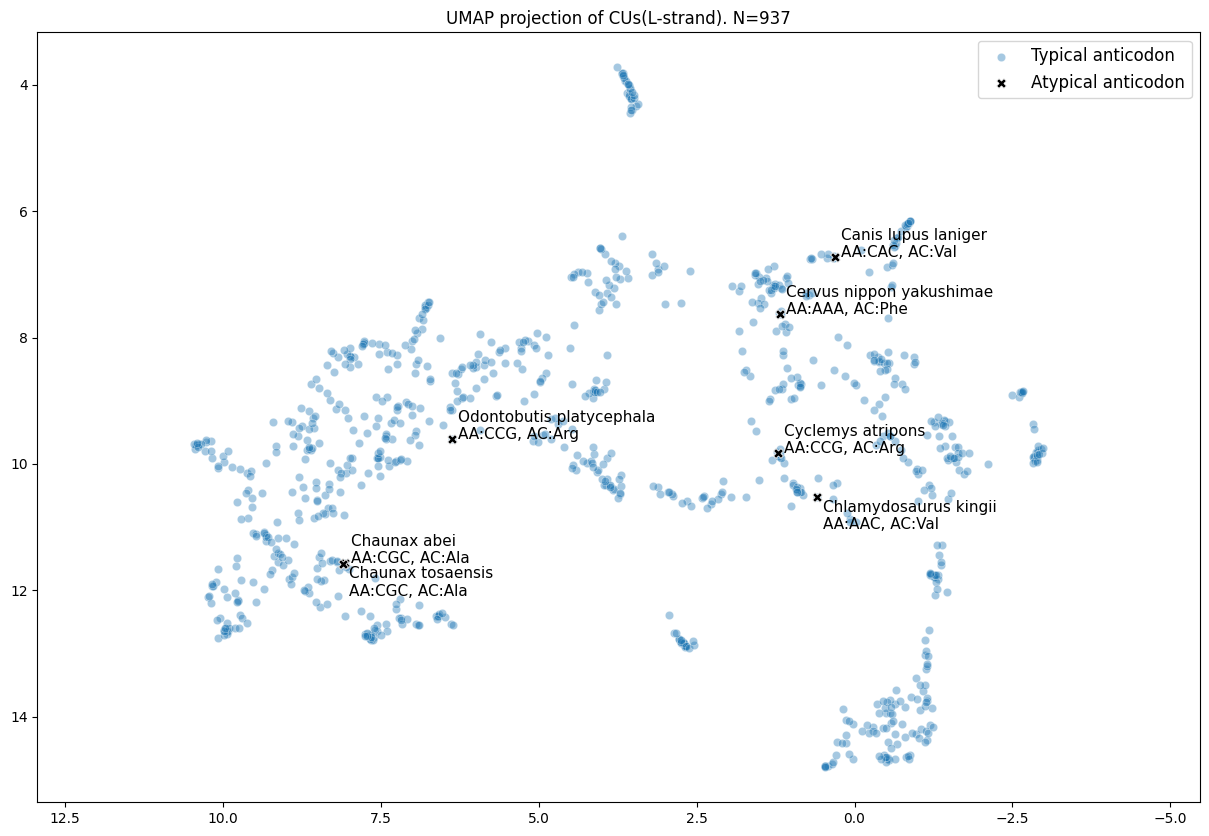

In [36]:
plt.figure(figsize=(15, 10), facecolor='white')
sns.scatterplot(
    x=embedding_12.iloc[:, 0], y=embedding_12.iloc[:, 1], 
    alpha = 0.4, marker='o', label='Typical anticodon')
outliers_indices = ratio_umap_12.loc[ratio_umap_12.index.isin(atypical_ac_species_dict)].index
p1 = sns.scatterplot(
    x=embedding_12.iloc[:, 0][outliers_indices],
    y=embedding_12.iloc[:, 1][outliers_indices],
    marker='X', c='k', s=50,
    label='Atypical anticodon')
for outliers in outliers_indices:
    label = f'{outliers.replace('_', ' ')}\nAA:{atypical_ac_species_dict[outliers][0]}, AC:{atypical_ac_species_dict[outliers][1].replace('T','U')}'
    if ratio_umap_12.loc[outliers].name in ['Chaunax_tosaensis', 'Chlamydosaurus_kingii']:
        p1.text(embedding_12.iloc[:, 0][outliers]-0.1, embedding_12.iloc[:, 1][outliers]+0.5, label, fontsize=11)
    else:
        p1.text(embedding_12.iloc[:, 0][outliers]-0.1, embedding_12.iloc[:, 1][outliers]+0.0, label, fontsize=11)
plt.gca().set_aspect('equal', 'datalim')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.title(f'UMAP projection of CUs(L-strand). N={len(ratio_umap_12)}')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
ratio_umap_13 = CU_13_fraction.loc[(CU_13_fraction.index.isin(trna_df.index)) & ~(CU_13_fraction.index.isin(unverified_outliers+mismatched_ac))]
len(ratio_umap_13)

937

In [14]:
embedding_13 = umap.UMAP(random_state=0).fit_transform(ratio_umap_13)
embedding_13 = pd.DataFrame(embedding_13, index=ratio_umap_13.index)

C:\Users\Эльдар\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


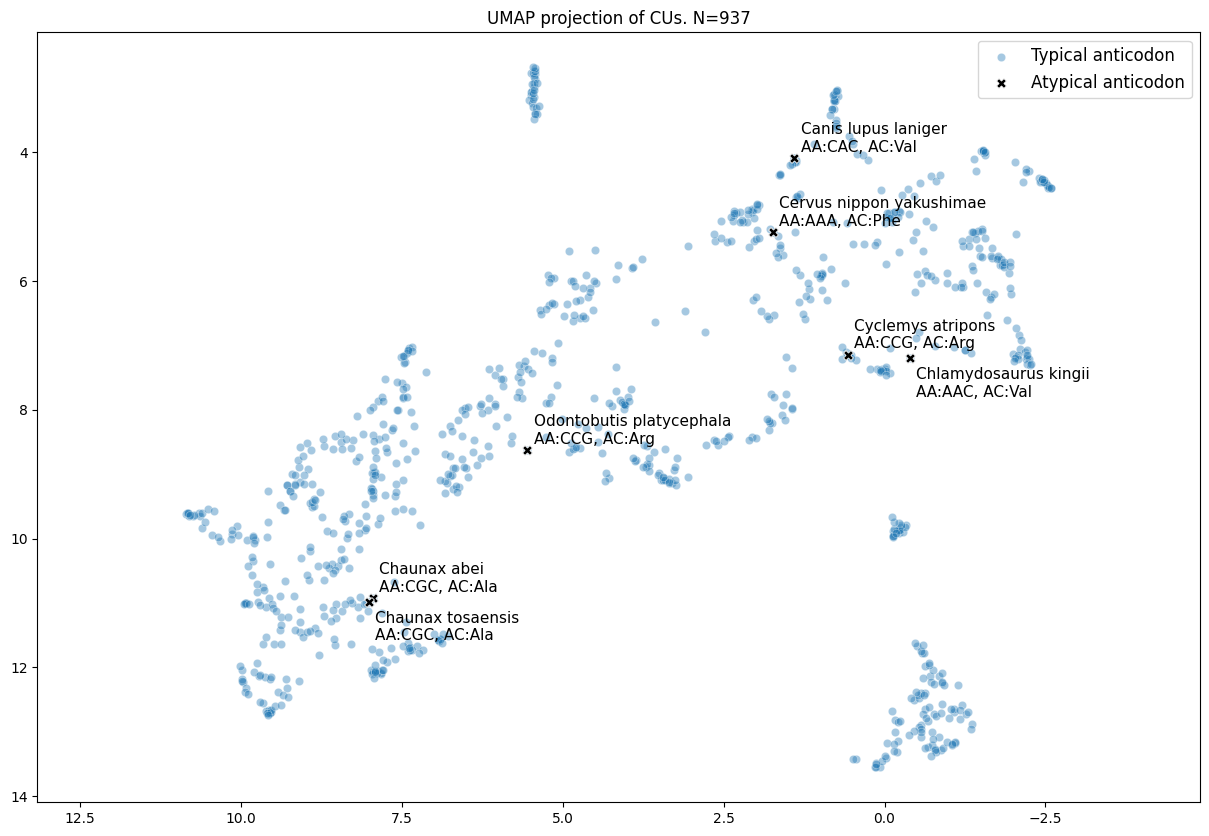

In [ ]:
plt.figure(figsize=(15, 10), facecolor='white')
sns.scatterplot(
    x=embedding_13.iloc[:, 0], y=embedding_13.iloc[:, 1], 
    alpha = 0.4, marker='o', label='Typical anticodon')
outliers_indices = ratio_umap_13.loc[ratio_umap_13.index.isin(atypical_ac_species_dict)].index
p1 = sns.scatterplot(
    x=embedding_13.iloc[:, 0][outliers_indices],
    y=embedding_13.iloc[:, 1][outliers_indices],
    marker='X', c='k', s=50,
    label='Atypical anticodon')
for outliers in outliers_indices:
    label = f'{outliers.replace('_', ' ')}\nAA:{atypical_ac_species_dict[outliers][0]}, AC:{atypical_ac_species_dict[outliers][1].replace('T','U')}'
    if ratio_umap_13.loc[outliers].name in ['Chaunax_tosaensis', 'Chlamydosaurus_kingii']:
        p1.text(embedding_13.iloc[:, 0][outliers]-0.1, embedding_13.iloc[:, 1][outliers]+0.6, label, fontsize=11)
    else:
        p1.text(embedding_13.iloc[:, 0][outliers]-0.1, embedding_13.iloc[:, 1][outliers]-0.1, label, fontsize=11)
plt.gca().set_aspect('equal', 'datalim')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.title(f'UMAP projection of CUs. N={len(ratio_umap_13)}')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.show()

### ratio_df_tax

In [6]:
taxonomy_depth = 20
taxonomy_cols = [f'Taxonomy_{i}' for i in range(1, taxonomy_depth+1)]
taxonomy_df = pd.DataFrame(None, columns=taxonomy_cols)
taxonomy_df[taxonomy_df.columns] = CU_13.groupby('Species').first().Taxonomy.str.split('_', expand=True)
taxonomy_df

Taxonomy_1 Taxonomy_2  \
Species                                                                    
Abalistes_stellaris                                 Eukaryota    Metazoa   
Abbottina_obtusirostris                             Eukaryota    Metazoa   
Abbottina_rivularis                                 Eukaryota    Metazoa   
Ablennes_hians                                      Eukaryota    Metazoa   
Abramis_brama                                       Eukaryota    Metazoa   
...                                                       ...        ...   
Zosterops_lateralis                                 Eukaryota    Metazoa   
Zu_cristatus                                        Eukaryota    Metazoa   
diploid_Megalobrama_amblycephala_x_Xenocypris_d...  Eukaryota    Metazoa   
diploid_Xenocypris_davidi_x_Megalobrama_amblyce...  Eukaryota    Metazoa   
triploid_Megalobrama_amblycephala_x_Xenocypris_...  Eukaryota    Metazoa   

                                                   Taxonomy_3 Taxonomy_4  \
Species                                                                    
Abalistes_stellaris                                  Chordata   Craniata   
Abbottina_obtusirostris                              Chordata   Craniata   
Abbottina_rivularis                                  Chordata   Craniata   
Ablennes_hians                                       Chordata   Craniata   
Abramis_brama                                        Chordata   Craniata   
...                                                       ...        ...   
Zosterops_lateralis                                  Chordata   Craniata   
Zu_cristatus                                         Chordata   Craniata   
diploid_Megalobrama_amblycephala_x_Xenocypris_d...   Chordata   Craniata   
diploid_Xenocypris_davidi_x_Megalobrama_amblyce...   Chordata   Craniata   
triploid_Megalobrama_amblycephala_x_Xenocypris_...   Chordata   Craniata   

                                                    Taxonomy_5    Taxonomy_6  \
Species                                                                        
Abalistes_stellaris                                 Vertebrata  Euteleostomi   
Abbottina_obtusirostris                             Vertebrata  Euteleostomi   
Abbottina_rivularis                                 Vertebrata  Euteleostomi   
Ablennes_hians                                      Vertebrata  Euteleostomi   
Abramis_brama                                       Vertebrata  Euteleostomi   
...                                                        ...           ...   
Zosterops_lateralis                                 Vertebrata  Euteleostomi   
Zu_cristatus                                        Vertebrata  Euteleostomi   
diploid_Megalobrama_amblycephala_x_Xenocypris_d...  Vertebrata  Euteleostomi   
diploid_Xenocypris_davidi_x_Megalobrama_amblyce...  Vertebrata  Euteleostomi   
triploid_Megalobrama_amblycephala_x_Xenocypris_...  Vertebrata  Euteleostomi   

                                                        Taxonomy_7  \
Species                                                              
Abalistes_stellaris                                 Actinopterygii   
Abbottina_obtusirostris                             Actinopterygii   
Abbottina_rivularis                                 Actinopterygii   
Ablennes_hians                                      Actinopterygii   
Abramis_brama                                       Actinopterygii   
...                                                            ...   
Zosterops_lateralis                                  Archelosauria   
Zu_cristatus                                        Actinopterygii   
diploid_Megalobrama_amblycephala_x_Xenocypris_d...  Actinopterygii   
diploid_Xenocypris_davidi_x_Megalobrama_amblyce...  Actinopterygii   
triploid_Megalobrama_amblycephala_x_Xenocypris_...  Actinopterygii   

                                                     Taxonomy_8  Taxonomy_9  \
Species                                   

In [ ]:
for tax_idx in taxonomy_df.iloc[:, 3:8]:
    fig, ax = plt.subplots(figsize=(15, 10), dpi=600)
    sns.scatterplot(x=embedding_12.iloc[:, 0],
                    y=embedding_12.iloc[:, 1],
                    alpha=0.3,
                    hue=taxonomy_df[tax_idx],
                    palette=sns.color_palette('bright6', 
                        n_colors=len(
                            taxonomy_df.loc[:, tax_idx].unique())))
    sns.scatterplot(x=embedding_12.iloc[:, 0][atypical_ac_species_dict.keys()],
                    y=embedding_12.iloc[:, 1][atypical_ac_species_dict.keys()],
                    marker='X', color='black', label='Outliers')
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.gca().set_aspect('equal', 'datalim')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(f'UMAP projection of CUs by classes {tax_idx}', fontsize=14)
    plt.show()

### Outlayers' fam

In [38]:
outlier_family_dict = {}
for outlier in atypical_ac_species_dict:
    domein = -1
    outlier_family = taxonomy_df.loc[outlier].loc[taxonomy_df.loc[outlier].notna()].iloc[domein]
    outlier_family_species = taxonomy_df.loc[(taxonomy_df==outlier_family).any(axis=1)].index.to_list()
    while len(outlier_family_species) <= 3:  # 'Chlamydosaurus_kingii':
        domein -= 1
        outlier_family = taxonomy_df.loc[outlier].loc[taxonomy_df.loc[outlier].notna()].iloc[domein]
        outlier_family_species = taxonomy_df.loc[(taxonomy_df == outlier_family).any(axis=1)].index.to_list()
        # print(outlier, len(outlier_family_species))
    outlier_family_dict[outlier] = outlier_family_species
outlier_family_dict

{'Canis_lupus_laniger': ['Canis_anthus',
  'Canis_latrans',
  'Canis_lupus',
  'Canis_lupus_familiaris',
  'Canis_lupus_laniger',
  'Canis_lupus_lupus'],
 'Cervus_nippon_yakushimae': ['Cervus_canadensis_songaricus',
  'Cervus_elaphus',
  'Cervus_elaphus_xanthopygus',
  'Cervus_elaphus_yarkandensis',
  'Cervus_nippon_centralis',
  'Cervus_nippon_hortulorum',
  'Cervus_nippon_kopschi',
  'Cervus_nippon_sichuanicus',
  'Cervus_nippon_taiouanus',
  'Cervus_nippon_yakushimae',
  'Cervus_nippon_yesoensis'],
 'Chaunax_abei': ['Bufoceratias_thele',
  'Caulophryne_pelagica',
  'Ceratias_uranoscopus',
  'Chaunax_abei',
  'Chaunax_pictus',
  'Chaunax_tosaensis',
  'Coelophrys_brevicaudata',
  'Cryptopsaras_couesii',
  'Diceratias_pileatus',
  'Gigantactis_vanhoeffeni',
  'Haplophryne_mollis',
  'Himantolophus_albinares',
  'Himantolophus_groenlandicus',
  'Lophiodes_caulinaris',
  'Lophius_americanus',
  'Lophius_litulon',
  'Melanocetus_johnsonii',
  'Melanocetus_murrayi',
  'Neoceratias_spinife

In [63]:
atypical_ac_species_dict

{'Canis_lupus_laniger': ['CAC', 'Val'],
 'Cervus_nippon_yakushimae': ['AAA', 'Phe'],
 'Chaunax_abei': ['CGC', 'Ala'],
 'Chaunax_tosaensis': ['CGC', 'Ala'],
 'Chlamydosaurus_kingii': ['AAC', 'Val'],
 'Cyclemys_atripons': ['CCG', 'Arg'],
 'Odontobutis_platycephala': ['CCG', 'Arg']}

In [64]:
outliers_aau_list = []
for outlier in atypical_ac_species_dict:
    aa_outlier = atypical_ac_species_dict[outlier][1]
    codon_outlier = atypical_ac_species_dict[outlier][0]
    family_aau = AAU_12.loc[outlier_family_dict[outlier]]
    cu_outlier = CU_12.loc[outlier, codon_outlier]
    cu_outlier = f'{codon_outlier} {str(cu_outlier)}'
    cu_relatives_mean = CU_12.loc[outlier_family_dict[outlier], cognate_acs[aa_outlier]].mean()
    cu_relatives_mean = f'{cognate_acs[aa_outlier]} {cu_relatives_mean.round(1)}'
    aau_outlier = family_aau.loc[:, aa_outlier][outlier]
    aau_relatives = family_aau.loc[family_aau.index != outlier, aa_outlier]
    aau_sums = family_aau.sum(axis=1)
    aau_fraction_outlier = aau_outlier / aau_sums[outlier]
    aau_fraction_relatives_mean = (aau_relatives / aau_sums[aau_sums.index != outlier]).mean()
    aau_outlier = f'{aa_outlier} {aau_outlier}'
    relatives_number = len(outlier_family_dict[outlier]) - 1
    outliers_aau_list.append([cu_outlier, cu_relatives_mean, aau_outlier, aau_relatives.mean().round(1), 
                              aau_fraction_outlier.round(4), aau_fraction_relatives_mean.round(4), relatives_number])
outliers_aau_df = pd.DataFrame(data=outliers_aau_list, index=atypical_ac_species_dict.keys(),
                               columns=['Observed cognate codon N', 'Relatives mean cognate codon N', 'Observed AA N', 
                                        'Relatives AA N mean', 'Observed AA frequency', 'Relatives mean AA frequency', 'Relatives N'])
outliers_aau_df

Observed cognate codon N  \
Canis_lupus_laniger                        CAC 59   
Cervus_nippon_yakushimae                   AAA 89   
Chaunax_abei                               CGC 16   
Chaunax_tosaensis                          CGC 16   
Chlamydosaurus_kingii                      AAC 96   
Cyclemys_atripons                           CCG 2   
Odontobutis_platycephala                    CCG 5   

                         Relatives mean cognate codon N Observed AA N  \
Canis_lupus_laniger                            TAC 70.7       Val 163   
Cervus_nippon_yakushimae                       GAA 76.2       Phe 238   
Chaunax_abei                                   TGC 17.2       Ala 317   
Chaunax_tosaensis                              TGC 17.2       Ala 323   
Chlamydosaurus_kingii                          TAC 65.3       Val 107   
Cyclemys_atripons                               TCG 6.6        Arg 66   
Odontobutis_platycephala                        TCG 4.6        Arg 69   

                          Relatives AA N mean  Observed AA frequency  \
Canis_lupus_laniger                     163.8                 0.0451   
Cervus_nippon_yakushimae                239.4                 0.0658   
Chaunax_abei                            323.0                 0.0874   
Chaunax_tosaensis                       322.8                 0.0890   
Chlamydosaurus_kingii                   114.3                 0.0298   
Cyclemys_atripons                        67.0                 0.0183   
Odontobutis_platycephala                 70.2                 0.0190   

                          Relatives mean AA frequency  Relatives N  
Canis_lupus_laniger                            0.0453            5  
Cervus_nippon_yakushimae                       0.0662           10  
Chaunax_abei                                   0.0891           23  
Chaunax_tosaensis                              0.0890           23  
Chlamydosaurus_kingii                          0.0319           18  
Cyclemys_atripons                              0.0186            4  
Odontobutis_platycephala                       0.0194            4

0.0451
0.0453


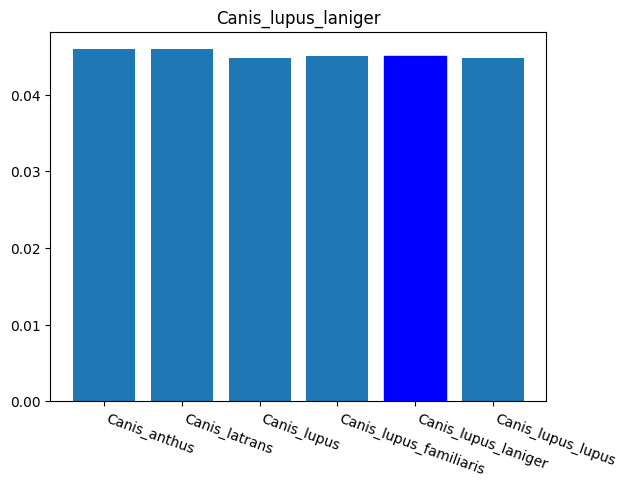

0.0658
0.0662


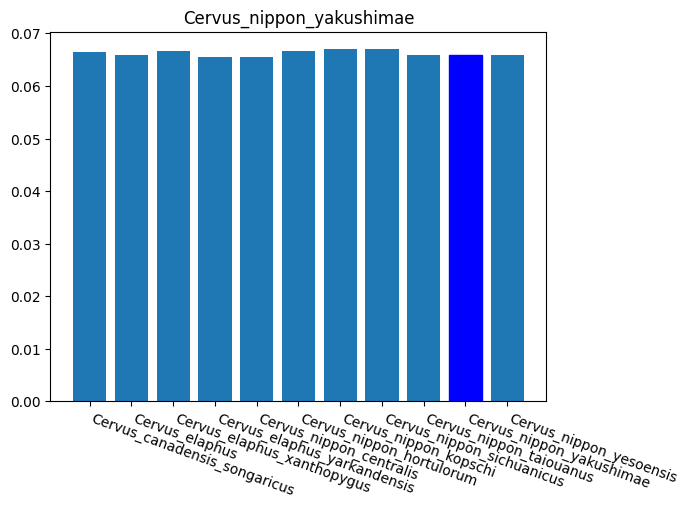

0.0874
0.0891


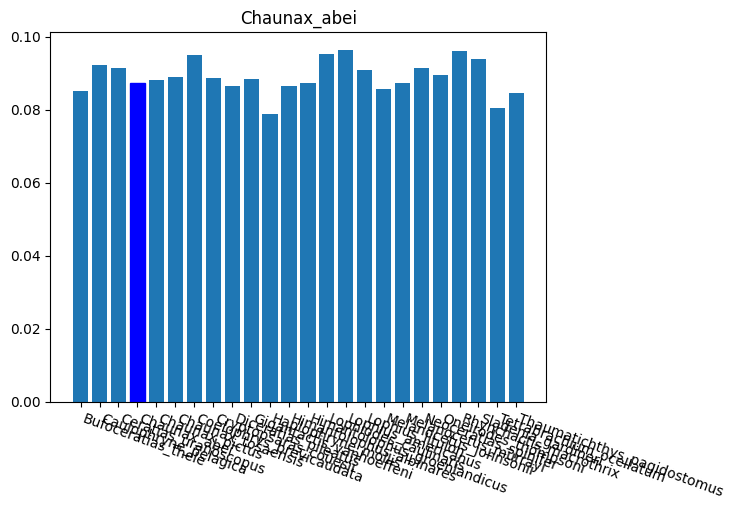

0.089
0.089


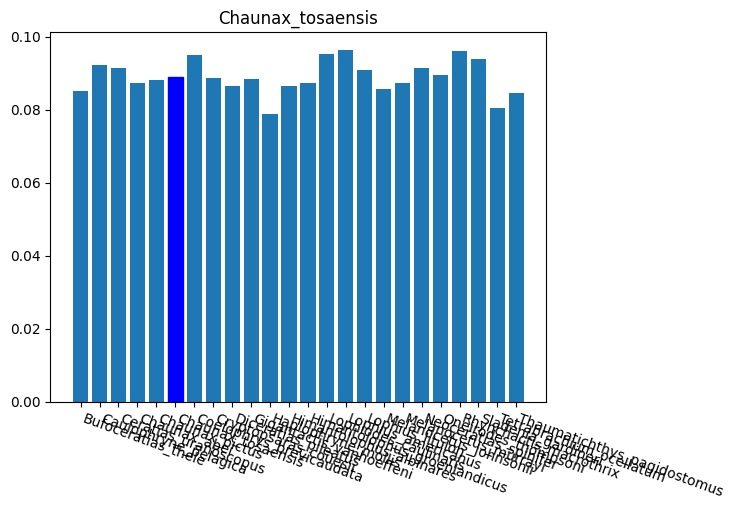

0.0298
0.0319


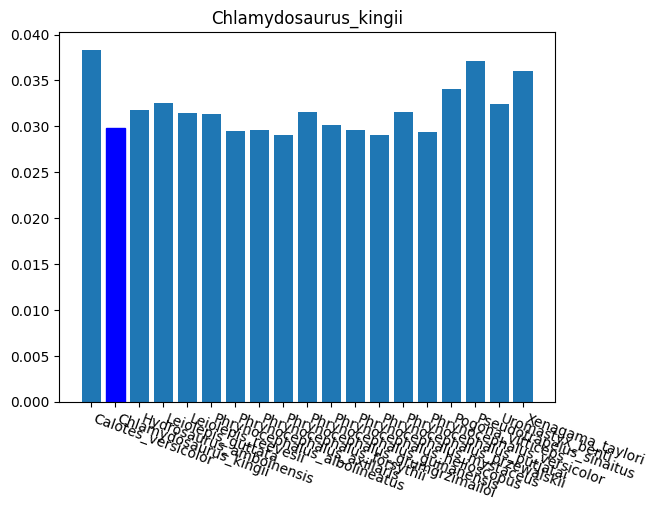

0.0183
0.0186


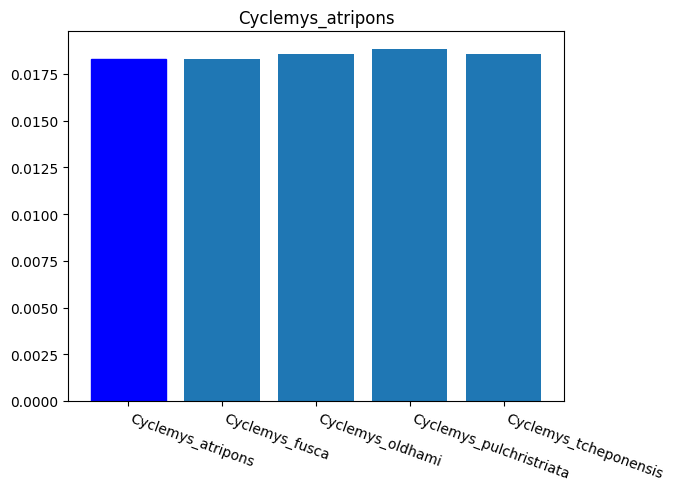

0.019
0.0194


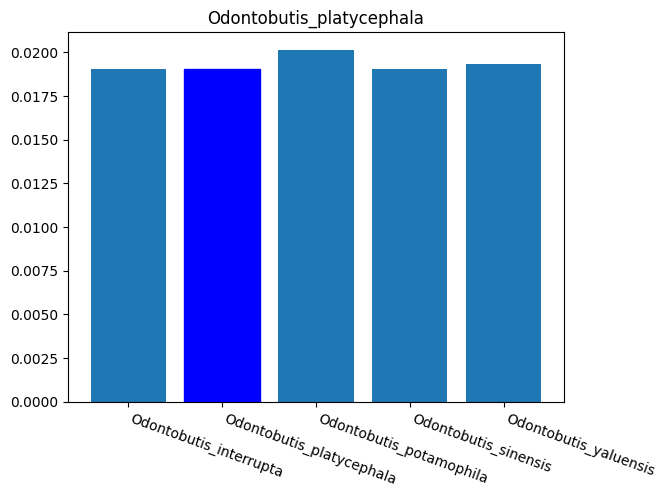

In [65]:
for outlier in atypical_ac_species_dict:
    aa = atypical_ac_species_dict[outlier][1]
    AAU_fraction = AAU_12.loc[outlier_family_dict[outlier], aa] / AAU_12.loc[outlier_family_dict[outlier]].sum(axis=1)
    print(AAU_fraction.loc[outlier].round(4))
    print(AAU_fraction.loc[AAU_fraction.index != outlier].mean().round(4))
    barlist = plt.bar(outlier_family_dict[outlier], AAU_fraction)
    barlist[outlier_family_dict[outlier].index(outlier)].set_color('b')
    plt.xticks(rotation=-20, ha='left')
    plt.title(outlier)
    plt.show()

In [254]:
redundant_aa_dict = {'Halichoeres_tenuispinis': 'Gly', 'Mitsukurina_owstoni': 'Met', #  'Ciona_intestinalis': 'Gly', 
                     'Normichthys_operosus': 'Asp', 'Pseudalutarius_nasicornis': 'Phe'}

[0.06174200661521499, 0.05895316804407714, 0.060723157604195416, 0.05846662989520132, 0.061449435106089835, 0.06179310344827586, 0.0653793103448276, 0.06232763375620518, 0.06094870380584666, 0.06205184776613348, 0.06120760959470637, 0.0623104494072236, 0.06041379310344828, 0.061241379310344825, 0.060689655172413794, 0.06041379310344828]


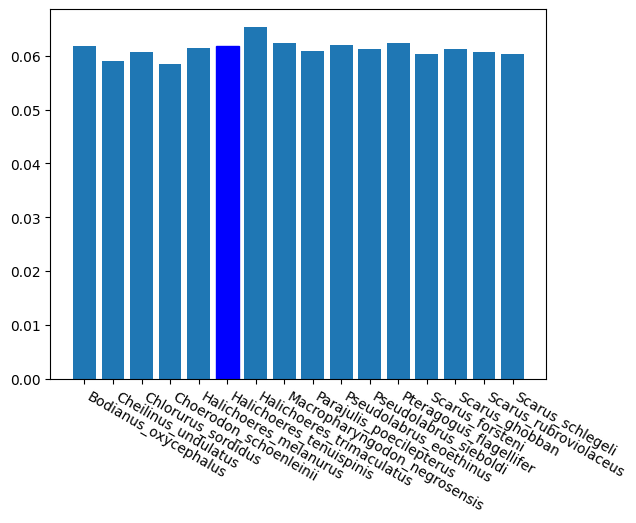

[0.045805739514348784, 0.04718543046357616, 0.04497792494481236, 0.04663355408388521, 0.04525386313465784, 0.04415011037527594, 0.04415011037527594, 0.045805739514348784, 0.04880066170388751, 0.04911699779249448, 0.04769782189137028]


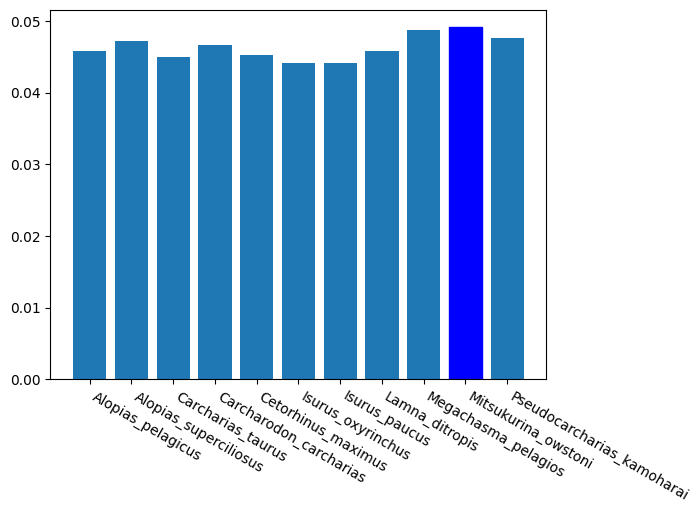

[0.019597019044990338, 0.01932633903920486, 0.02013237727523442, 0.019575406672180867]


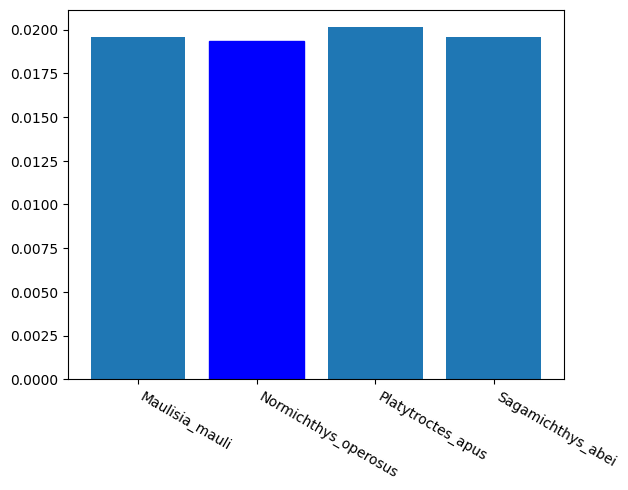

[0.060005505092210296, 0.05956977385548814, 0.05874241588527303, 0.05929398786541644, 0.05956977385548814, 0.06205184776613348, 0.060397131825703256, 0.05929398786541644, 0.059845559845559844, 0.05973025048169557, 0.05956977385548814, 0.05973025048169557, 0.058774834437086095, 0.06067291781577496, 0.059845559845559844, 0.06015452538631347, 0.0576710816777042, 0.059845559845559844, 0.058823529411764705, 0.059179741260666115, 0.06177606177606178, 0.06012134583563155, 0.06012134583563155, 0.060397131825703256]


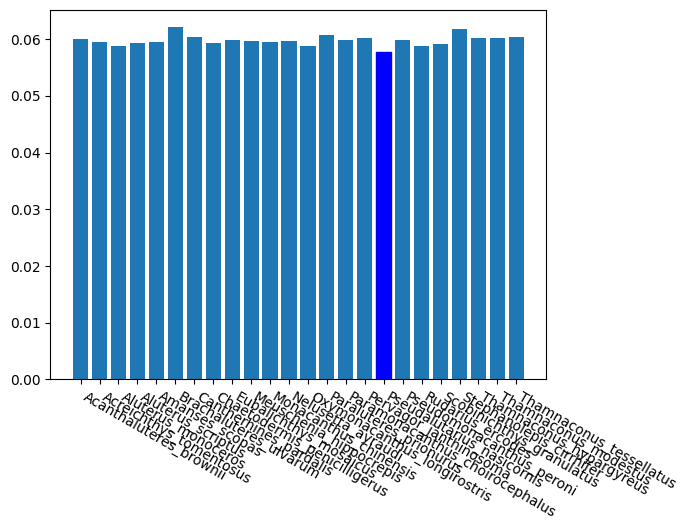

In [330]:
outlier_family_red_dict = {}
for outlier in redundant_species:
    domein = -2
    if outlier in ['Ciona_intestinalis', 'Mitsukurina_owstoni']:
        domein = -3
    if outlier in taxonomy_df.index:
        outlier_family = taxonomy_df.loc[outlier].loc[taxonomy_df.loc[outlier].notna()].iloc[domein]
        outlier_family_red_dict[outlier] = taxonomy_df.loc[(taxonomy_df==outlier_family).any(axis=1)].index.to_list()
        aa = redundant_aa_dict[outlier]
        AAU_fraction = AAU_12.loc[outlier_family_red_dict[outlier], aa] / AAU_12.loc[outlier_family_red_dict[outlier]].sum(axis=1)
        print(AAU_fraction.tolist())
        barlist = plt.bar(outlier_family_red_dict[outlier], AAU_fraction)
        barlist[outlier_family_red_dict[outlier].index(outlier)].set_color('b')
        plt.xticks(rotation=-30, ha='left')
        plt.show()

## Cognate check

In [369]:
table_t= table[['Species']+[f'{codon}_12' for codon in CODONS]+[f'{Ac}_Ac' for Ac in aa_s if Ac != 'Xaa']]
no_lys_ac = table_t.loc[table_t.isna().any(axis=1)].Species.tolist()
# table[table.Species.isin(no_lys_ac)]
table_t.loc[table_t.isna().any(axis=1)]
table_t.loc[table_t.Species=='Caenolestes_fuliginosus', 'Lys_Ac'].values[0] is pd.NA

True

In [ ]:
# NOT COGNATE but cheking if most common codon is complementary to anticodon
aa_s = sorted(list(aa_dict.keys()))
codons_12 = [f'{codon}_12' for codon in CODONS]
cognates = []
table_t= table[['Species']+[f'{codon}_12' for codon in CODONS]+[f'{Ac}_Ac' for Ac in aa_s if Ac != 'Xaa']]
table_t = table_t.dropna()
for species in tqdm(table_t.Species):
    breaker = False
    cognates_sp = [species]
    for aa in aa_s[:-1]:
        ac = table_t.loc[table_t.Species==species, f'{aa}_Ac'].values[0]
        ac = str(Seq(ac).reverse_complement())  # Нужно перевернуть Ac, чтобы соответсвовал CU
        if species not in exp_family_dic['Ciona_intestinalis']:
            aa_fam_table = table_t.loc[table_t.Species==species, [c+'_12' for c in aa_dict[aa]]]
        else:
            aa_fam_table = table_t.loc[table_t.Species==species, [c+'_12' for c in Ciona_aa_dict[aa]]]
        codon_max = aa_fam_table.values.max()
        if f'{ac}_12' not in aa_fam_table.columns:
            # breaker = True
            # break
            cognates_sp.append(0)
            continue
        codon_cogn = aa_fam_table.loc[:,f'{ac}_12'].values[0]
        if codon_max <= codon_cogn:
            cognates_sp.append(1)
        else: 
            cognates_sp.append(0)
    if breaker == True:
        continue
    cognates.append(cognates_sp)
cognate_df = pd.DataFrame(data=cognates, columns=['Species']+[f'{aa}_cognate' for aa in aa_s[:-1]]) 

In [297]:
# DONT NEEDED TO MATRIX DERIVING
aa_s = sorted(list(aa_dict.keys()))
codons_12 = [f'{codon}_12' for codon in CODONS]
cognates = []
cognate_cols = []
table_t= table[['Species']+[f'{codon}_12' for codon in CODONS]+[f'{Ac}_Ac' for Ac in aa_s if Ac != 'Xaa']]
# table_t = table_t.dropna()
for species in tqdm(table_t.Species):
    breaker = False
    cognates_sp = [species]
    for aa in aa_s[:-1]:
        ac = table_t.loc[table_t.Species==species, f'{aa}_Ac'].values[0]
        if ac is pd.NA:     # Учитывает сумчатых, у которых нет тРНК лизина
            for codon in aa_dict[aa]:
                cognates_sp.append(0)
            continue
        ac = str(Seq(ac).reverse_complement())  # Нужно перевернуть Ac, чтобы соответсвовал CU
        # if species not in exp_family_dic['Ciona_intestinalis']:
        #     aa_fam_table = table_t.loc[table_t.Species==species, [c+'_12' for c in aa_dict[aa]]]
        # else:
        #     aa_fam_table = table_t.loc[table_t.Species==species, [c+'_12' for c in Ciona_aa_dict[aa]]]

        for codon in aa_dict[aa]:
            if codon not in cognate_cols:
                cognate_cols.append(codon)
            if codon == ac:
                cognates_sp.append(1)
            else: 
                cognates_sp.append(0)
        if breaker == True:
            break
    if breaker == True:
        continue

    cognates.append(cognates_sp)
cognate_df = pd.DataFrame(data=cognates, columns=['Species']+cognate_cols) 

  0%|          | 0/1025 [00:00<?, ?it/s]

In [300]:
cognate_df

Species  GCT  GCC  GCA  GCG  CGT  CGC  CGA  CGG  AAT   
0        Abalistes_stellaris    0    0    1    0    0    0    1    0    0  \
1             Ablennes_hians    0    0    1    0    0    0    1    0    0   
2           Abronia_graminea    0    0    1    0    0    0    1    0    0   
3       Abudefduf_vaigiensis    0    0    1    0    0    0    1    0    0   
4     Acanthaluteres_brownii    0    0    1    0    0    0    1    0    0   
...                      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1020       Zaglossus_bruijni    0    0    1    0    0    0    1    0    0   
1021  Zalophus_californianus    0    0    1    0    0    0    1    0    0   
1022        Zanclus_cornutus    0    0    1    0    0    0    1    0    0   
1023    Zebrasoma_flavescens    0    0    1    0    0    0    1    0    0   
1024              Zeus_faber    0    0    1    0    0    0    1    0    0   

      ...  ACA  ACG  TGA  TGG  TAT  TAC  GTT  GTC  GTA  GTG  
0     ...    1    0    1    0    0    1    0    0    1    0  
1     ...    1    0    1    0    0    1    0    0    1    0  
2     ...    1    0    1    0    0    1    0    0    1    0  
3     ...    1    0    1    0    0    1    0    0    1    0  
4     ...    1    0    1    0    0    1    0    0    1    0  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
1020  ...    1    0    1    0    0    1    0    0    1    0  
1021  ...    1    0    1    0    0    1    0    0    1    0  
1022  ...    1    0    1    0    0    1    0    0    1    0  
1023  ...    1    0    1    0    0    1    0    0    1    0  
1024  ...    1    0    1    0    0    1    0    0    1    0  

[1025 rows x 61 columns]

In [4]:
# cognate_df.to_csv('Cognate.csv', index=False)
cognate_df = pd.read_csv('Cognate.csv').copy()
cognate_df

Species  GCT  GCC  GCA  GCG  CGT  CGC  CGA  CGG  AAT   
0        Abalistes_stellaris    0    0    1    0    0    0    1    0    0  \
1             Ablennes_hians    0    0    1    0    0    0    1    0    0   
2           Abronia_graminea    0    0    1    0    0    0    1    0    0   
3       Abudefduf_vaigiensis    0    0    1    0    0    0    1    0    0   
4     Acanthaluteres_brownii    0    0    1    0    0    0    1    0    0   
...                      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1020       Zaglossus_bruijni    0    0    1    0    0    0    1    0    0   
1021  Zalophus_californianus    0    0    1    0    0    0    1    0    0   
1022        Zanclus_cornutus    0    0    1    0    0    0    1    0    0   
1023    Zebrasoma_flavescens    0    0    1    0    0    0    1    0    0   
1024              Zeus_faber    0    0    1    0    0    0    1    0    0   

      ...  ACA  ACG  TGA  TGG  TAT  TAC  GTT  GTC  GTA  GTG  
0     ...    1    0    1    0    0    1    0    0    1    0  
1     ...    1    0    1    0    0    1    0    0    1    0  
2     ...    1    0    1    0    0    1    0    0    1    0  
3     ...    1    0    1    0    0    1    0    0    1    0  
4     ...    1    0    1    0    0    1    0    0    1    0  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
1020  ...    1    0    1    0    0    1    0    0    1    0  
1021  ...    1    0    1    0    0    1    0    0    1    0  
1022  ...    1    0    1    0    0    1    0    0    1    0  
1023  ...    1    0    1    0    0    1    0    0    1    0  
1024  ...    1    0    1    0    0    1    0    0    1    0  

[1025 rows x 61 columns]

## Amino acid usage

NameError: name 'CU_class' is not defined

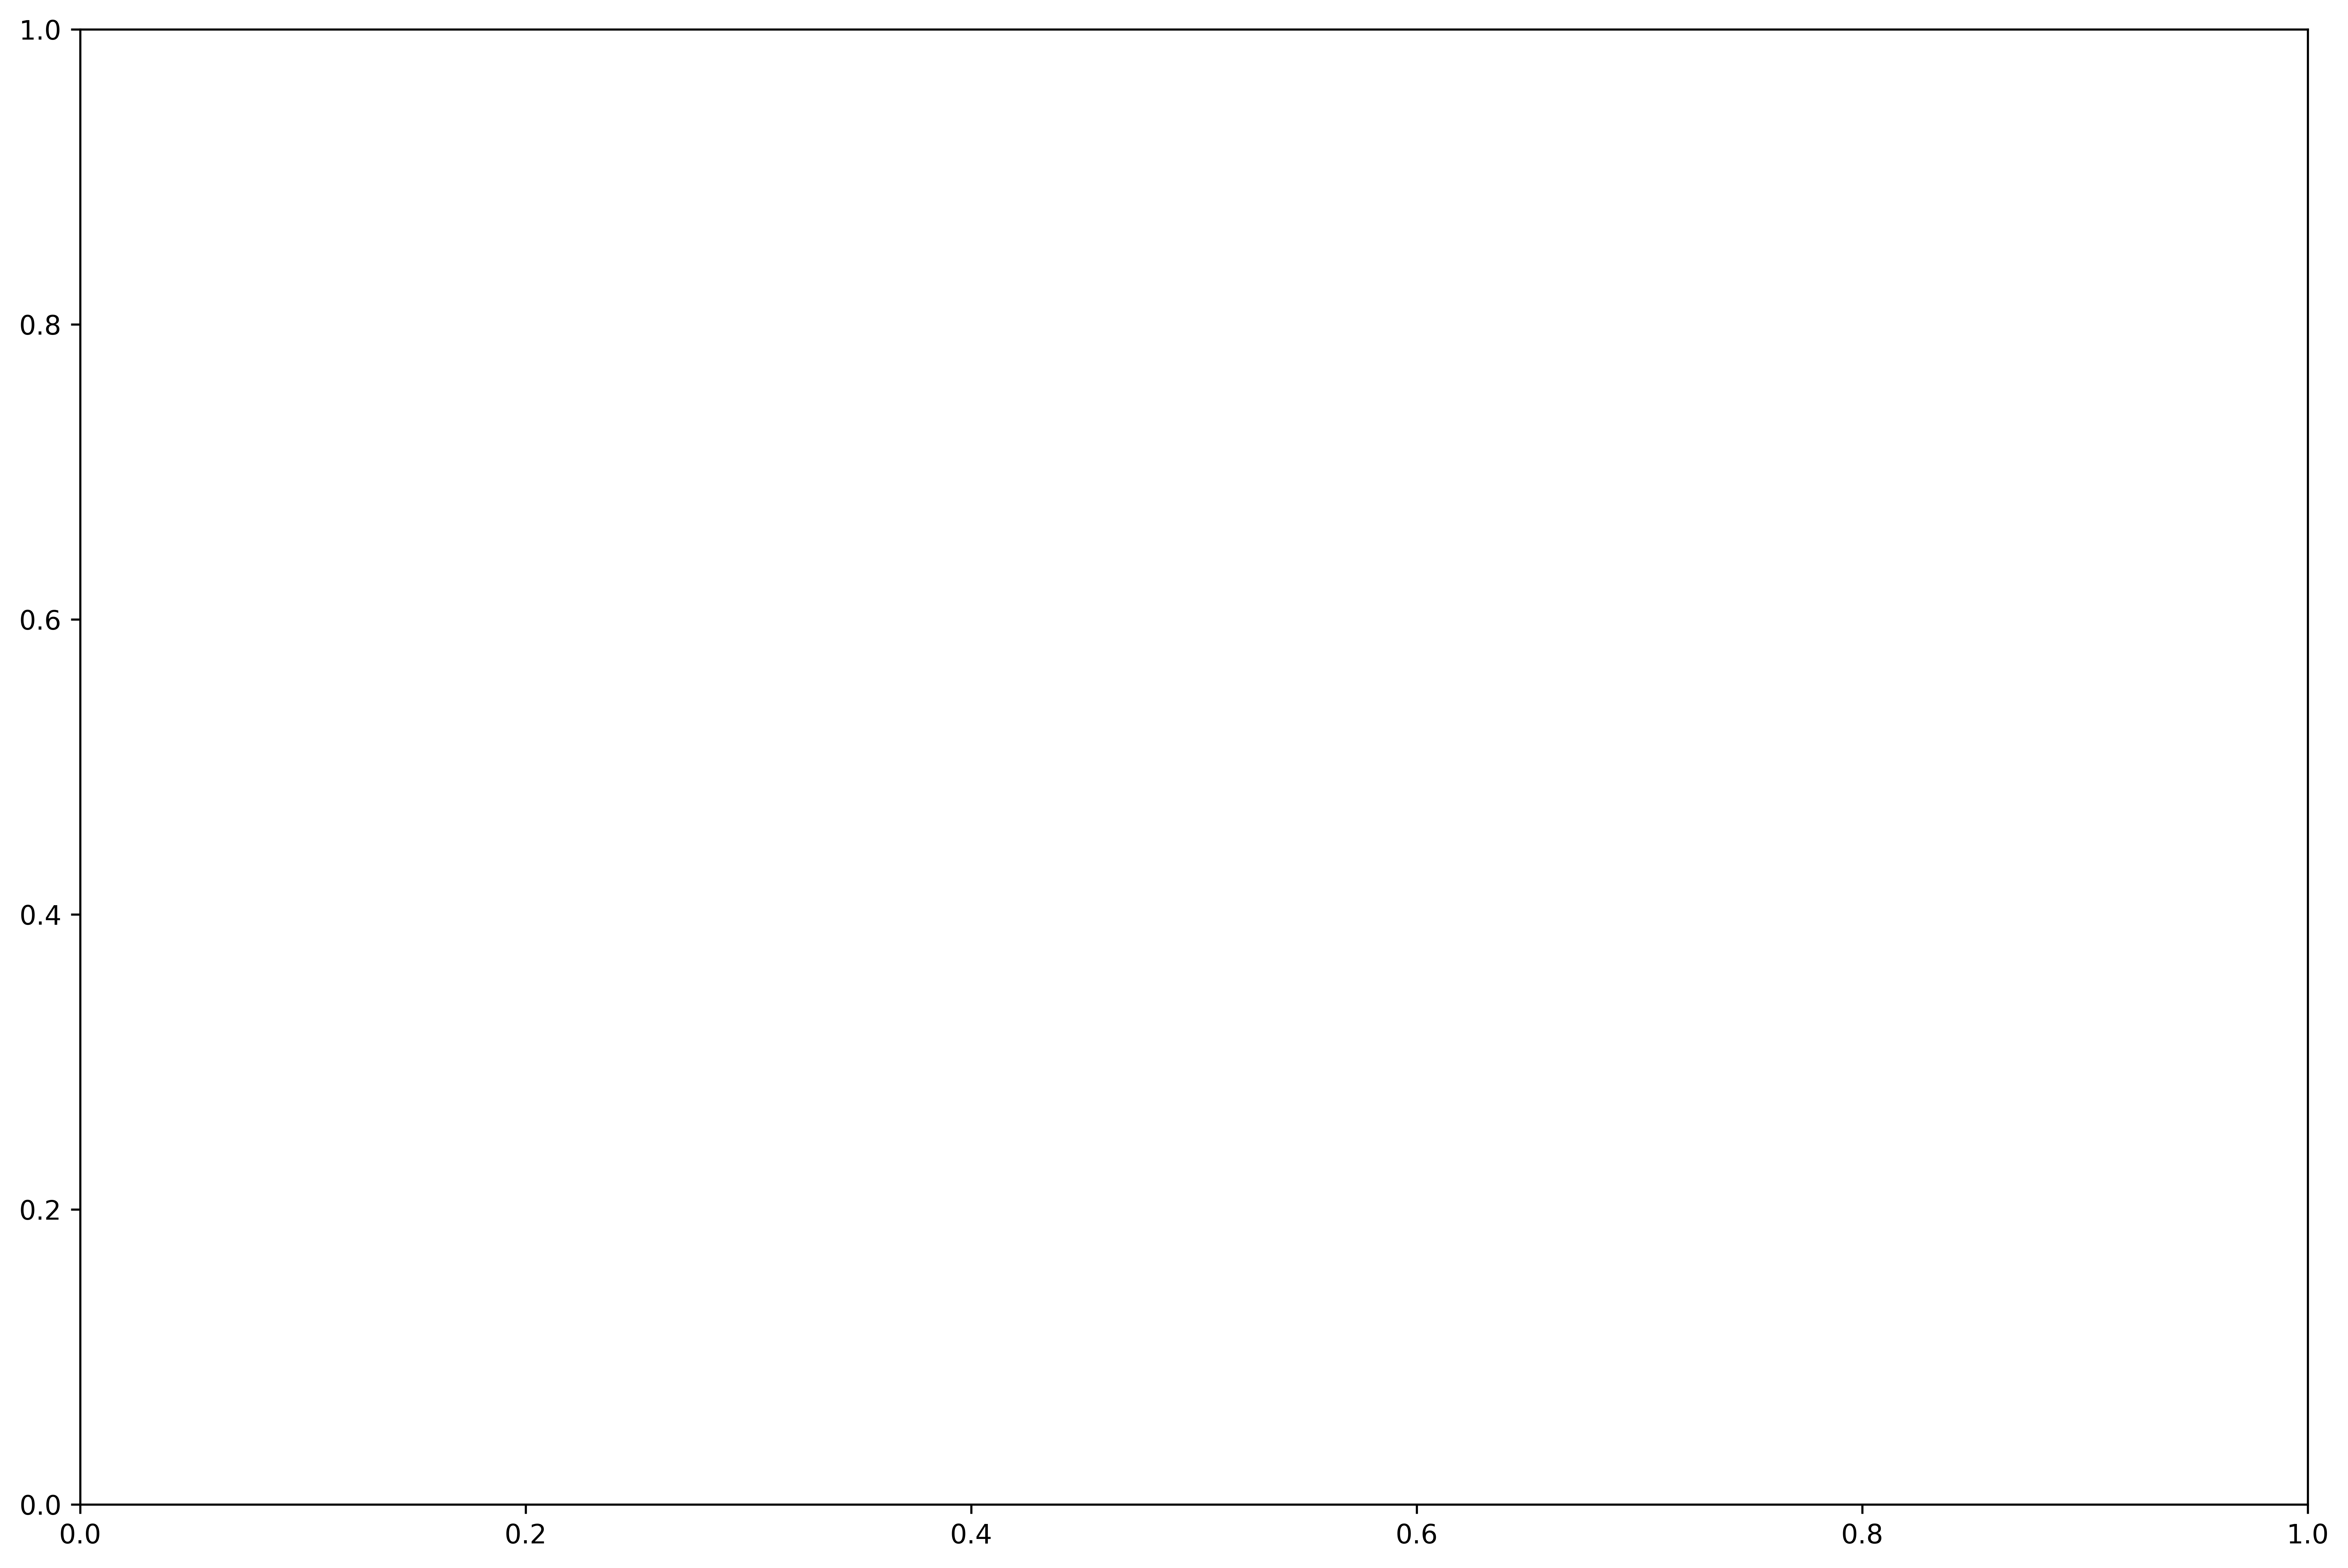

In [ ]:
for n in [5, 15, 30, 100]:
    embedding_12 = umap.UMAP(n_neighbors=n).fit_transform(ratio_umap_12.drop('Species', axis=1))
    fig, ax = plt.subplots(figsize=(15, 10), dpi=600)
    sns.scatterplot(x=embedding_12[:, 0],
        y=embedding_12[:, 1],
        alpha=0.3,
        hue=CU_class['Class'])   
    sns.scatterplot(x=embedding_12[:, 0][CU_12_fraction.loc[CU_12_fraction.Species.isin(atypical_ac_species_dict)].index.values],
        y=embedding_12[:, 1][CU_12_fraction.loc[CU_12_fraction.Species.isin(atypical_ac_species_dict)].index.values],
        marker='X', color='black', label='Exception')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'UMAP projection of CUs with n_neighbors={n} by classes', fontsize=14)
    plt.show()

## Correlations

In [107]:
cu_cols = tablee.loc[:,'AAA_12':'TTT_12'].columns.to_list()
ac_cols = tablee.loc[:,'Ala_Ac':'Val_Ac'].columns.to_list()
aau_cols = tablee.loc[:,'Ala':'Xaa'].columns.to_list()
ge_cols = tablee.loc[:,'Ala_Ge':'Val_Ge'].columns.to_list()

In [153]:
corrs = tablee.loc[:,['Species'] + cu_cols+ge_cols+aau_cols]
corrs.loc[:,cu_cols] = corrs.loc[:,cu_cols].div(corrs.loc[:,cu_cols].sum(axis=1), axis=0)
corrs.loc[:,aau_cols] = corrs.loc[:,aau_cols].div(corrs.loc[:,aau_cols].sum(axis=1), axis=0)

corrs = corrs.drop('Species', axis='columns').corr(method='spearman')
corrs

AAA_12    AAC_12    AAG_12    AAT_12    ACA_12    ACC_12    ACG_12   
AAA_12  1.000000  0.525947 -0.527621  0.296263  0.704826 -0.233300 -0.459771  \
AAC_12  0.525947  1.000000 -0.246652 -0.472058  0.477863  0.395973 -0.205897   
AAG_12 -0.527621 -0.246652  1.000000 -0.014883 -0.415786  0.002266  0.571078   
AAT_12  0.296263 -0.472058 -0.014883  1.000000  0.156203 -0.729588 -0.094165   
ACA_12  0.704826  0.477863 -0.415786  0.156203  1.000000 -0.181437 -0.380560   
...          ...       ...       ...       ...       ...       ...       ...   
Thr     0.423117  0.639806 -0.234579 -0.278164  0.584869  0.487887 -0.222294   
Trp    -0.645168 -0.452929  0.074132 -0.253625 -0.429415  0.070495  0.211866   
Tyr     0.517579  0.207769 -0.110713  0.440871  0.356444 -0.394871 -0.056658   
Val    -0.700604 -0.551623  0.337382 -0.103853 -0.548593 -0.162369  0.480865   
Xaa     0.000113 -0.060893  0.041278  0.065903 -0.004580 -0.035596 -0.013633   

          ACT_12    AGA_12    AGC_12  ...       Met       Phe       Pro   
AAA_12  0.148472 -0.013060 -0.322943  ...  0.775445 -0.141071 -0.507859  \
AAC_12 -0.311320 -0.045715  0.231284  ...  0.296988 -0.418849  0.011327   
AAG_12  0.110038 -0.021380  0.108366  ... -0.181969  0.063323  0.038504   
AAT_12  0.562956  0.028309 -0.651075  ...  0.533886  0.396893 -0.677219   
ACA_12 -0.105992 -0.026002 -0.196765  ...  0.671066 -0.325700 -0.351216   
...          ...       ...       ...  ...       ...       ...       ...   
Thr    -0.083724 -0.053288  0.158684  ...  0.282560 -0.571469  0.066577   
Trp    -0.305587 -0.011733  0.189016  ... -0.622834  0.108841  0.419575   
Tyr     0.216024 -0.097345 -0.341273  ...  0.634480  0.084142 -0.617876   
Val    -0.239570 -0.013178  0.146778  ... -0.536445  0.270752  0.206789   
Xaa     0.050039  0.359878 -0.091630  ...  0.020235 -0.147105  0.015322   

            Ser1      Ser2       Thr       Trp       Tyr       Val       Xaa  
AAA_12  0.605429 -0.286305  0.423117 -0.645168  0.517579 -0.700604  0.000113  
AAC_12  0.335462 -0.110632  0.639806 -0.452929  0.207769 -0.551623 -0.060893  
AAG_12 -0.127033  0.282399 -0.234579  0.074132 -0.110713  0.337382  0.041278  
AAT_12  0.282385 -0.171521 -0.278164 -0.253625  0.440871 -0.103853  0.065903  
ACA_12  0.247139 -0.282879  0.584869 -0.429415  0.356444 -0.548593 -0.004580  
...          ...       ...       ...       ...       ...       ...       ...  
Thr     0.187939 -0.066401  1.000000 -0.407065  0.088115 -0.640789 -0.017692  
Trp    -0.757609  0.035158 -0.407065  1.000000 -0.391365  0.749250 -0.109880  
Tyr     0.322531 -0.149016  0.088115 -0.391365  1.000000 -0.259879 -0.279661  
Val    -0.702184  0.153761 -0.640789  0.749250 -0.259879  1.000000 -0.008619  
Xaa    -0.015757 -0.061059 -0.017692 -0.109880 -0.279661 -0.008619  1.000000  

[109 rows x 109 columns]

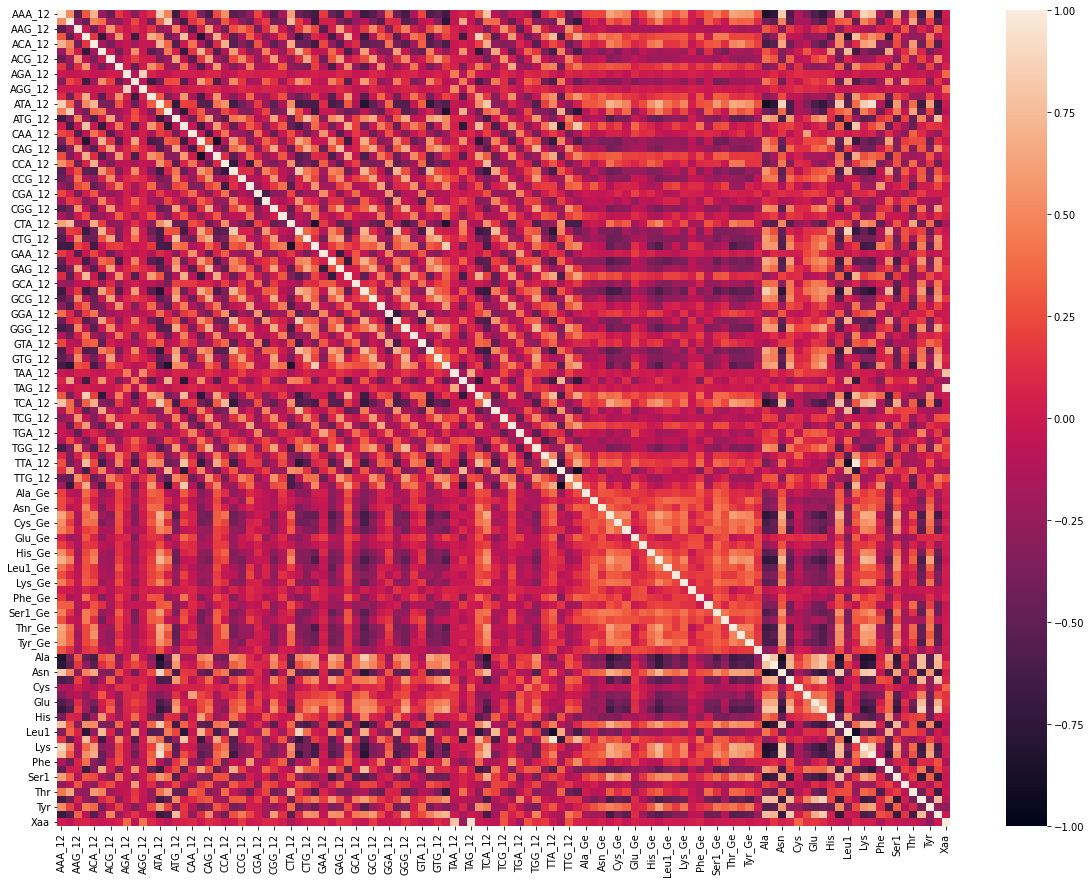

In [165]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrs, vmin=-1)
plt.savefig('HM.jpg', bbox_inches='tight')
plt.show()

In [160]:
import plotly.express as px
fig = px.imshow(corrs, x=corrs.columns, y=corrs.index, width=900,height=900, color_continuous_scale=px.colors.sequential.Hot)
# fig.update_layout()
fig.show()

In [147]:
corrs_5 = corrs[(corrs.abs() > 0.7).sum(axis=1) > 5]
corrs_5

AAA_12    AAC_12    AAG_12    AAT_12    ACA_12    ACC_12    ACG_12   
AAA_12  1.000000  0.520857 -0.547539  0.302067  0.701167 -0.240804 -0.470962  \
AAT_12  0.302067 -0.468886 -0.015711  1.000000  0.162003 -0.716053 -0.093246   
ACC_12 -0.240804  0.394208  0.014291 -0.716053 -0.182577  1.000000  0.000282   
ATA_12  0.857246  0.355181 -0.334569  0.508611  0.724936 -0.375301 -0.386651   
ATC_12  0.488742  0.844317 -0.193270 -0.416456  0.354288  0.438195 -0.216913   
ATT_12  0.030768 -0.608312 -0.014333  0.783072  0.000789 -0.681336 -0.035875   
CAC_12 -0.364467  0.316498  0.076470 -0.785610 -0.172284  0.713262  0.176146   
CCC_12 -0.522294  0.015634  0.294530 -0.490004 -0.525954  0.600213  0.259065   
CTC_12 -0.439946  0.191924  0.168462 -0.653753 -0.428659  0.720973  0.123161   
GCC_12 -0.670438 -0.090007  0.206177 -0.649855 -0.502897  0.613288  0.284195   
GTT_12 -0.647484 -0.758085  0.295239  0.215922 -0.598912 -0.255127  0.296762   
TAT_12  0.307617 -0.373766  0.001370  0.853214  0.211084 -0.723972 -0.053980   
TCA_12  0.794991  0.380774 -0.373267  0.333967  0.686408 -0.323568 -0.409518   
TTA_12  0.282156 -0.383326 -0.169324  0.756198  0.248566 -0.617198 -0.233181   
TTC_12  0.128869  0.619007 -0.141168 -0.597638  0.092529  0.488298 -0.081936   
TTT_12 -0.174098 -0.684864  0.191239  0.674227 -0.205633 -0.574785  0.123069   
Ile_Ge  0.702657  0.482159 -0.174877  0.256650  0.469280 -0.214445 -0.237517   
Ala    -0.830737 -0.412502  0.335979 -0.436793 -0.611239  0.296500  0.417058   
Arg    -0.733341 -0.470104  0.195801 -0.286134 -0.525813  0.144609  0.318715   
Asn     0.834629  0.475648 -0.326735  0.477684  0.643267 -0.325837 -0.380708   
Gly    -0.698736 -0.525628  0.225335 -0.178849 -0.518117  0.015592  0.365417   
Ile     0.772119  0.279216 -0.341369  0.532722  0.512545 -0.378179 -0.405053   
Leu1   -0.325705  0.348823  0.088126 -0.747196 -0.257383  0.749347  0.092383   
Leu2    0.159861 -0.479777 -0.033364  0.759636  0.123862 -0.635076 -0.115678   
Lys     0.887700  0.468879 -0.155316  0.352232  0.604984 -0.310243 -0.252399   
Met     0.775592  0.294256 -0.199139  0.534205  0.671412 -0.454249 -0.203152   
Trp    -0.620406 -0.420419  0.115736 -0.234627 -0.418314  0.096160  0.241216   
Val    -0.670748 -0.517868  0.380797 -0.089470 -0.521744 -0.130552  0.513924   

          ACT_12    AGA_12    AGC_12  ...       Met       Phe       Pro   
AAA_12  0.155086 -0.020136 -0.337438  ...  0.775592 -0.132060 -0.506632  \
AAT_12  0.564677  0.025817 -0.634646  ...  0.534205  0.388360 -0.660075   
ACC_12 -0.393730 -0.056639  0.536587  ... -0.454249 -0.425295  0.654672   
ATA_12  0.289902 -0.038702 -0.459837  ...  0.940395 -0.109892 -0.671441   
ATC_12 -0.180849 -0.052840  0.221280  ...  0.236917 -0.398931  0.041085   
ATT_12  0.426669  0.027078 -0.511101  ...  0.252119  0.437800 -0.443991   
CAC_12 -0.540159 -0.010195  0.649149  ... -0.528067 -0.353780  0.655226   
CCC_12 -0.305583 -0.013570  0.531084  ... -0.645971 -0.002794  0.682000   
CTC_12 -0.320607 -0.019085  0.582917  ... -0.684958 -0.062594  0.711934   
GCC_12 -0.512079 -0.041145  0.618534  ... -0.783522 -0.101435  0.774188   
GTT_12  0.156682 -0.004762 -0.038654  ... -0.507291  0.527668  0.142329   
TAT_12  0.463877 -0.010509 -0.578134  ...  0.551453  0.353680 -0.645045   
TCA_12  0.179729 -0.051980 -0.361494  ...  0.772534 -0.147173 -0.540995   
TTA_12  0.475974  0.009701 -0.586868  ...  0.460563  0.241565 -0.535509   
TTC_12 -0.398426 -0.086277  0.458217  ... -0.154977 -0.154022  0.344841   
TTT_12  0.436109  0.032346 -0.414527  ...  0.085640  0.520232 -0.343253   
Ile_Ge  0.159935 -0.015464 -0.283626  ...  0.683548 -0.116676 -0.510649   
Ala    -0.323386  0.001603  0.448388  ... -0.807573  0.104057  0.637683   
Arg    -0.229743  0.090850  0.281028  ... -0.683334  0.137142  0.524219   
Asn     0.249657 -0.015268 -0.431970  ...  0.830572 -0.034034 -0.606226   
Gly    -0.226249  0.065421  0.169201  ... -0.610563  0.160829  0.393841   
Ile     0.366721 -0.046968 -0.476588  .

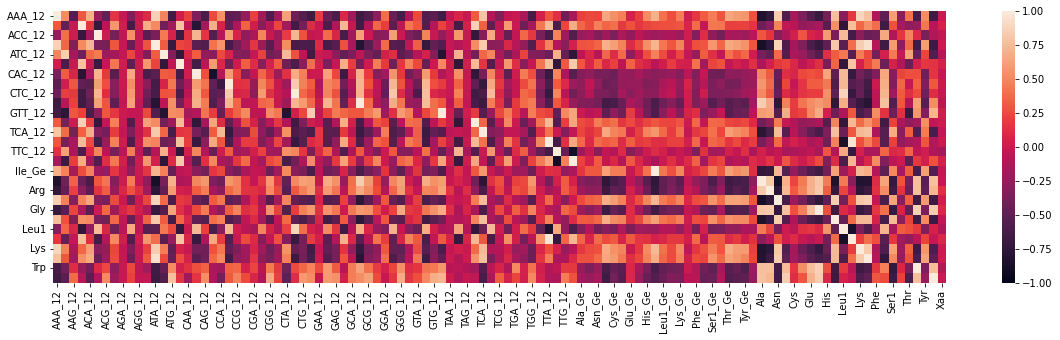

In [148]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(corrs_5, vmin=-1)
plt.show()

In [116]:
corrs.loc['AAA_12'','TAG_12':'TTT_12']

TAG_12   -0.020794
TAT_12    0.307617
TCA_12    0.794991
TCC_12   -0.114261
TCG_12   -0.338819
TCT_12   -0.044548
TGA_12   -0.012302
TGC_12   -0.160344
TGG_12   -0.624121
TGT_12    0.043014
TTA_12    0.282156
TTC_12    0.128869
TTG_12   -0.440750
TTT_12   -0.174098
Name: AAA_12, dtype: float64

In [98]:
# write Gibbs energy into the table 
with open(r'C:\Users\Эльдар\Downloads\out.fst', 'r') as handle:
    trna_parsed_list = list(SeqIO.parse(handle, "fasta"))


trna_dic_gib = {}
for i in range(len(trna_parsed_list)):
    description = trna_parsed_list[i].id.split('|')
    species = description[1]
    aa = description[-2]

    seq = str(trna_parsed_list[i].seq)
    seq_gib = [s for s in seq if s.isdigit()]
    gib = float(seq[seq.find(seq_gib[0])-1 : seq.find(seq_gib[-1])+1])

    if species not in trna_dic_gib:
        trna_dic_gib[species] = {}
    trna_dic_gib[species][aa] = gib
    
for species in trna_dic_gib:
    if species in tablee.Species.values:
        for aa in trna_dic_gib[species]:
            tablee.loc[tablee.Species==species, f'{aa}_Ge'] = trna_dic_gib[species][aa]

In [105]:
tablee = tablee.convert_dtypes()
tablee.to_csv('Tablee.csv', index=False)
tablee.to_csv(r'C:/Work/Lab/pr-29-trna-or-mutagenesis/raw/MutSpec_CU_tRNA.csv', sep='\t', index=False)

## Density plot

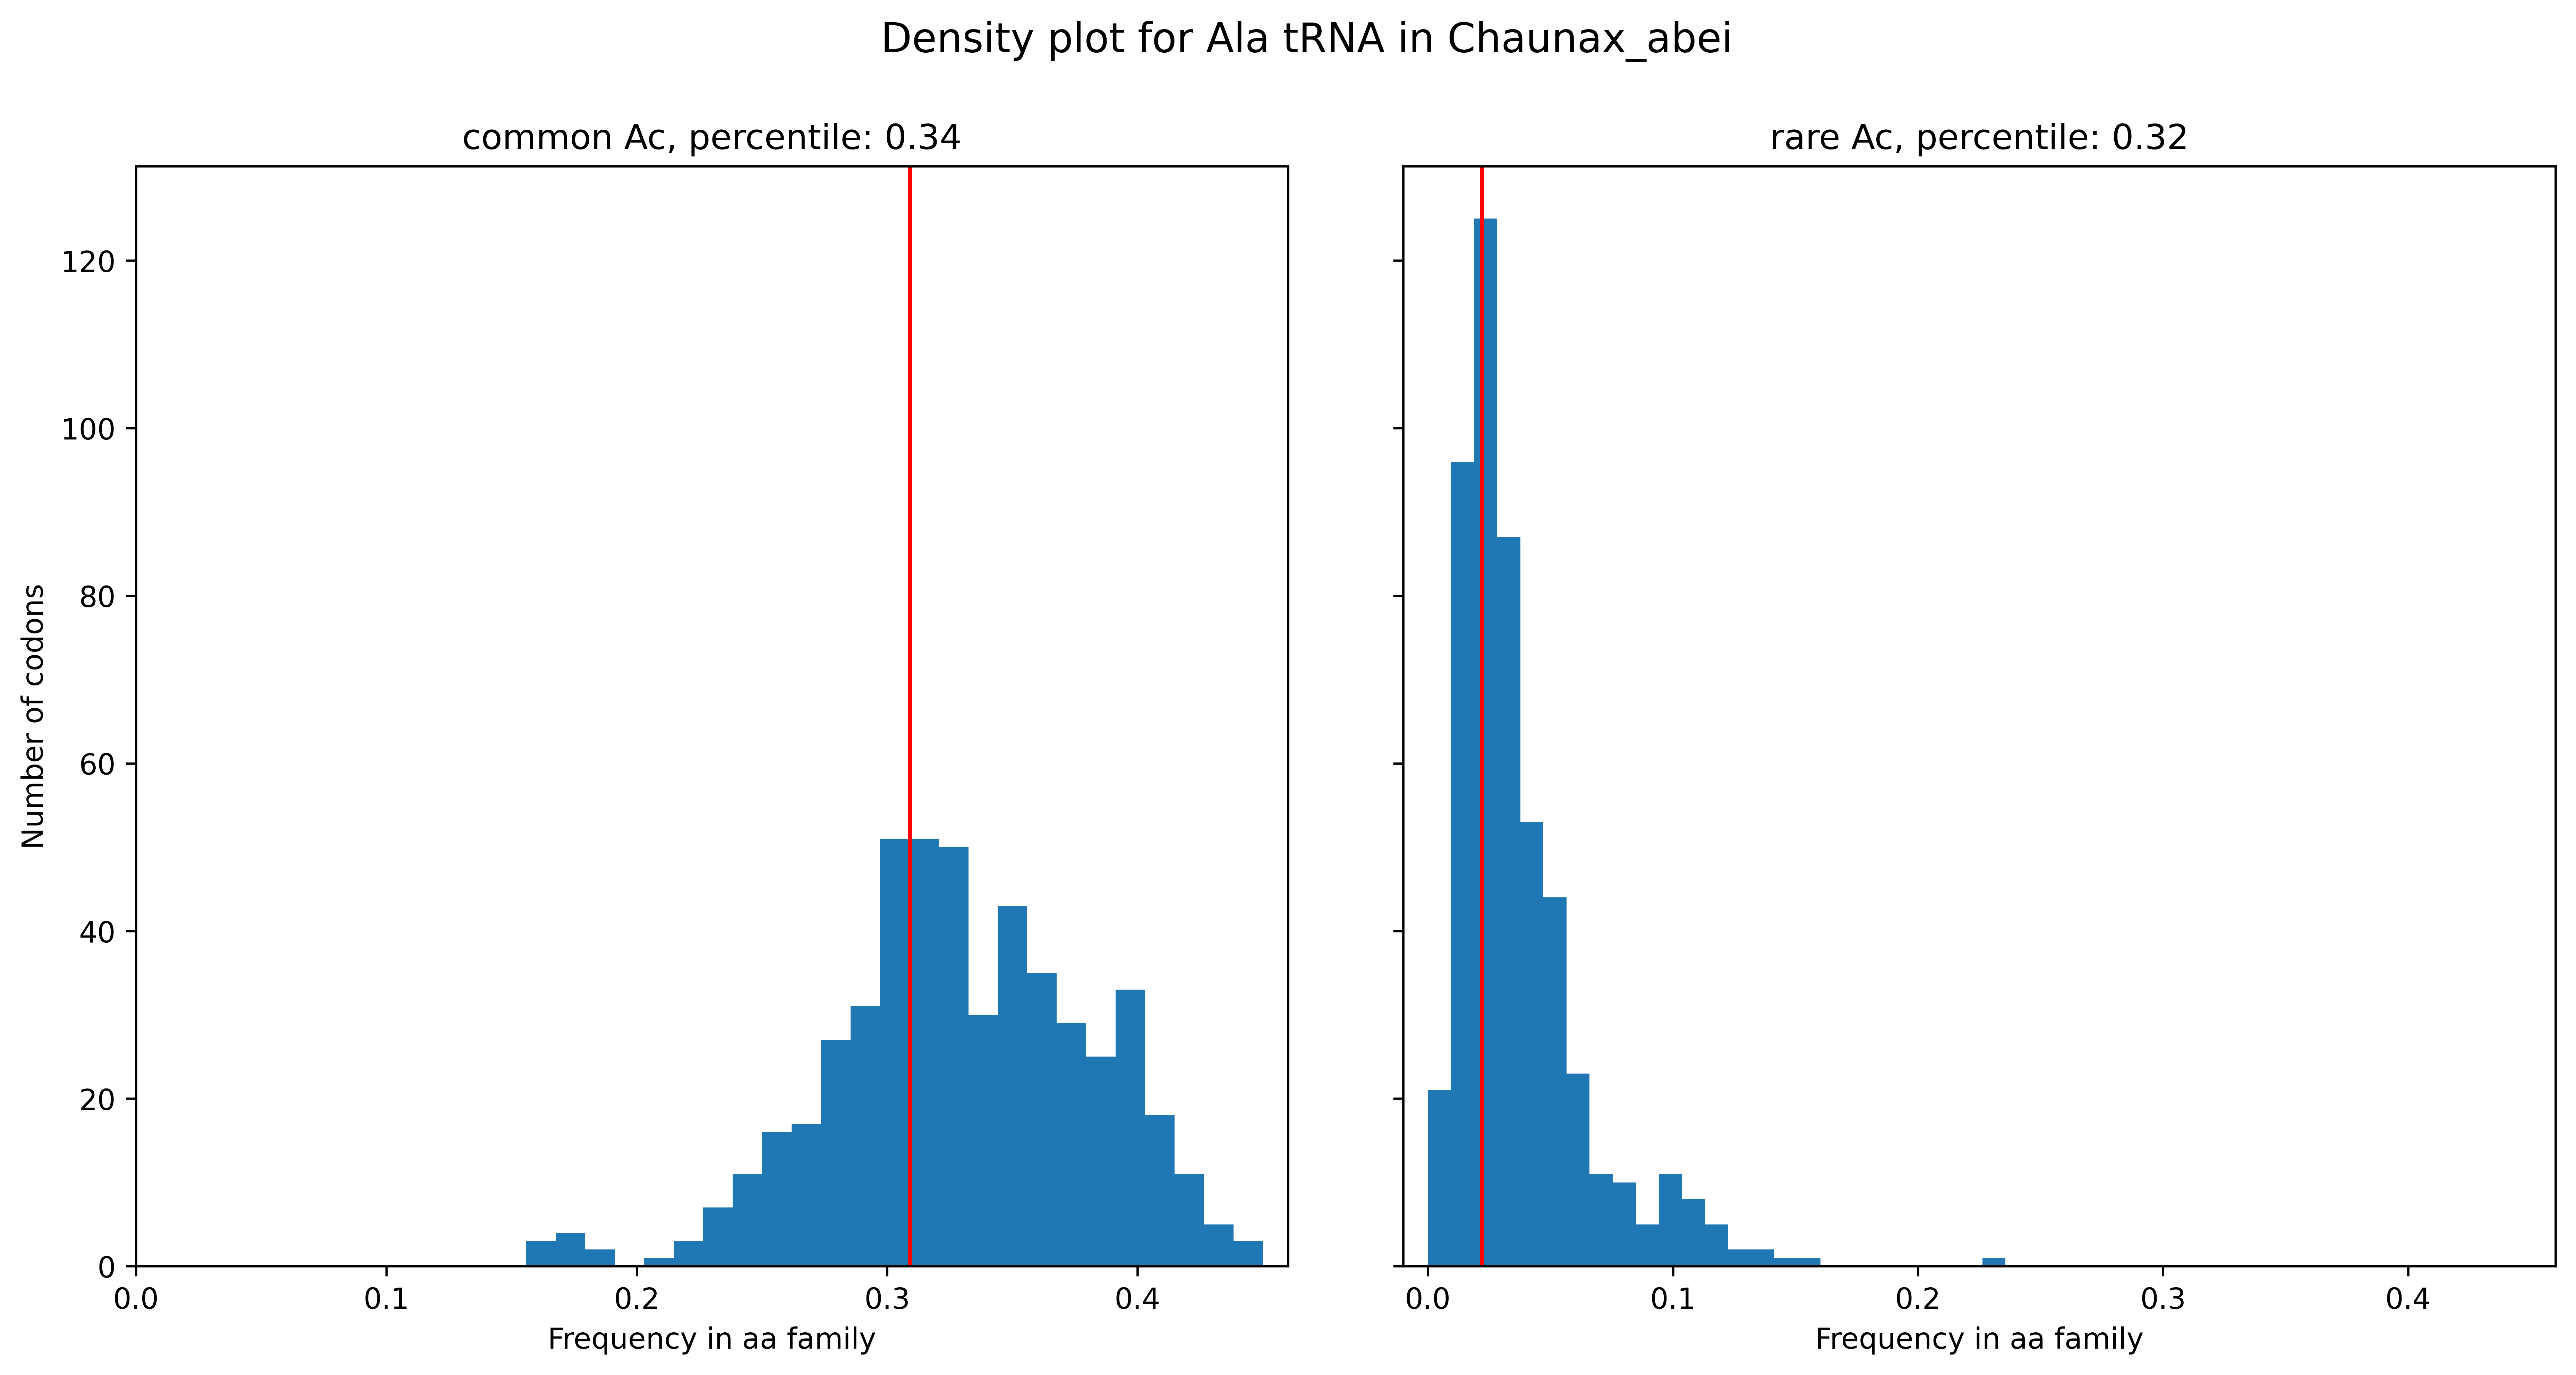

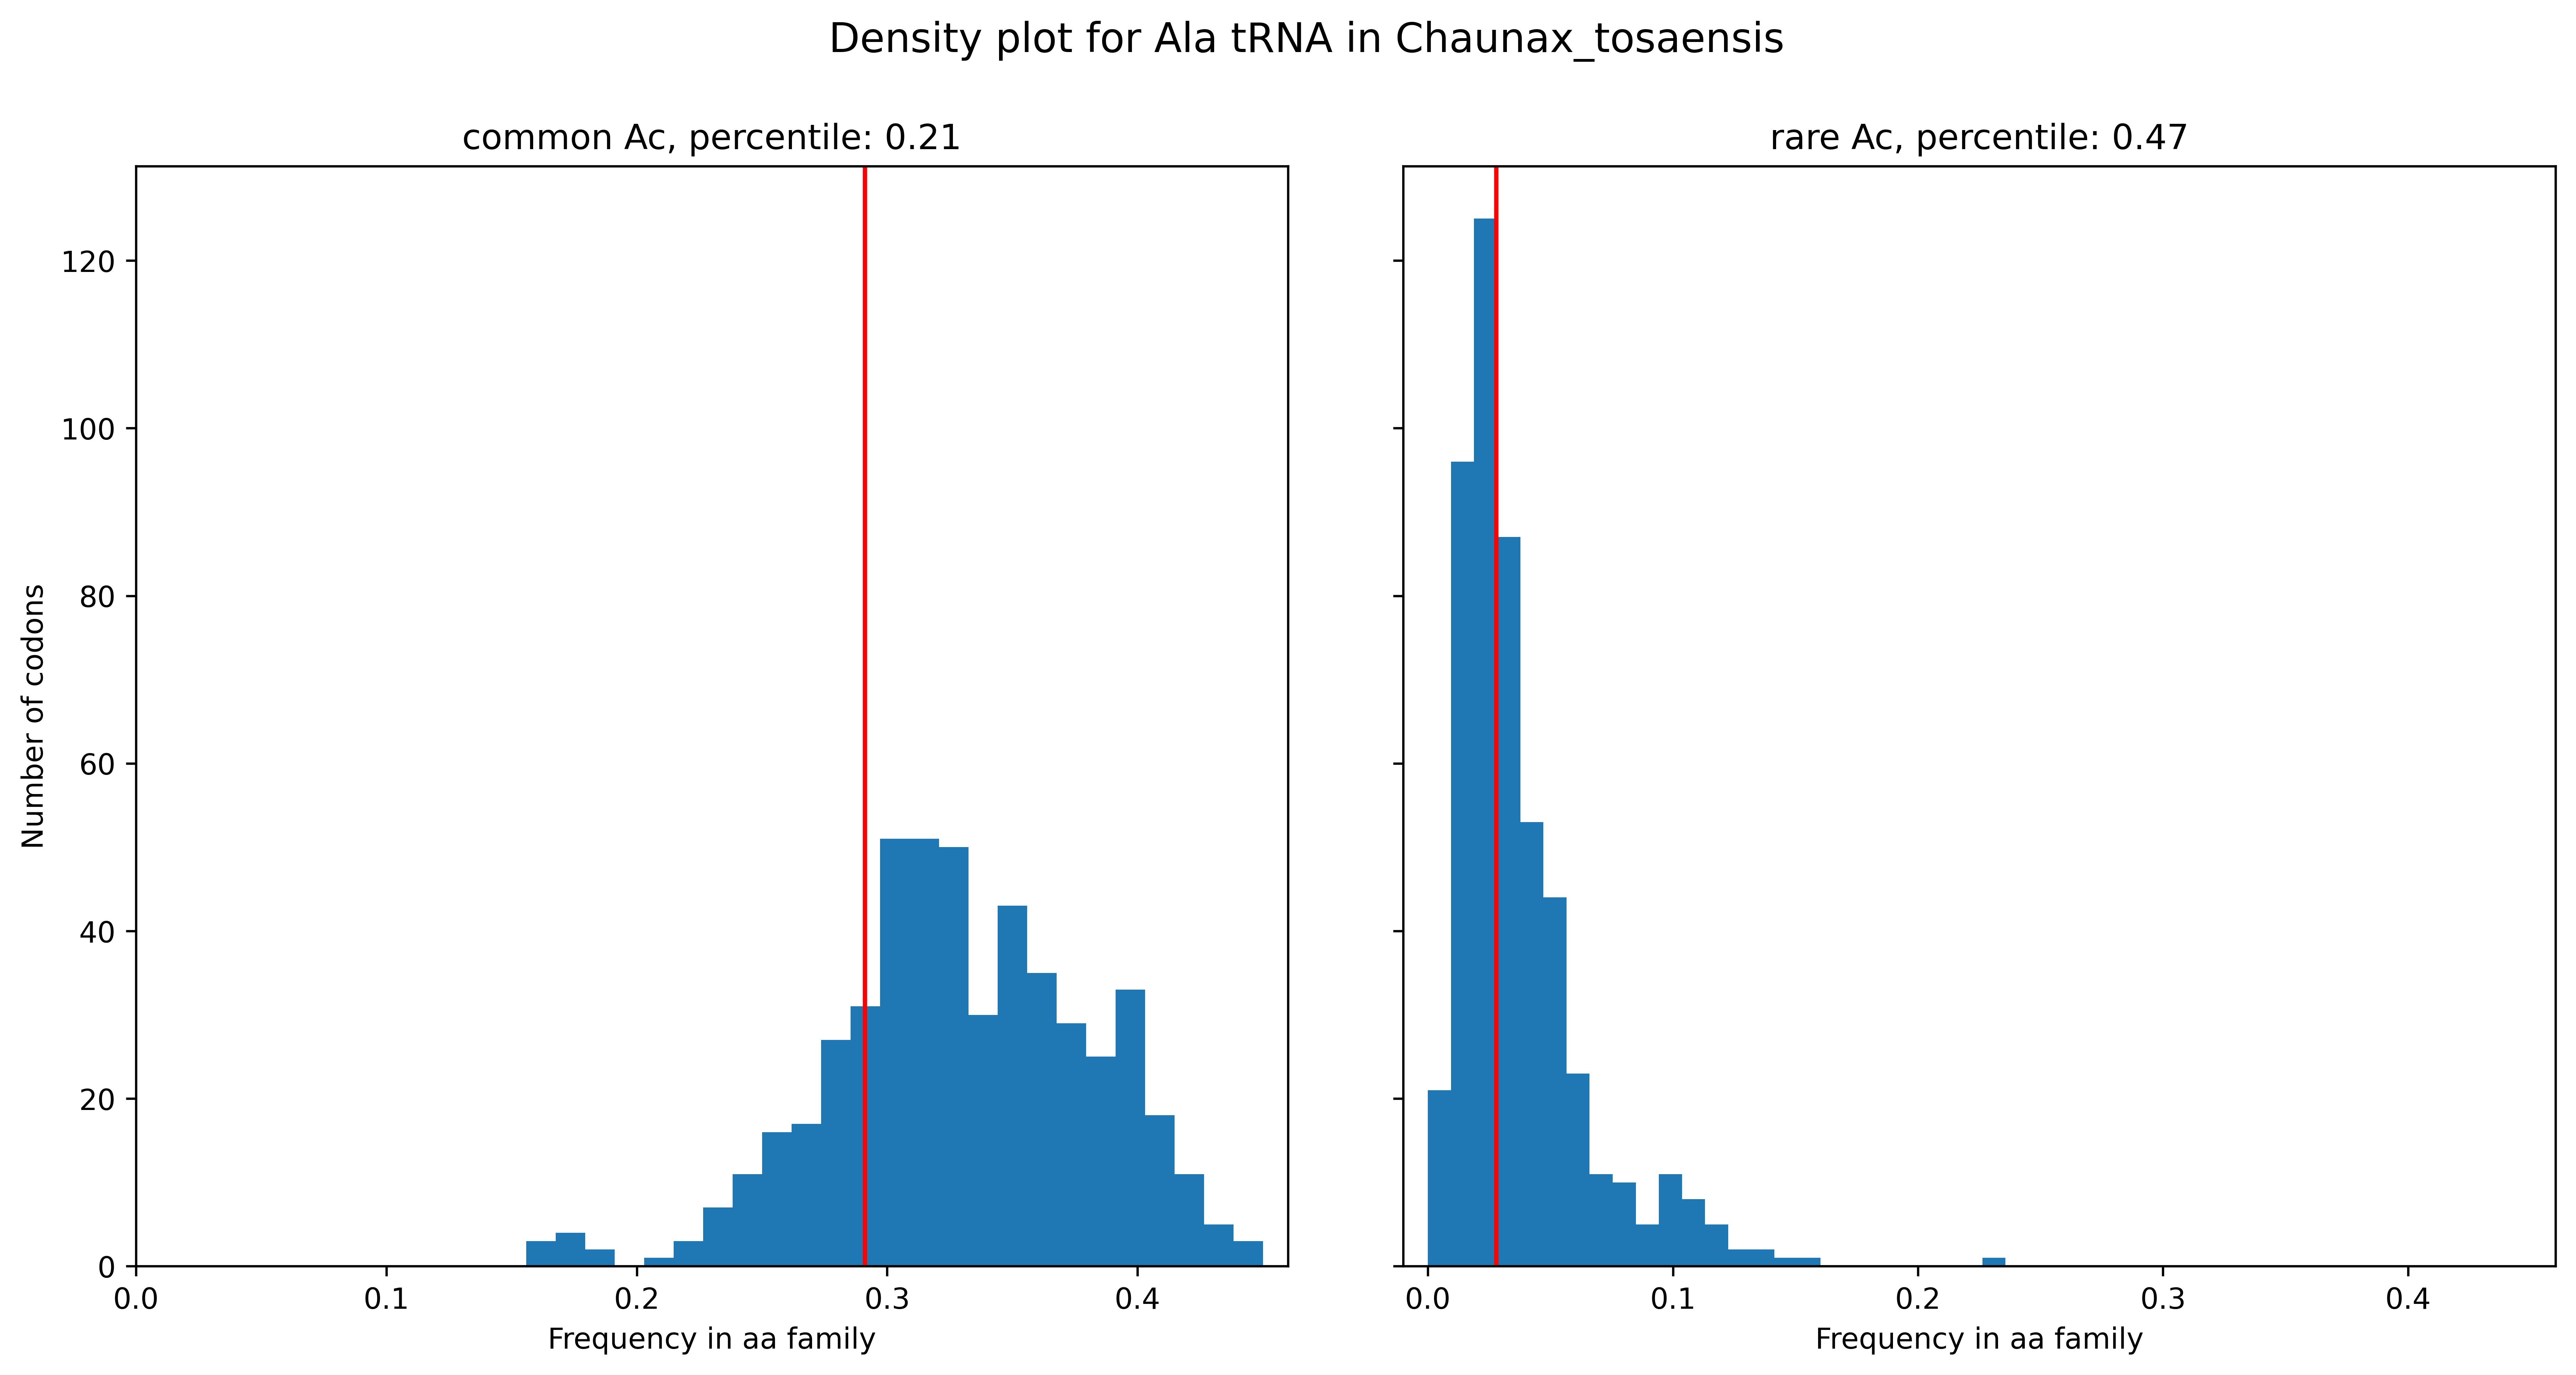

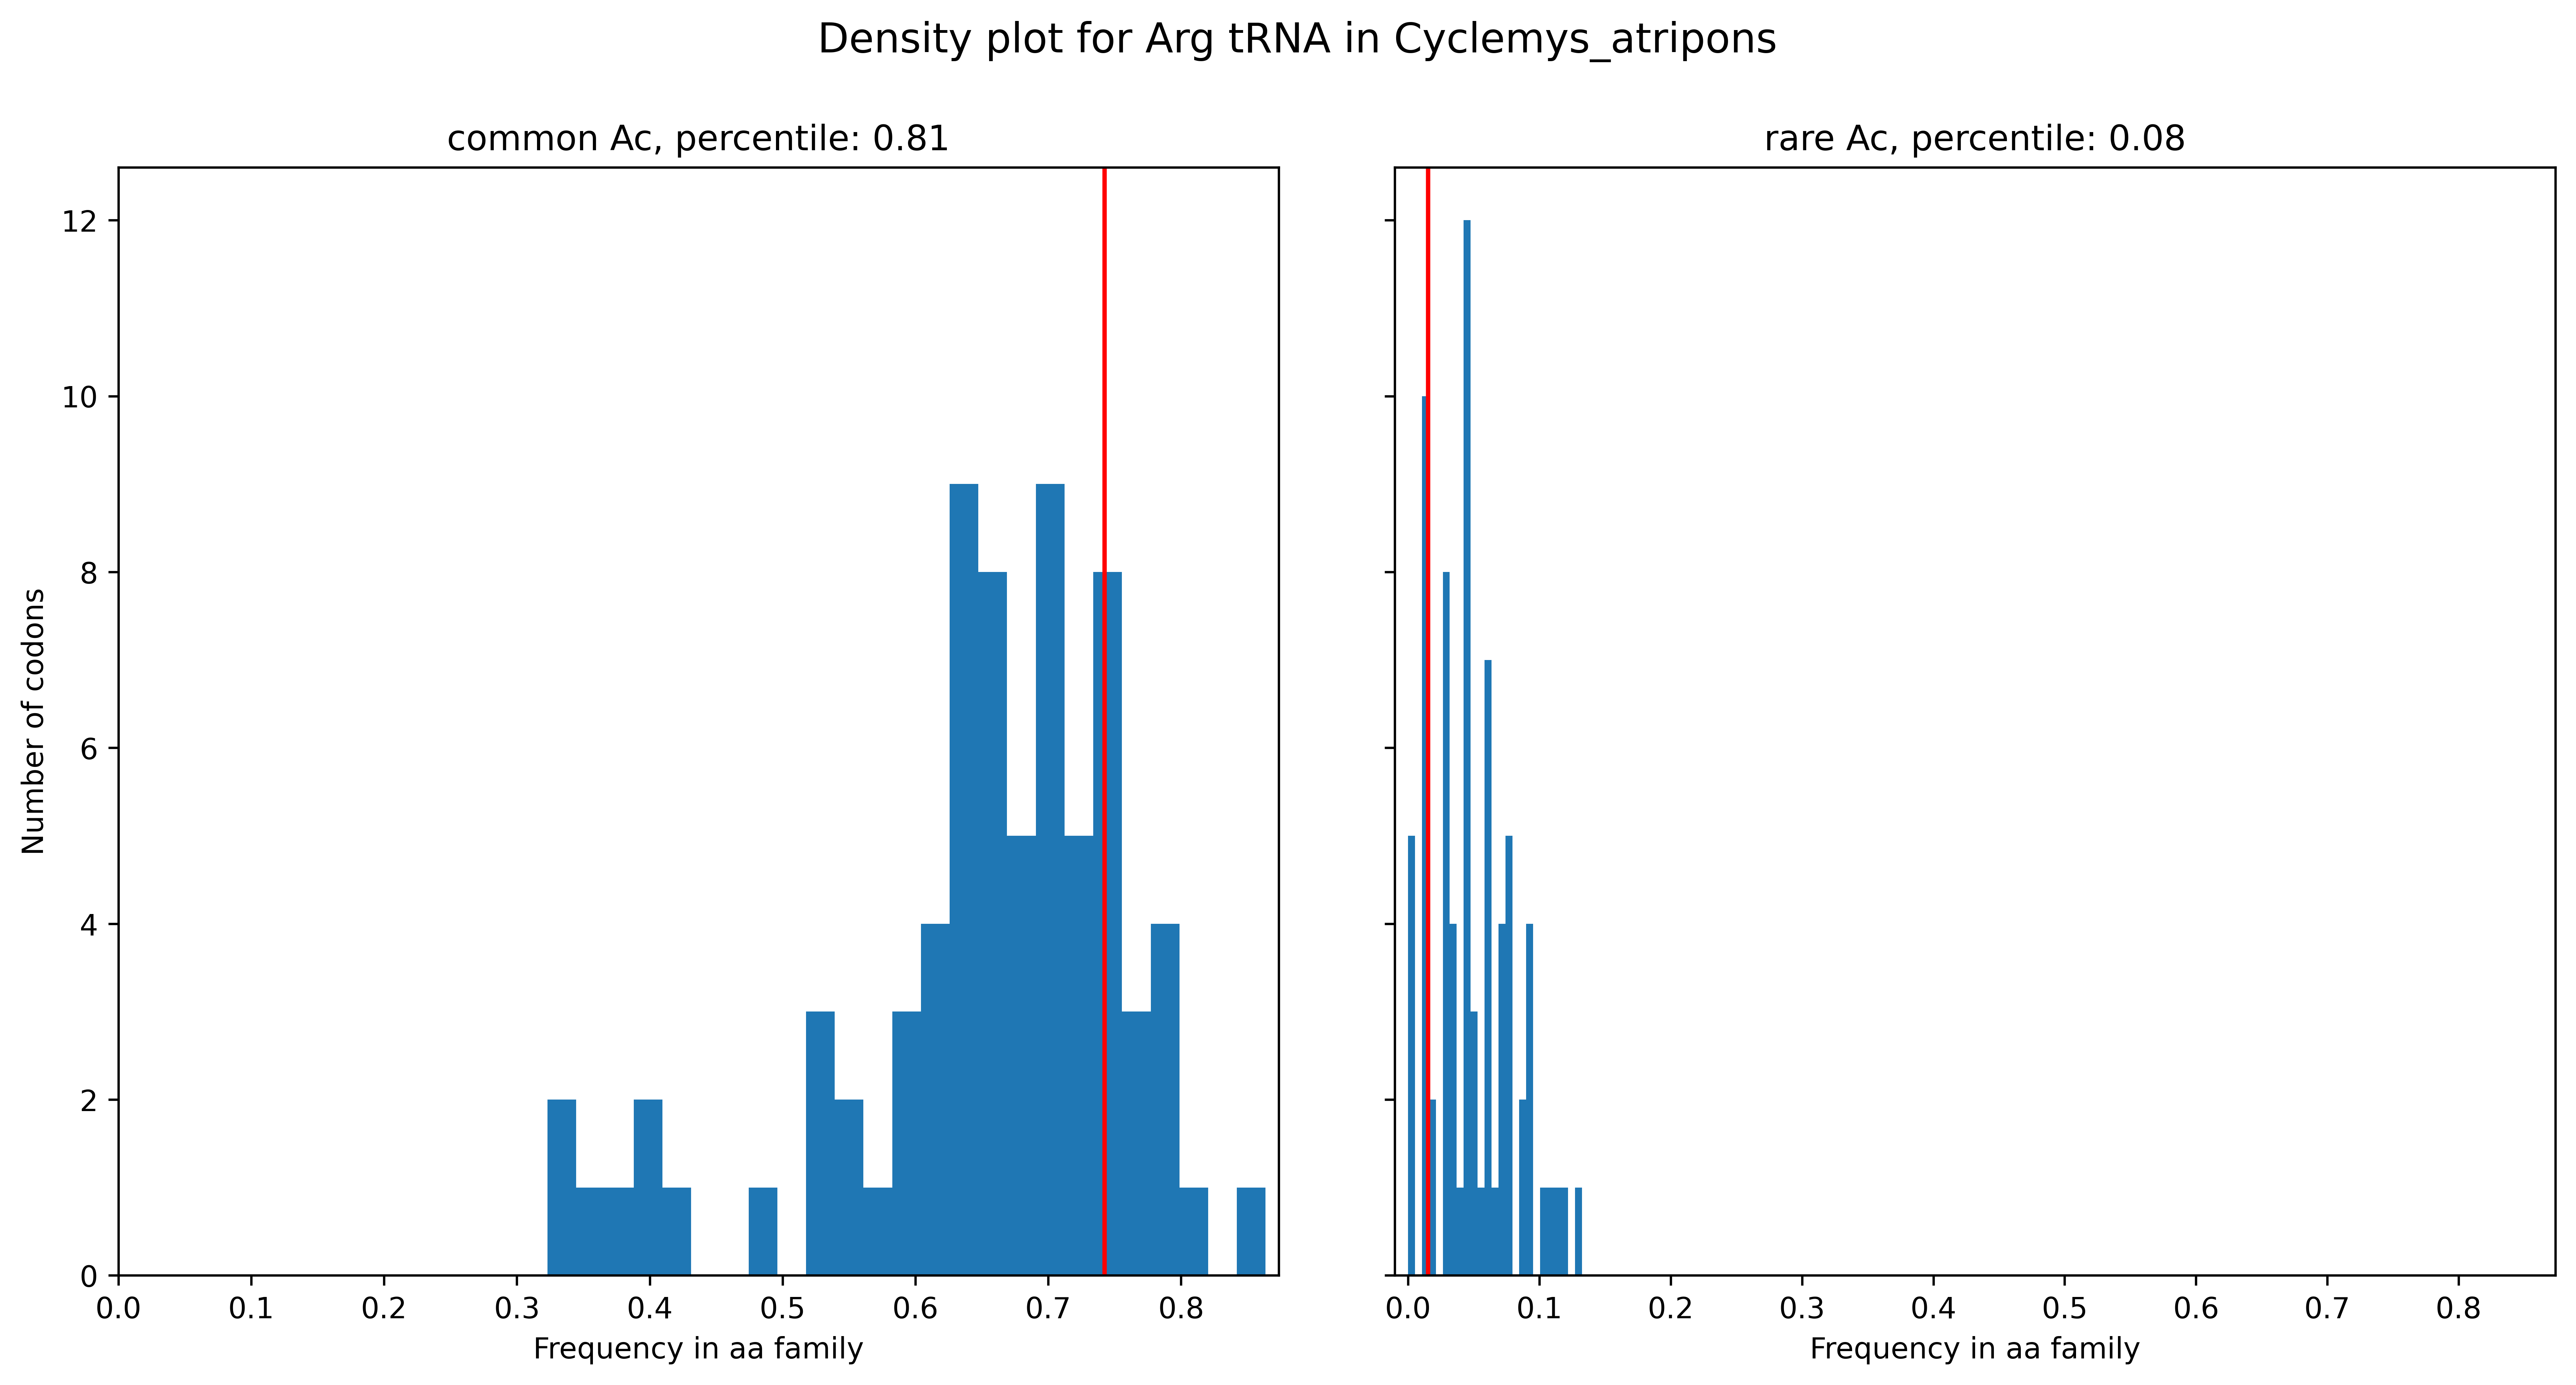

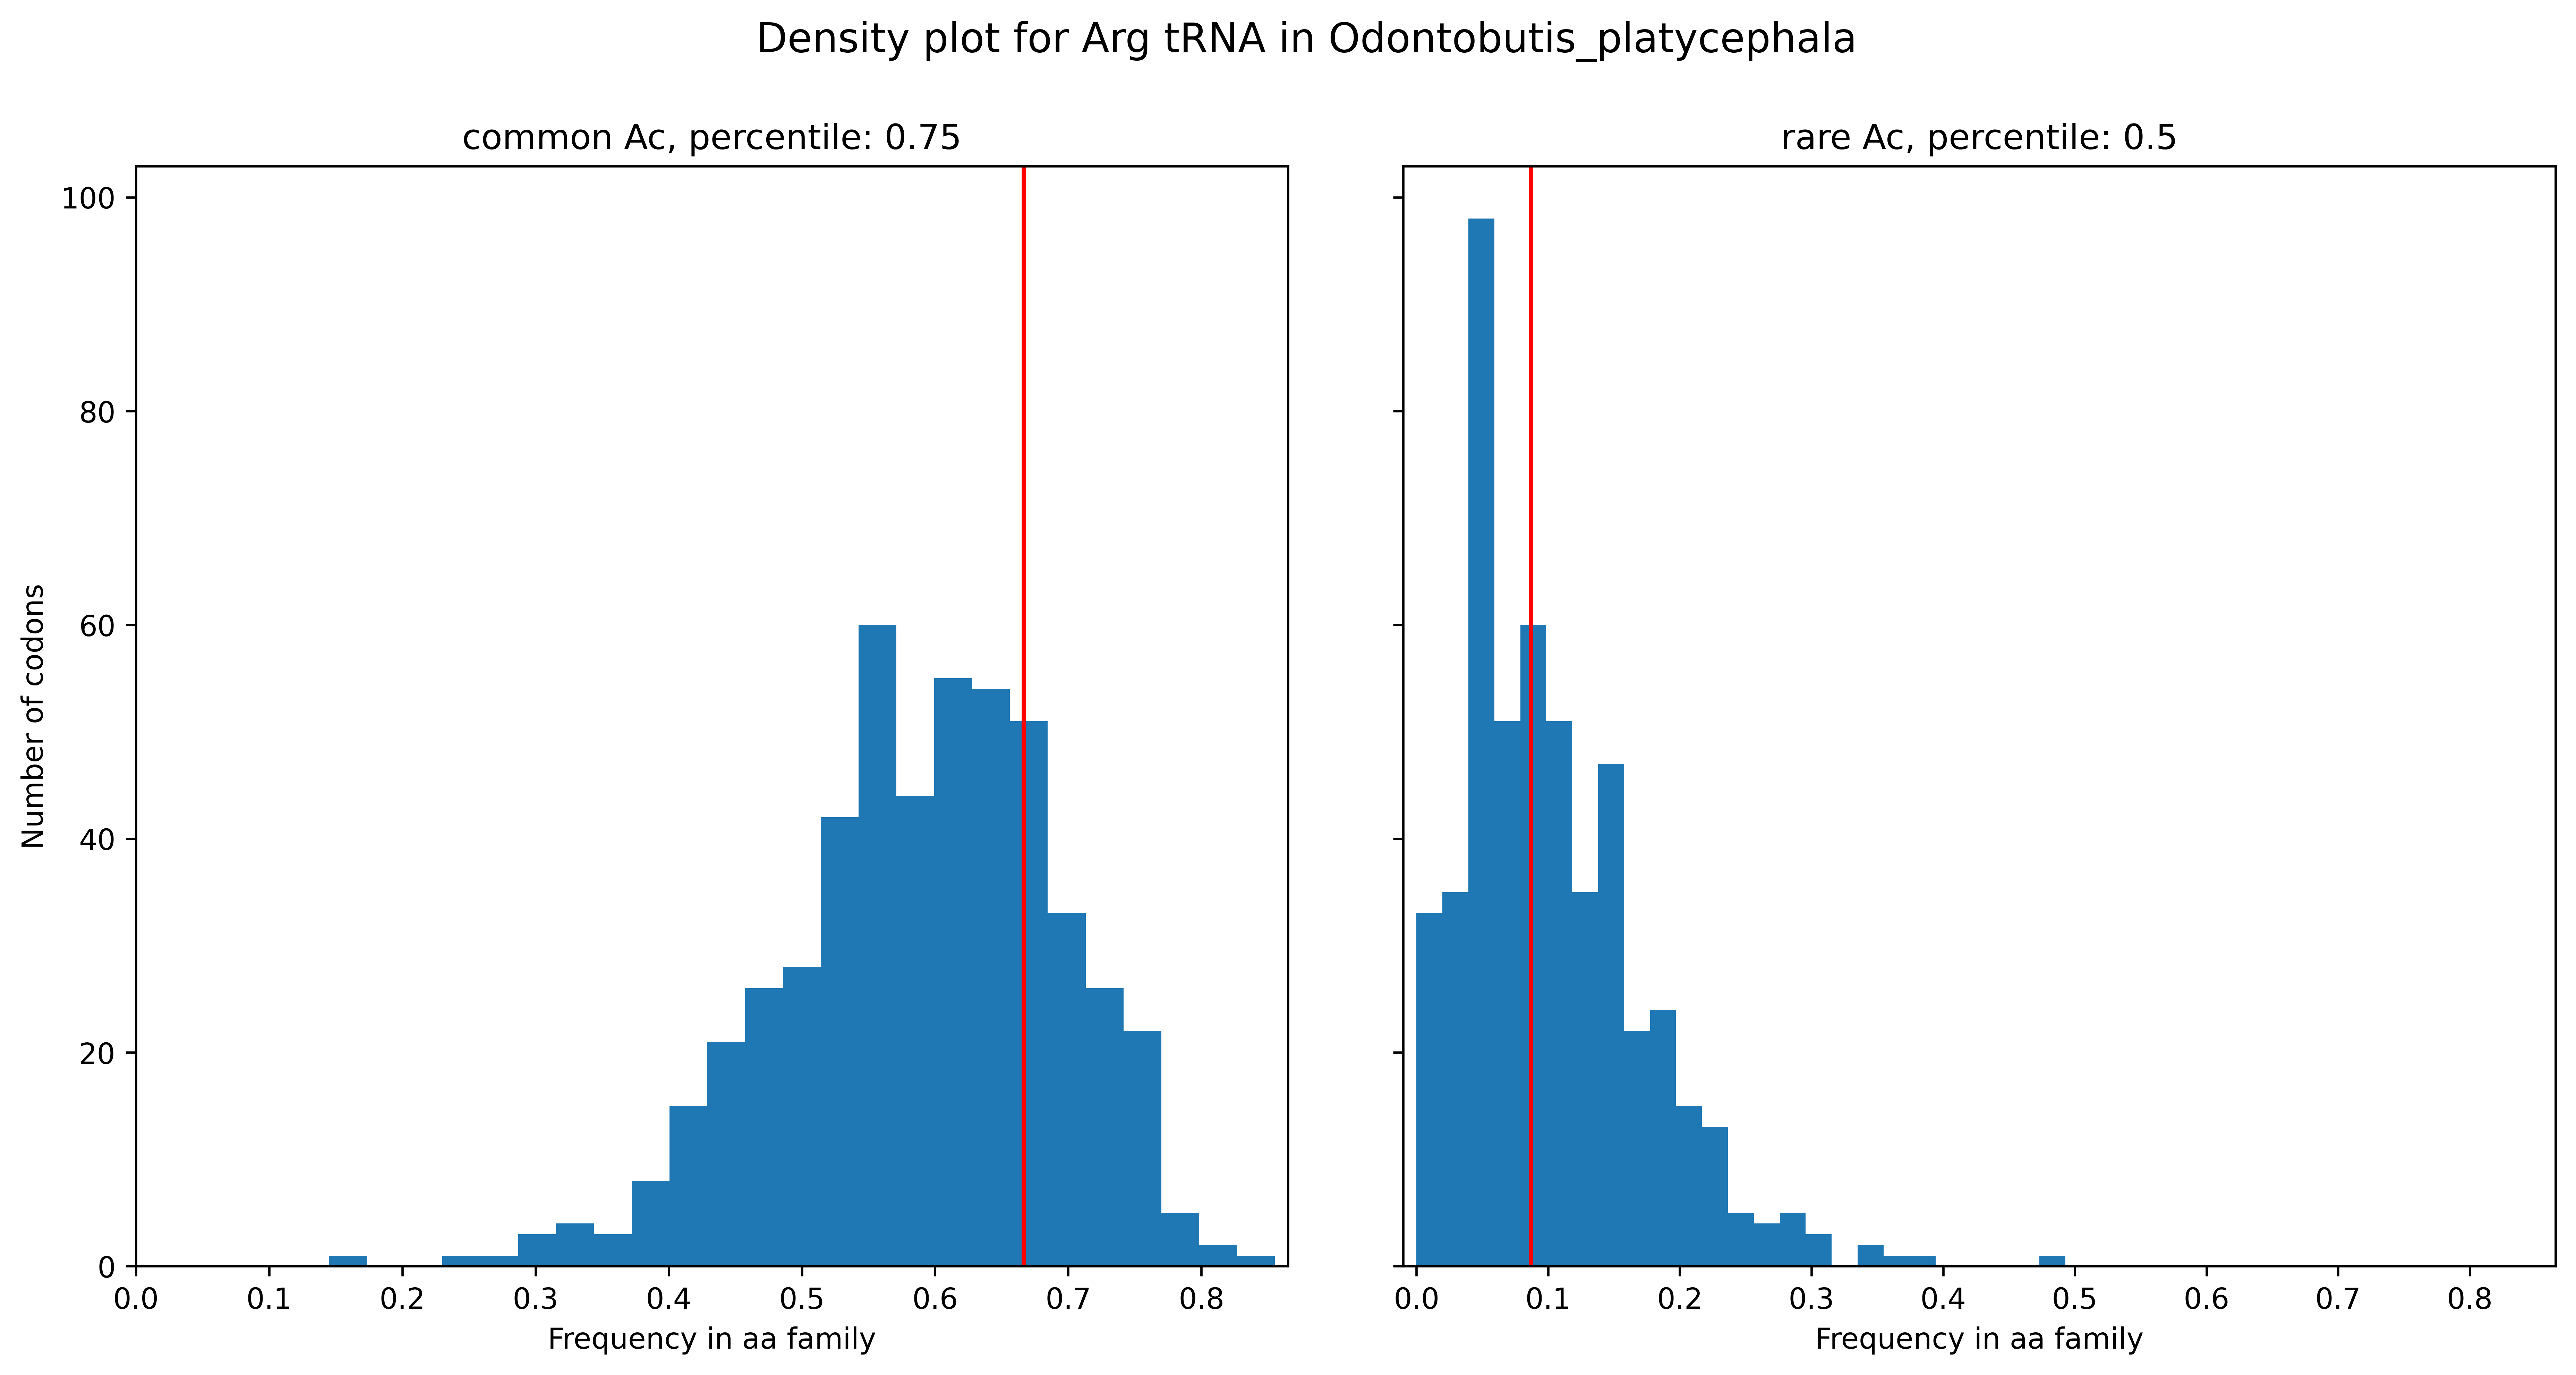

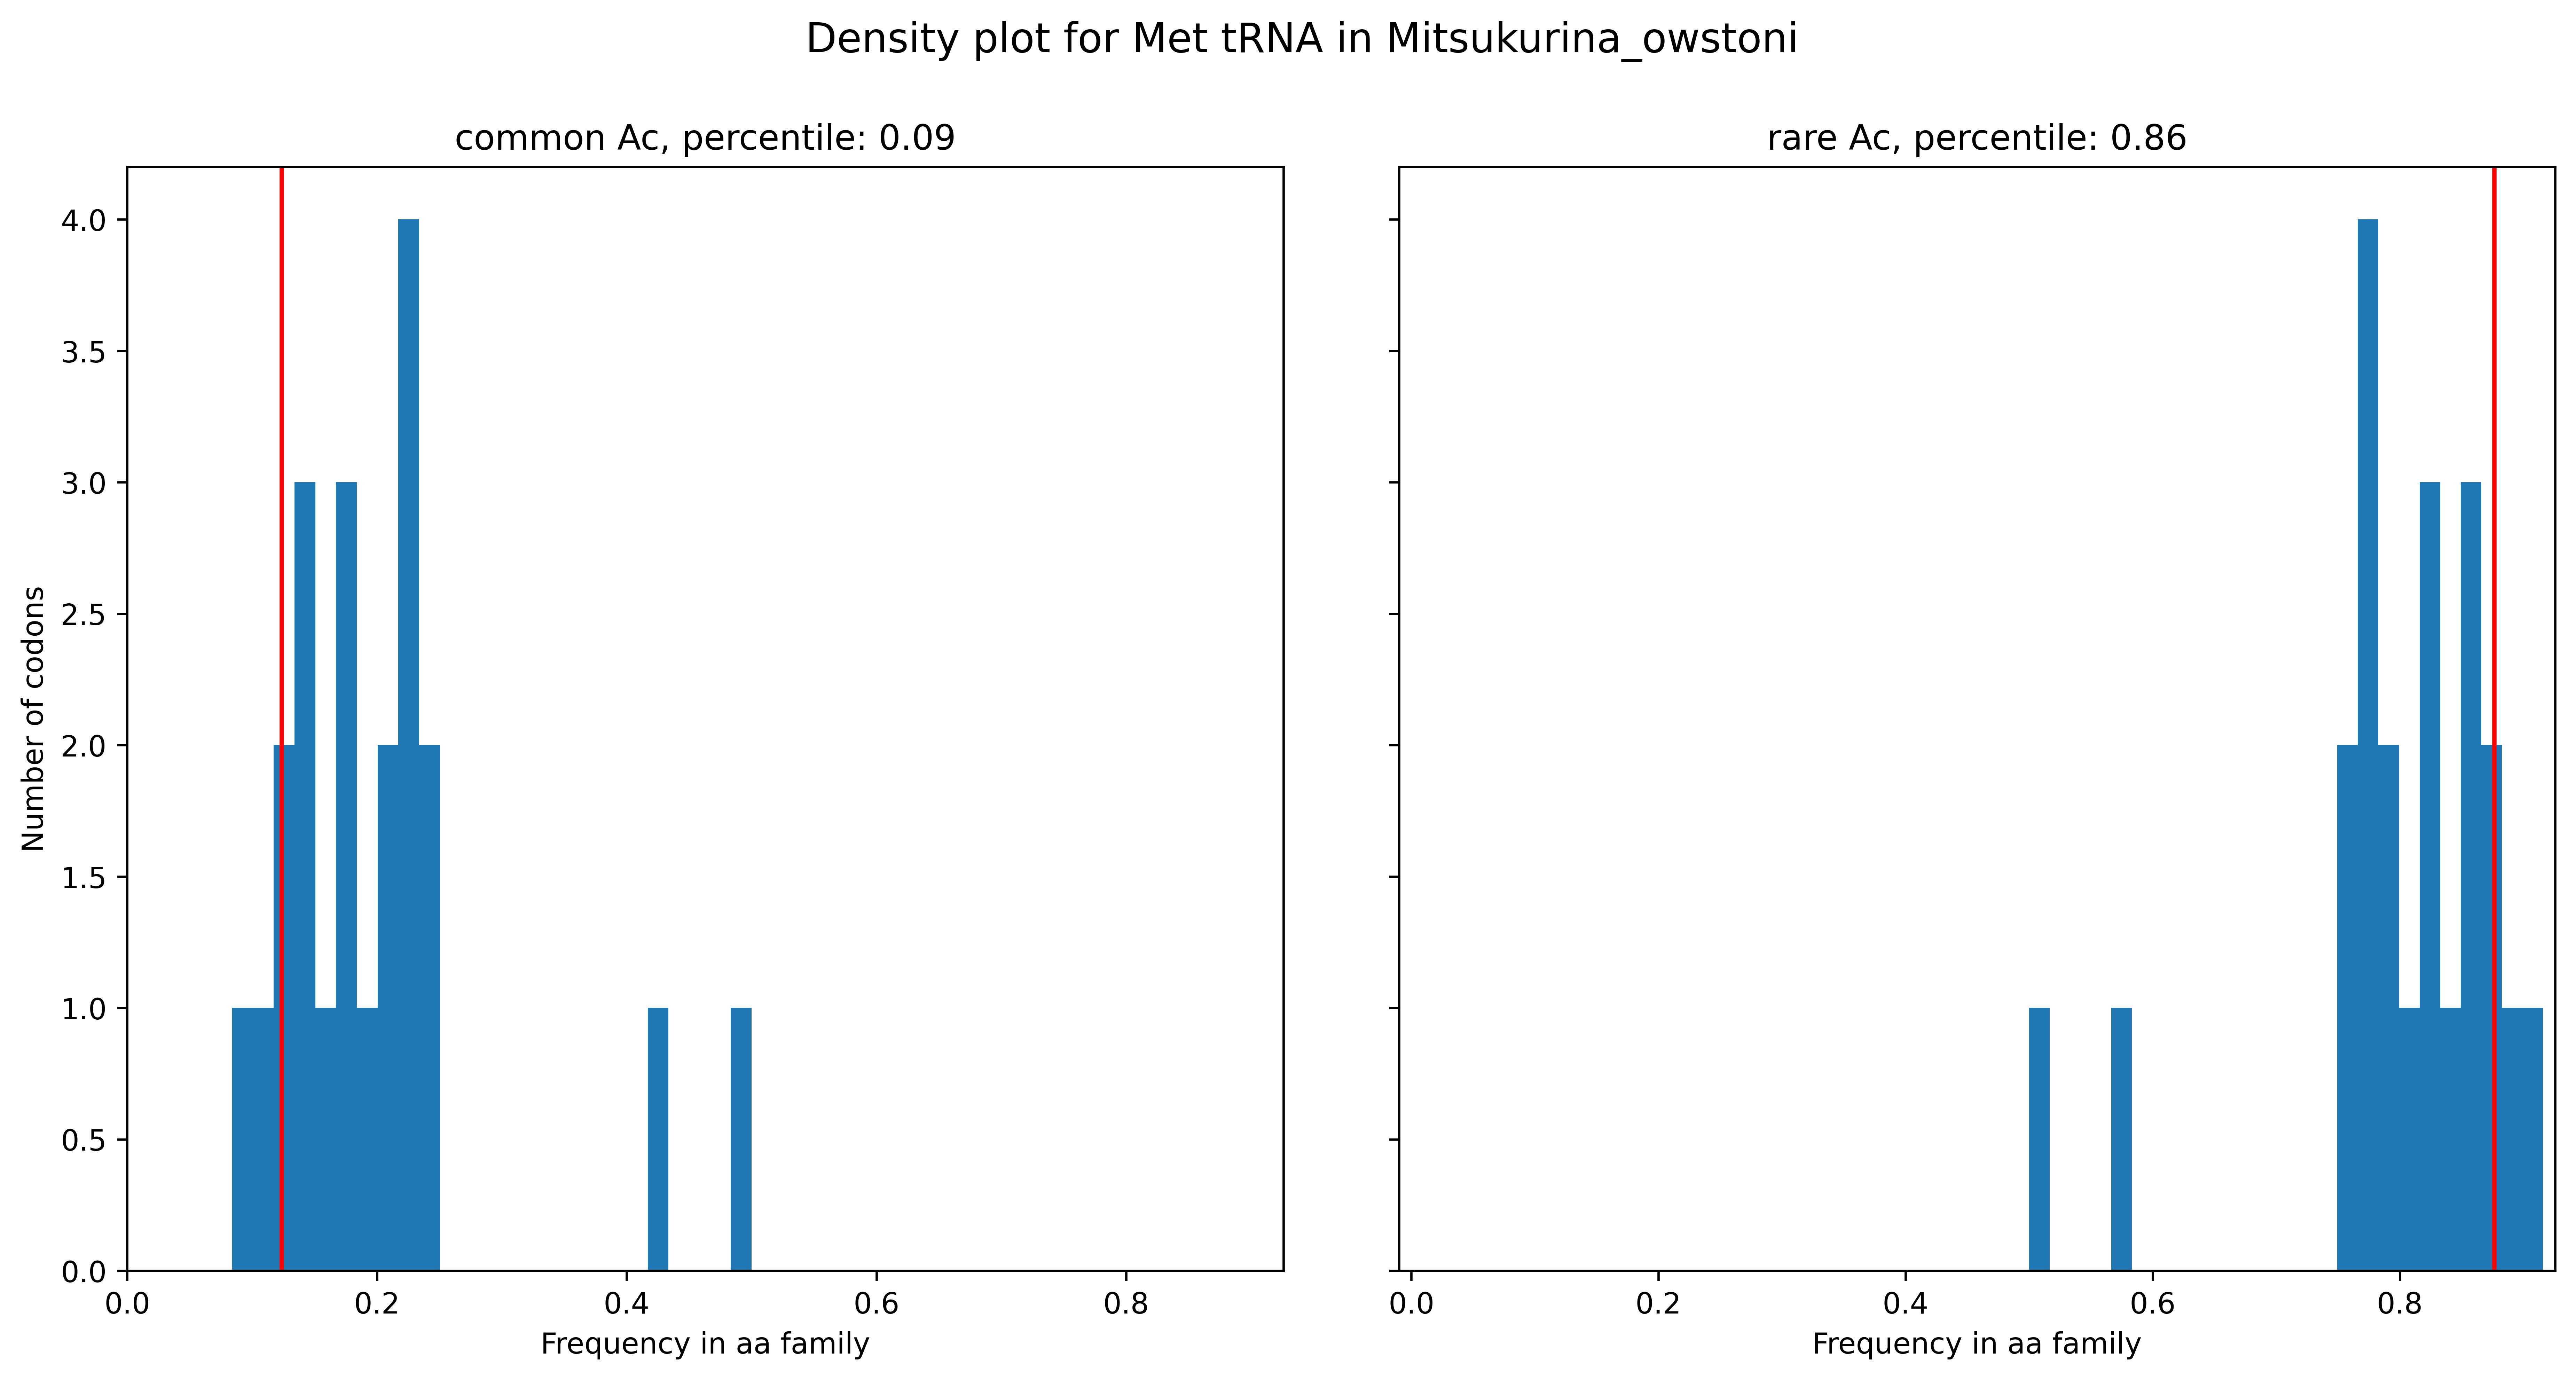

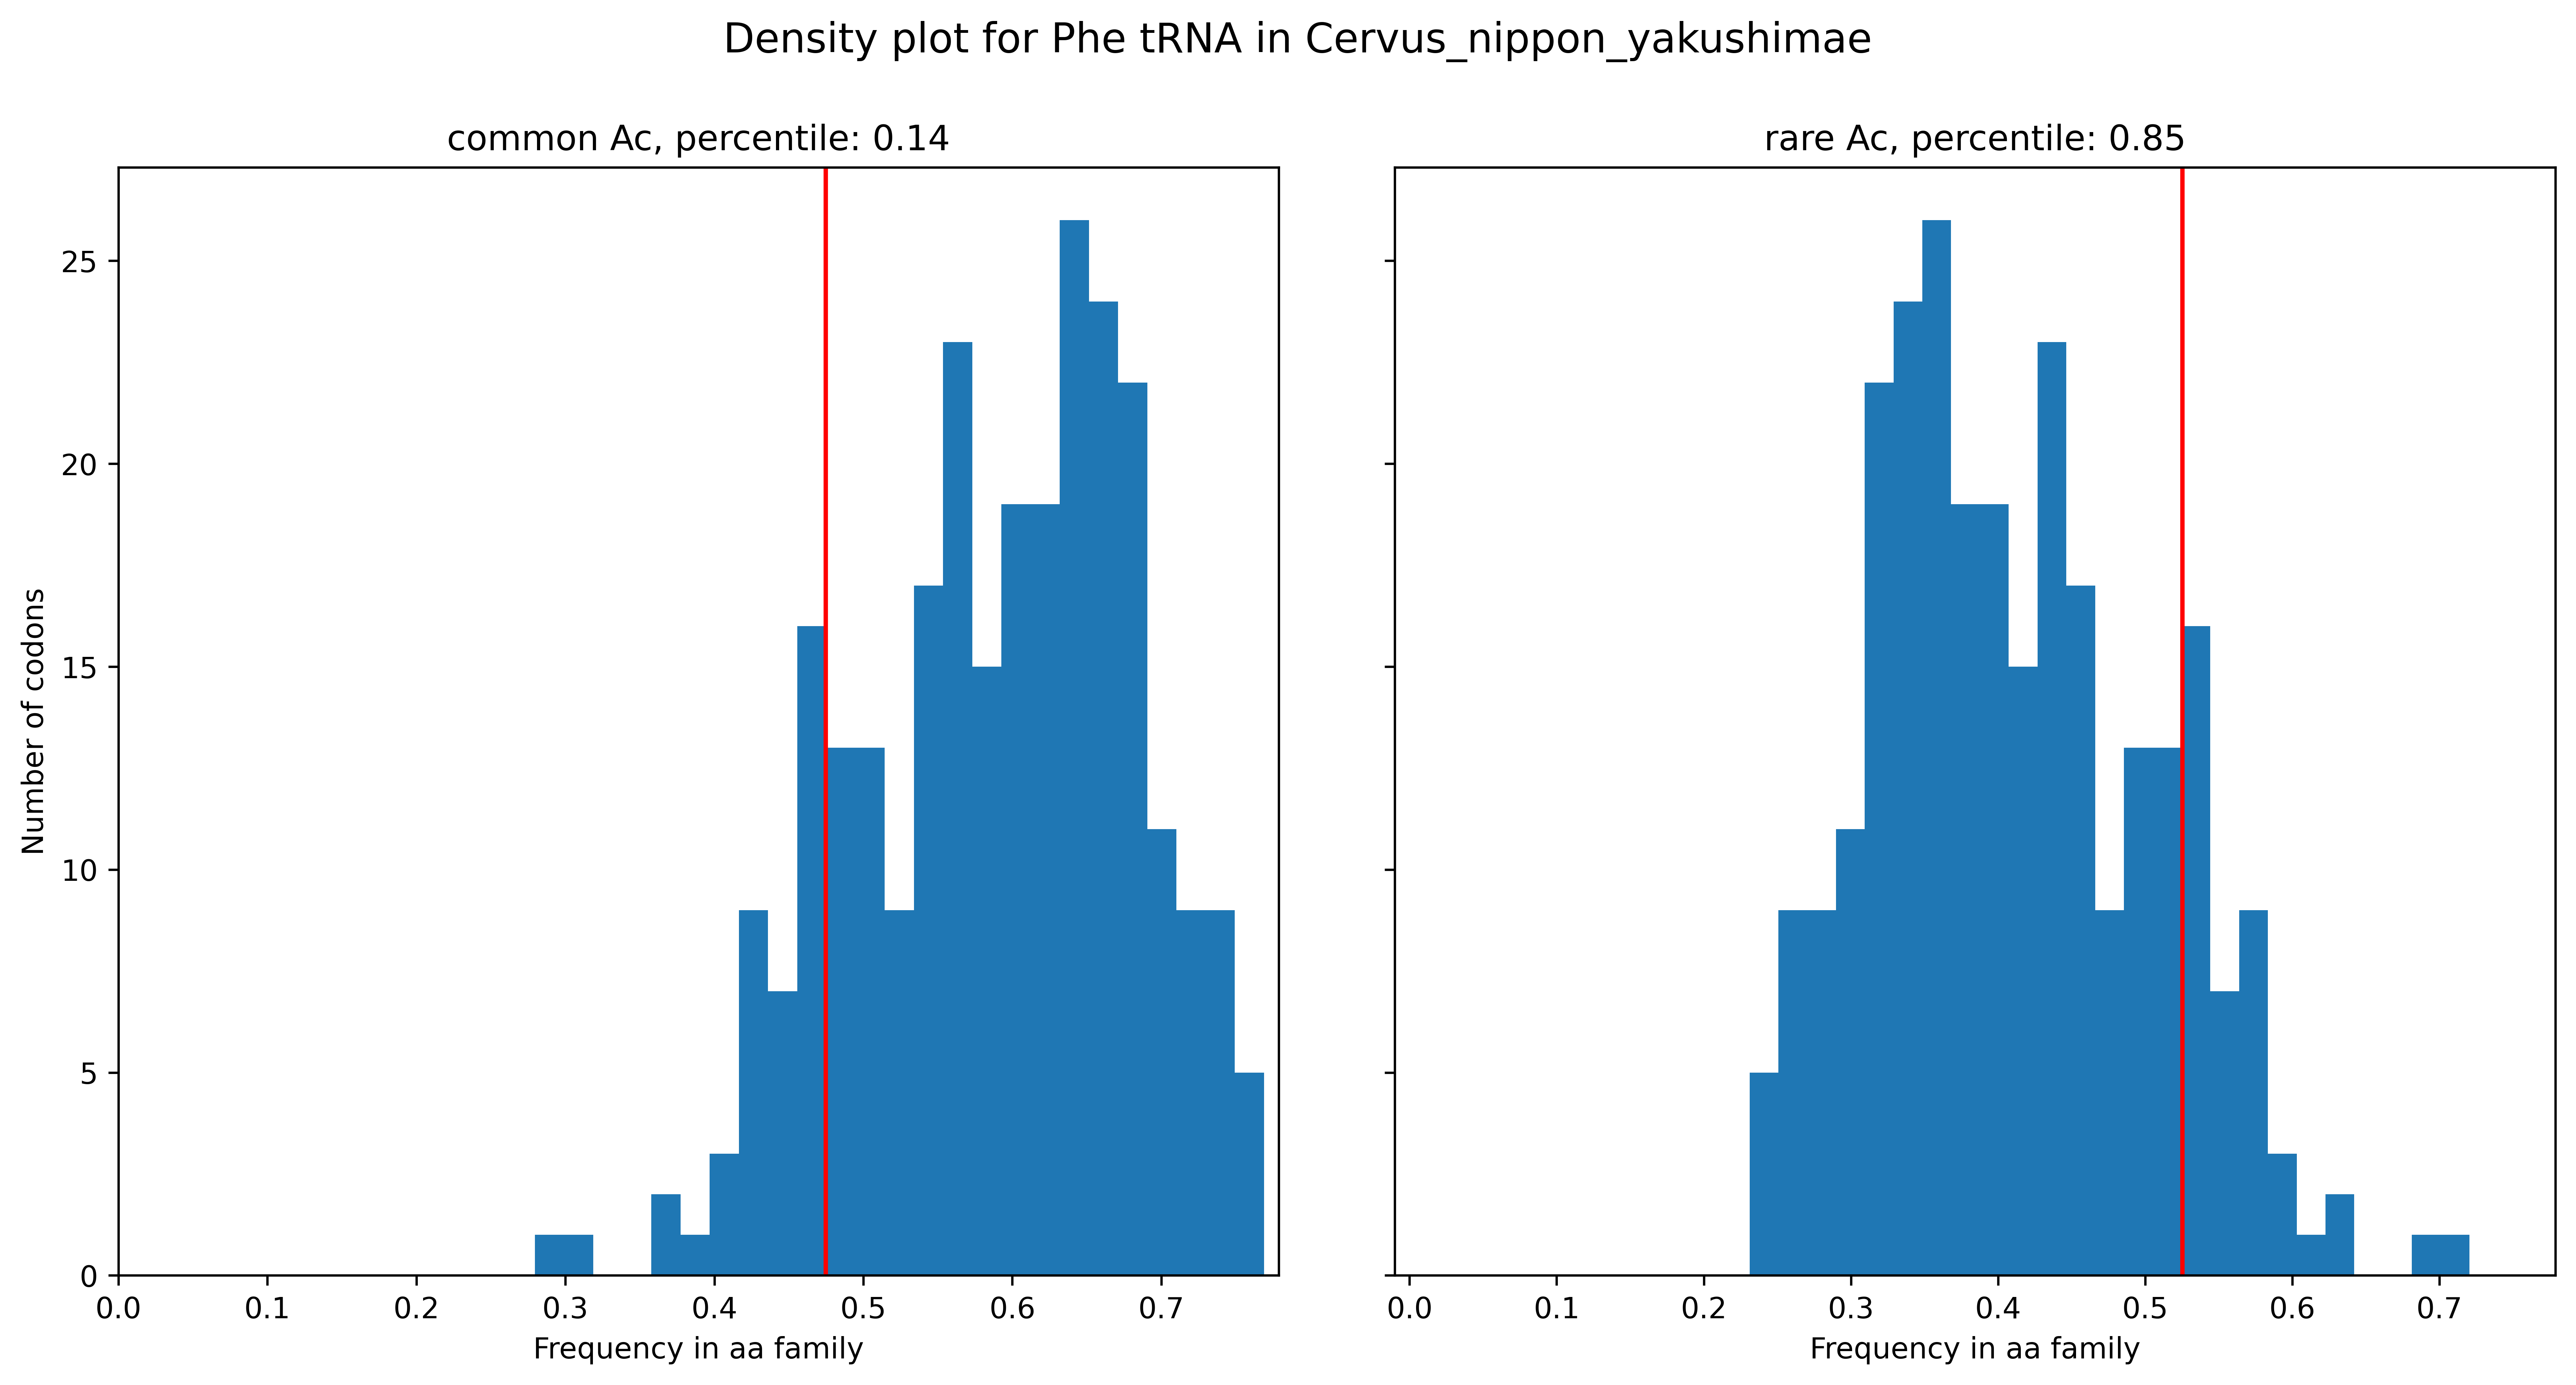

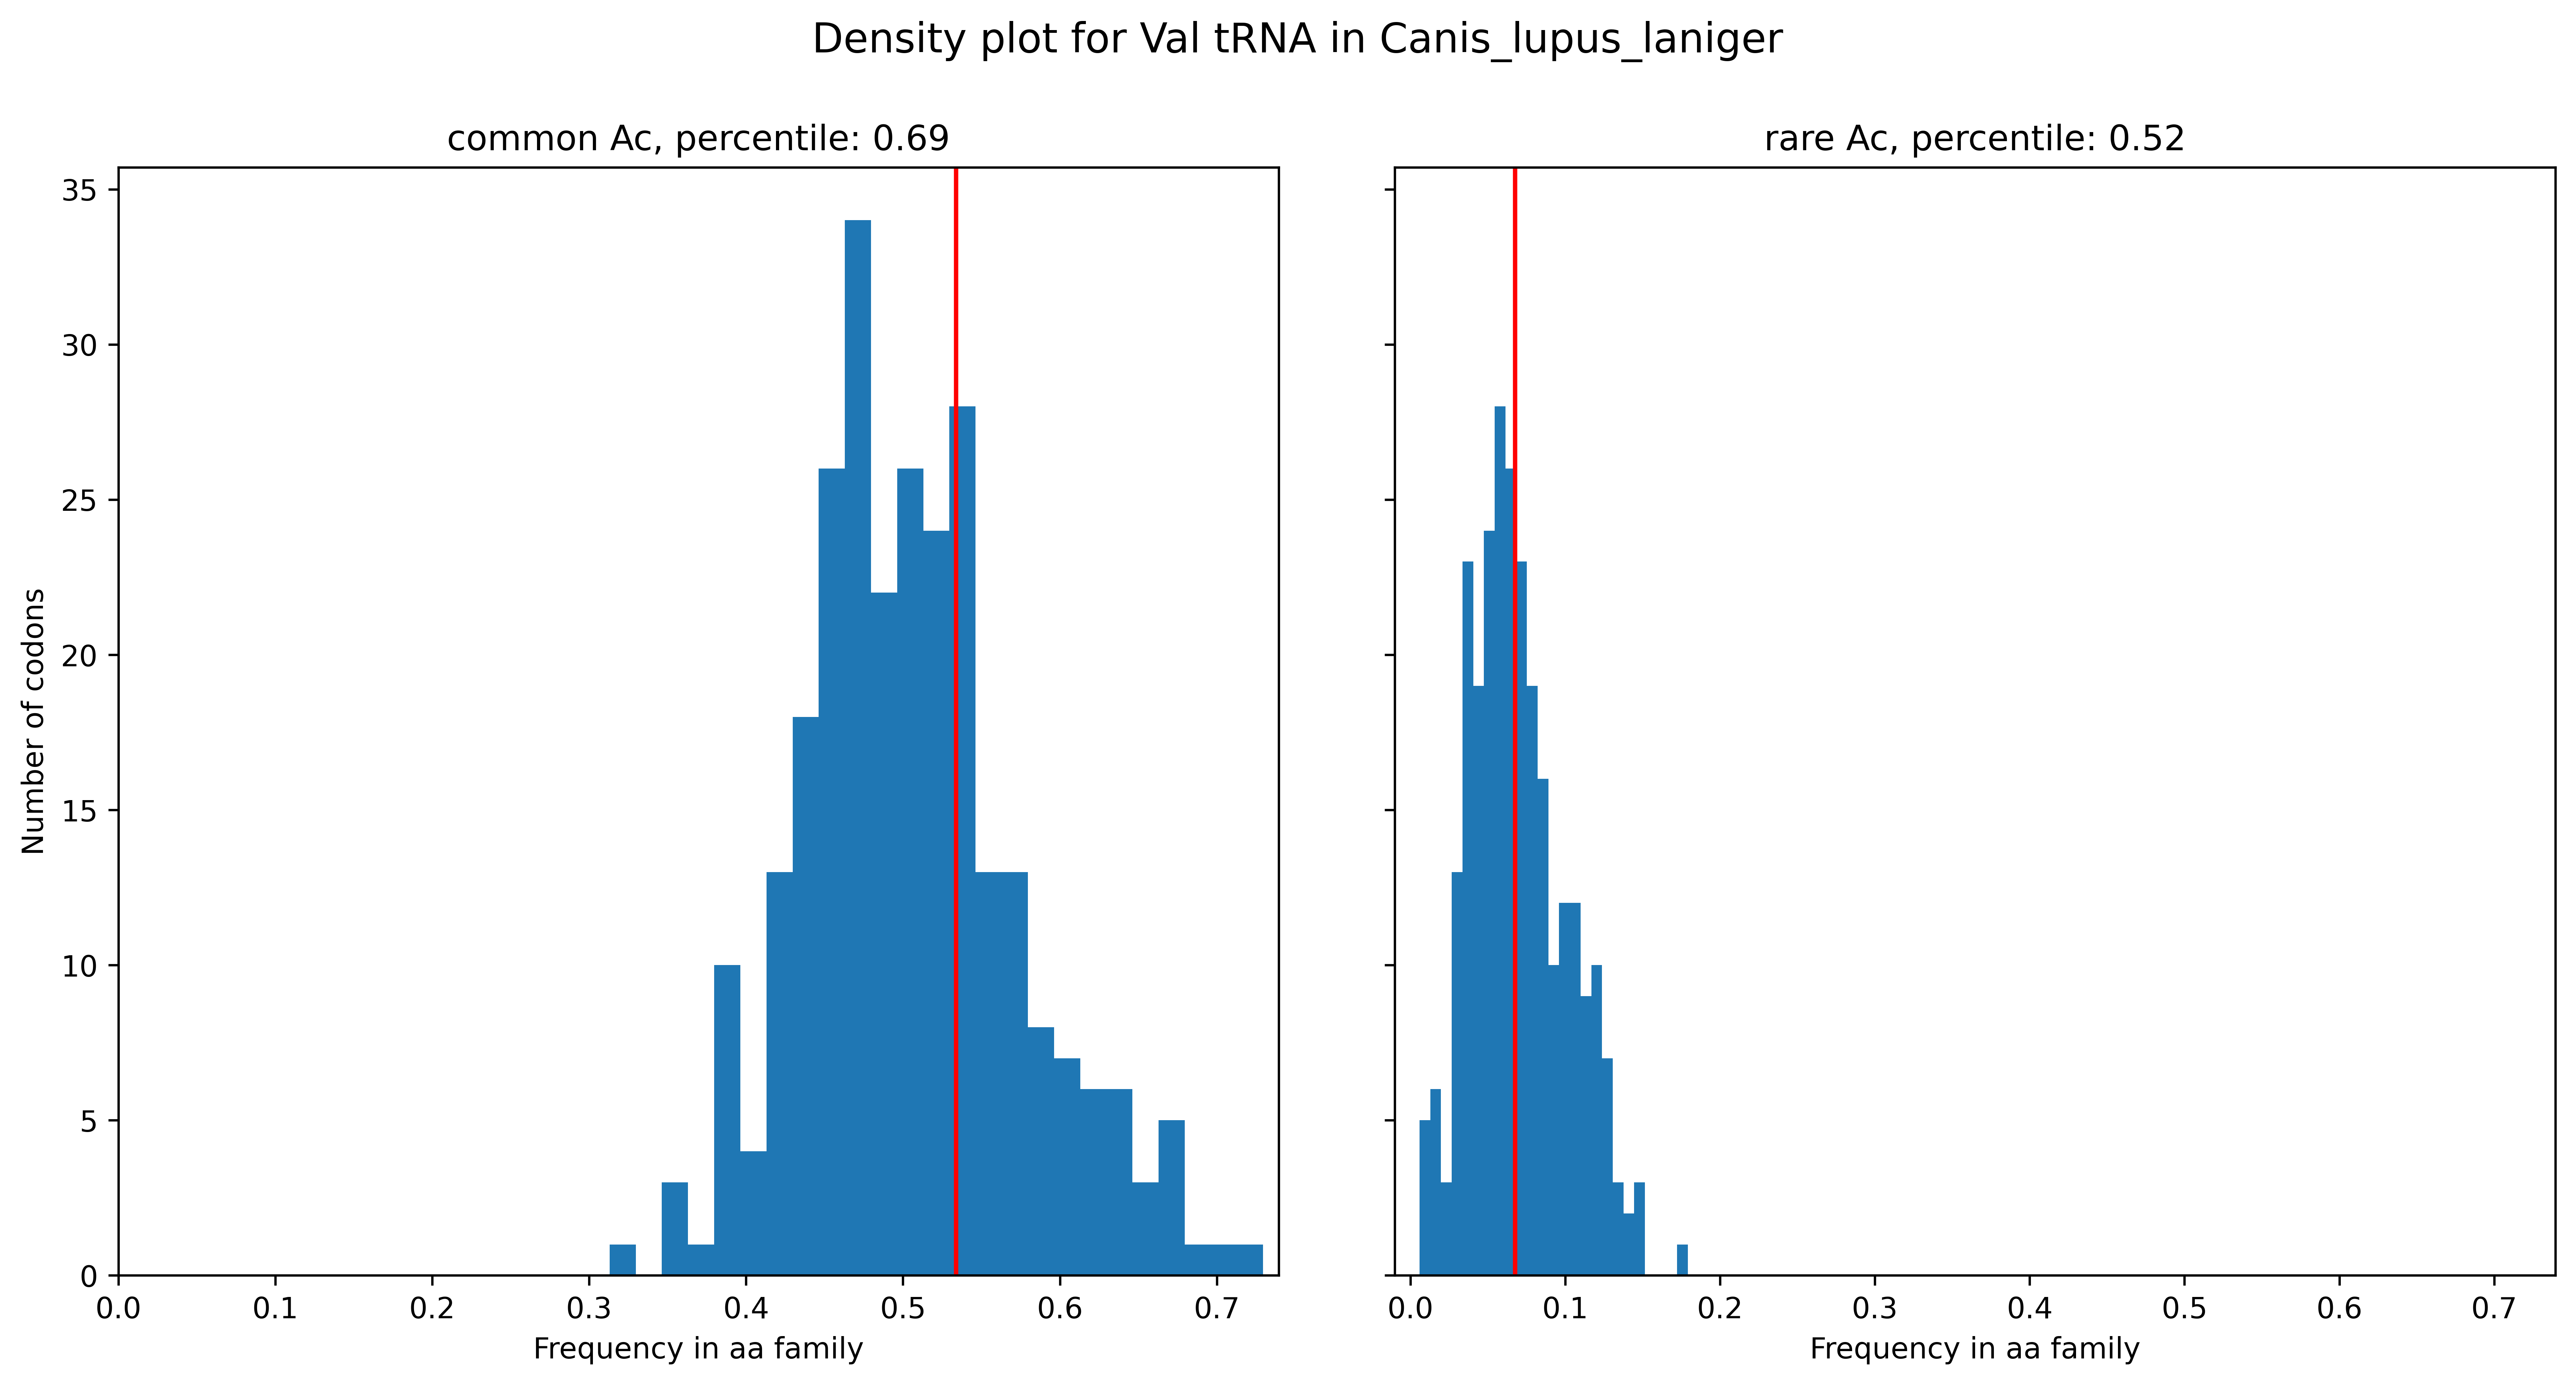

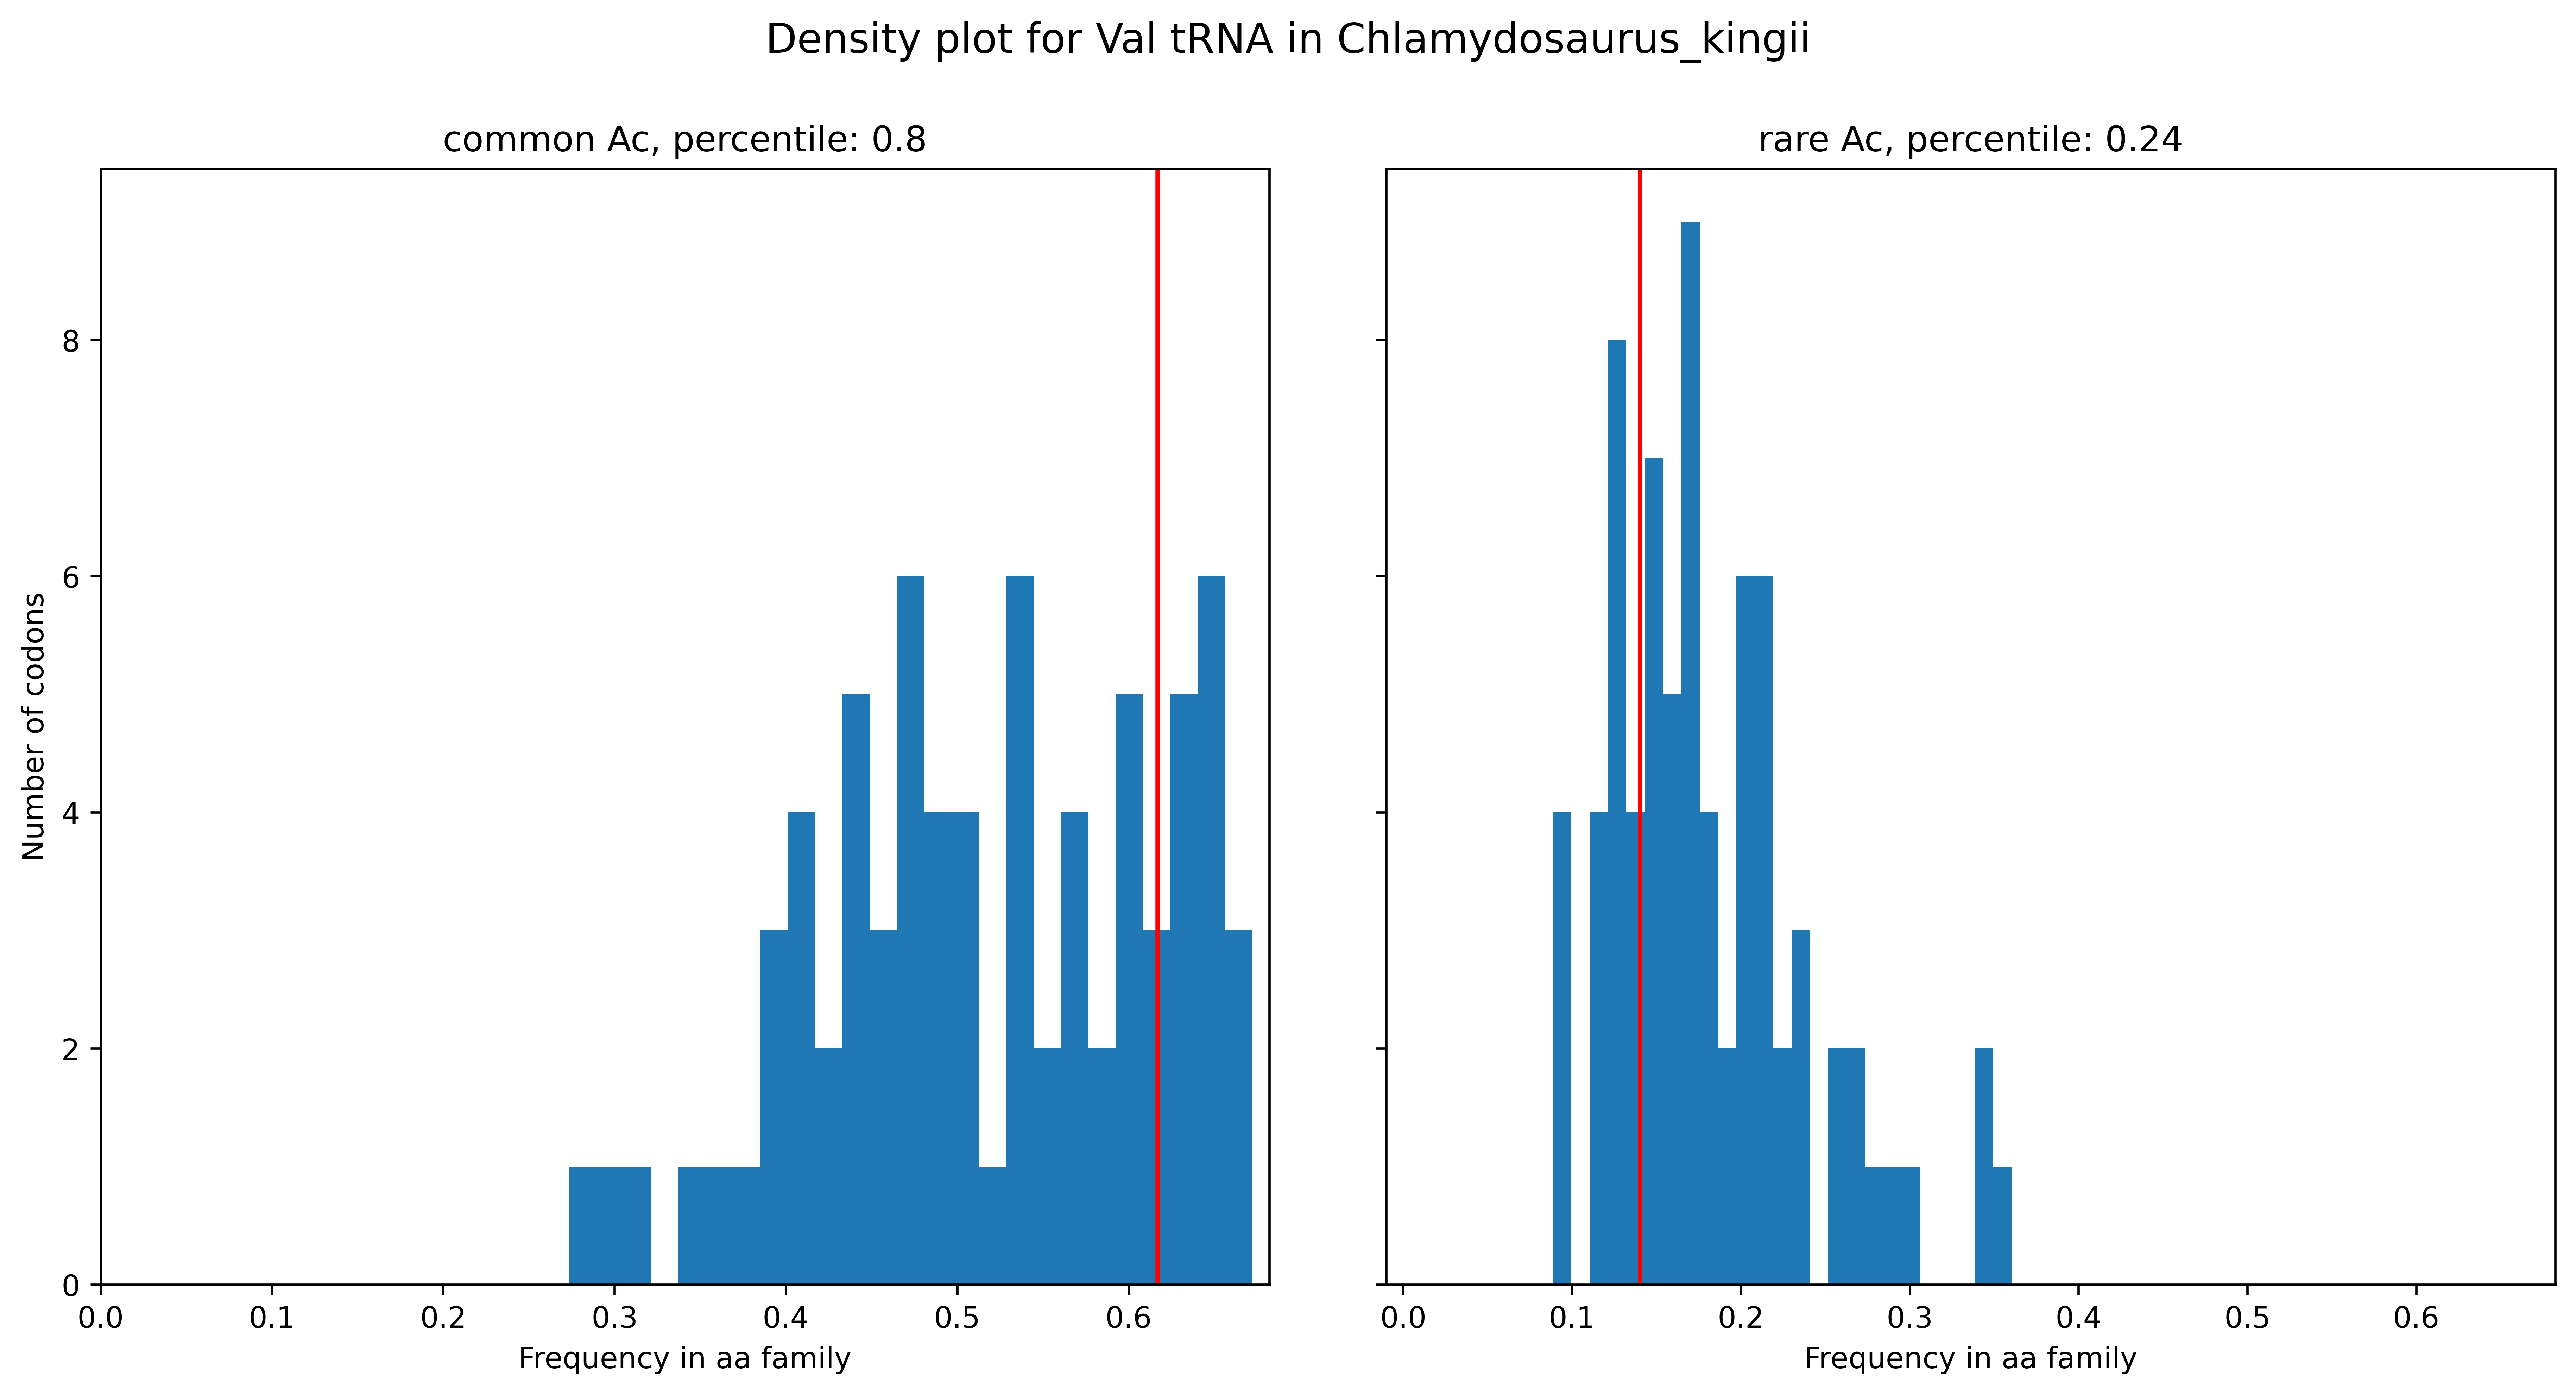

In [416]:
# super_exp = {}
for species in atypical_ac_species_dict:
    if species == 'Ciona_intestinalis' or species in super_exp: 
        continue

    aa = atypical_ac_species_dict[species][0][:-3]
    ac = atypical_ac_species_dict[species][1]
    ac = str(Seq(ac).reverse_complement())
    rare_ac = ac
    common_ac = str(Seq(cognate_acs[f'{aa}_Ac']).reverse_complement())

    
    # if rare_ac not in aa_dict[aa]: 
    #     super_exp[species] = [rare_ac, aa]

    common_freqs = []
    rare_freqs = []
    relative_class = table.loc[table.Species==species, 'Class'].values[0]
    relative_table = table.loc[table.Class==relative_class]  # [table.Species.isin(exp_family_dic[species])]

    for relative in relative_table.Species:
        codon_aa_number = relative_table.loc[relative_table.Species==relative, aa].values[0]

        rare_codon_number = relative_table.loc[relative_table.Species==relative, f'{rare_ac}_12'].values[0]
        rare_codon_freq = rare_codon_number / codon_aa_number
        if relative == species:
            rare_exp_freq = rare_codon_freq
        rare_freqs.append(rare_codon_freq)

        common_codon_number = relative_table.loc[relative_table.Species==relative, f'{common_ac}_12'].values[0]
        common_codon_freq = common_codon_number / codon_aa_number
        if relative == species:
            common_exp_freq = common_codon_freq
        common_freqs.append(common_codon_freq)

    rare_percentile = round(sorted(rare_freqs).index(rare_exp_freq) / len(rare_freqs), 2)
    common_percentile = round(sorted(common_freqs).index(common_exp_freq) / len(common_freqs), 2)


    fig, ax = plt.subplots(1,2, figsize=(15,7), sharey=True, dpi=600)
    ax = ax.ravel()
    bin_divider=6
    xlim = max(common_freqs+rare_freqs) + 0.01
    ax[0].hist(common_freqs, bins=25)
    ax[0].set_xlabel('Frequency in aa family')
    ax[0].set_ylabel('Number of codons')
    ax[0].set_title(f'common Ac, percentile: {common_percentile}')
    ax[0].axvline(x=common_exp_freq, c='r')
    ax[0].set_xlim([0,xlim])

    ax[1].hist(rare_freqs, bins=25) # 
    ax[1].set_xlabel('Frequency in aa family')
    # ax[1].set_ylabel('Number of codons')
    ax[1].set_title(f'rare Ac, percentile: {rare_percentile}')
    ax[1].axvline(x=rare_exp_freq, c='r')
    ax[1].set_xlim([-0.01, xlim])
    fig.suptitle(f'Density plot for {aa} tRNA in {species}', fontsize=14)
    fig.subplots_adjust(wspace=0.1)
    fig.patch.set_facecolor('white')
    plt.show()
    # print(f'AA: {aa},\trare_ac: {rare_ac},\t common_ac: {common_ac} \tin {species}\t{aa_dict[aa]}')
# print(super_exp)

In [21]:
# species which have Ac out of its AA codon fam
super_exp = {'Phocoena_phocoena': ['TGA', 'Arg'],    # 'Cervus_elaphus': ['CAA', 'Arg'] has normal Ac
 'Physeter_catodon': ['TCG', 'Cys'],                # 'Pteropus_scapulatus': ['GCA', 'Ser1'] as well
 'Platanista_minor': ['TCG', 'Cys'],
 'Cuon_alpinus': ['GAT', 'Glu'],
 'Rusa_unicolor_swinhoei': ['CCC', 'His']}
table.loc[:,'Species':'Species'].join(table.loc[table.Species.isin(super_exp), 'Ala_Ac':'Val_Ac'], how='right')

Species Ala_Ac Arg_Ac Asn_Ac Asp_Ac Cys_Ac Gln_Ac Glu_Ac  \
274            Cuon_alpinus    TGC    TCG    GTT    GTC    GCA    TTG    ATC   
756       Phocoena_phocoena    TGC    TCA    GTT    GTC    GCA    TTG    TTC   
760        Physeter_catodon    TGC    TCG    GTT    GTC    CGA    TTG    TTC   
766        Platanista_minor    TGC    TCG    GTT    GTC    CGA    TTG    TTC   
857  Rusa_unicolor_swinhoei    TGC    TCG    GTT    GTC    GCA    TTG    TTC   

    Gly_Ac His_Ac  ... Lys_Ac Met_Ac Phe_Ac Pro_Ac Ser1_Ac Ser2_Ac Thr_Ac  \
274    TCC    GTG  ...    TTT    CAT    GAA    TGG     GCT     TGA    TGT   
756    TCC    GTG  ...    TTT    CAT    GAA    TGG     GCT     TGA    TGT   
760    TCC    GTG  ...    TTT    CAT    GAA    TGG     GCT     TGA    TGT   
766    TCC    GTG  ...    TTT    CAT    GAA    TGG     GCT     TGA    TGT   
857    TCC    GGG  ...    TTT    CAT    GAA    TGG     GCT     TGA    TGT   

    Trp_Ac Tyr_Ac Val_Ac  
274    TCA    GTA    TAC  
756    TCA    GTA    TAC  
760    TCA    GTA    TAC  
766    TCA    GTA    TAC  
857    TCA    GTA    TAC  

[5 rows x 23 columns]

## GLM

### Deriving the matrix

In [21]:
ceph = ['Asymmetron_lucayanum', 'Ciona_intestinalis', 'Epigonichthys_maldivensis', 'Asymmetron_inferum']
MS[MS.Species.isin(ceph)]

Species       A_T       A_G       A_C       T_A  \
73        Asymmetron_lucayanum  0.006793  0.100179  0.011014  0.017491   
325  Epigonichthys_maldivensis  0.008801  0.155012  0.018293  0.006421   

          T_G       T_C       G_A       G_T       G_C       C_A       C_T  \
73   0.006192  0.097882  0.555716  0.011556  0.041340  0.037114  0.112095   
325  0.000000  0.175807  0.118449  0.010900  0.010978  0.023743  0.432212   

          C_G  
73   0.002628  
325  0.039385

In [22]:
substitutions = ['A>T', 'A>G', 'A>C', 'T>A', 'T>G', 'T>C', 'G>A', 'G>T', 'G>C', 'C>A', 'C>T', 'C>G']
matrix_cols = ['Species', 'Codon', 'CodonUsage', 'TrnaGe', 'AAUsage', 'DummyCognate', 'DummyMutSpecMatch'] + substitutions    # , 'DummyInlineWithMS'
# matrix = {col:[] for col in matrix_cols}
matrix_list = []
for species in tqdm(table.Species):
    if species in ceph:
        continue
    species_table = table[table.Species==species]
    # cognate_sp = cognate_df.loc[cognate_df.Species==species]
#     if species_table.loc[:, substitutions[0]].values[0] is pd.notna:
    ms_sp = list(species_table.loc[:,substitutions].values[0])
    for codon in CODONS:
        matrix_list_c = [species, codon]        
        aa = codon_aa_dict[codon]
        if aa == 'Xaa':
            continue
        variables = [f'{codon}_12', f'{aa}_Ge',  aa]
        values_by_variables = list(species_table.loc[:,variables].values[0])
        matrix_list_c += values_by_variables # add 'CodonUsage', 'TrnaGe', 'AAUsage'
        
        ac = table.loc[table.Species==species, f'{aa}_Ac'].values[0]
        if ac is not pd.NA:
            ac = str(Seq(ac).reverse_complement())  # Нужно перевернуть Ac, чтобы соответсвовал CU
            dum_cognate = 1 if codon == ac else 0       # dum_cognate = cognate_sp.loc[:,f'{aa}_cognate'].values[0]
        else:
            dum_cognate = 0
        matrix_list_c.append(dum_cognate)

        dum_ms_match = 1 if codon[2] in ['A', 'C'] else 0
        matrix_list_c.append(dum_ms_match)

        matrix_list_c += ms_sp
        matrix_list.append(matrix_list_c)

  0%|          | 0/1025 [00:00<?, ?it/s]

In [24]:
the_matrix = pd.DataFrame(data=matrix_list, columns=matrix_cols).convert_dtypes()
the_matrix = the_matrix.loc[~the_matrix.Species.isin(unverified_outliers)]

class_list = []
for species in tqdm(the_matrix.Species.unique()):
    row_number = 60
    cl = table.loc[table.Species==species, 'Class'].values[0]
    class_list += [cl for i in range(row_number)]
the_matrix['Class'] = class_list
cols = the_matrix.columns.tolist()
the_matrix = the_matrix.loc[:,cols[:2]+cols[-1:]+cols[2:-1]]

the_matrix = the_matrix.dropna(subset='TrnaGe')

the_matrix.loc[:,'TrnaGe'] = the_matrix.loc[:,'TrnaGe'] * -1
the_matrix = the_matrix.loc[~the_matrix.Species.isin(ceph)] #  Выброс по Gibbs energy

  0%|          | 0/1013 [00:00<?, ?it/s]

In [25]:
matrix_with_ms = the_matrix.drop(columns='DummyMutSpecMatch').dropna(subset=substitutions)
matrix_no_ms = the_matrix.drop(columns=substitutions)
matrix_no_ms

Species Codon           Class  CodonUsage  TrnaGe  AAUsage  \
0      Abalistes_stellaris   AAA  Actinopterygii          64    21.5       71   
1      Abalistes_stellaris   AAC  Actinopterygii          81    19.6      120   
2      Abalistes_stellaris   AAG  Actinopterygii           7    21.5       71   
3      Abalistes_stellaris   AAT  Actinopterygii          39    19.6      120   
4      Abalistes_stellaris   ACA  Actinopterygii         124    26.6      307   
...                    ...   ...             ...         ...     ...      ...   
61255           Zeus_faber   TGT  Actinopterygii           9    16.1       23   
61256           Zeus_faber   TTA  Actinopterygii         143    20.0      156   
61257           Zeus_faber   TTC  Actinopterygii          75    10.0      217   
61258           Zeus_faber   TTG  Actinopterygii          13    20.0      156   
61259           Zeus_faber   TTT  Actinopterygii         142    10.0      217   

       DummyCognate  DummyMutSpecMatch  
0                 1                  1  
1                 1                  1  
2                 0                  0  
3                 0                  0  
4                 1                  1  
...             ...                ...  
61255             0                  0  
61256             1                  1  
61257             1                  1  
61258             0                  0  
61259             0                  0  

[60734 rows x 8 columns]

In [88]:
matrix_with_ms

Species Codon           Class  CodonUsage  TrnaGe  \
180    Abudefduf_vaigiensis   AAA  Actinopterygii          77    19.1   
181    Abudefduf_vaigiensis   AAC  Actinopterygii          85    22.1   
182    Abudefduf_vaigiensis   AAG  Actinopterygii           0    19.1   
183    Abudefduf_vaigiensis   AAT  Actinopterygii          32    22.1   
184    Abudefduf_vaigiensis   ACA  Actinopterygii         106    20.0   
...                     ...   ...             ...         ...     ...   
61255            Zeus_faber   TGT  Actinopterygii           9    16.1   
61256            Zeus_faber   TTA  Actinopterygii         143    20.0   
61257            Zeus_faber   TTC  Actinopterygii          75    10.0   
61258            Zeus_faber   TTG  Actinopterygii          13    20.0   
61259            Zeus_faber   TTT  Actinopterygii         142    10.0   

       AAUsage  DummyCognate       A>T       A>G       A>C       T>A  \
180         77             1       0.0  0.063498  0.021166  0.010499   
181        117             1       0.0  0.063498  0.021166  0.010499   
182         77             0       0.0  0.063498  0.021166  0.010499   
183        117             0       0.0  0.063498  0.021166  0.010499   
184        295             1       0.0  0.063498  0.021166  0.010499   
...        ...           ...       ...       ...       ...       ...   
61255       23             0  0.011301  0.090411  0.067808       0.0   
61256      156             1  0.011301  0.090411  0.067808       0.0   
61257      217             1  0.011301  0.090411  0.067808       0.0   
61258      156             0  0.011301  0.090411  0.067808       0.0   
61259      217             0  0.011301  0.090411  0.067808       0.0   

            T>G       T>C       G>A       G>T       G>C       C>A       C>T  \
180    0.010499  0.283484  0.424866  0.030348  0.060695  0.012659  0.082285   
181    0.010499  0.283484  0.424866  0.030348  0.060695  0.012659  0.082285   
182    0.010499  0.283484  0.424866  0.030348  0.060695  0.012659  0.082285   
183    0.010499  0.283484  0.424866  0.030348  0.060695  0.012659  0.082285   
184    0.010499  0.283484  0.424866  0.030348  0.060695  0.012659  0.082285   
...         ...       ...       ...       ...       ...       ...       ...   
61255  0.035788  0.107363  0.252069  0.084023  0.084023  0.076347  0.190867   
61256  0.035788  0.107363  0.252069  0.084023  0.084023  0.076347  0.190867   
61257  0.035788  0.107363  0.252069  0.084023  0.084023  0.076347  0.190867   
61258  0.035788  0.107363  0.252069  0.084023  0.084023  0.076347  0.190867   
61259  0.035788  0.107363  0.252069  0.084023  0.084023  0.076347  0.190867   

       C>G  
180    0.0  
181    0.0  
182    0.0  
183    0.0  
184    0.0  
...    ...  
61255  0.0  
61256  0.0  
61257  0.0  
61258  0.0  
61259  0.0  

[16674 rows x 19 columns]

In [26]:
def data_converter(matrix): # for some reason numeric df doesn't convert into numeric array
    for col in matrix.loc[:,'CodonUsage':].columns:
        matrix[col] = np.array(matrix[col], dtype=float)

data_converter(matrix_with_ms)
data_converter(matrix_no_ms)

### Modeling

In [11]:
def glm(matrix, mode):
    glm_list = []

    glm_cols = [None, 'Const', 'Const_pv']
    for var in matrix.columns[4:]:
        glm_cols.append(var)
        glm_cols.append(f'{var}_pv')
        
    if mode == 'Species':
        glm_cols[0] = 'Species'
    else: 
        glm_cols[0] = 'Codon'

    for observation in matrix[mode].unique():
        glm_list_sp = [observation]
        matrix_sp = matrix.loc[matrix[mode]==observation]

        endog = matrix_sp.CodonUsage
        exog = sm.add_constant(matrix_sp.loc[:,'TrnaGe':])
        model = sm.GLM(endog, exog, family=sm.families.Poisson()).fit()
        parameters = model.params
        pvals = model.pvalues

        if len(parameters)*2 == len(glm_cols)-1:           # add nan value if a constant didn't appear 
            for param, pval in zip(parameters, pvals): # to matching values and number of columns
                glm_list_sp.append(param)           
                glm_list_sp.append(pval)
        else:
            glm_list_sp.append(np.nan)
            glm_list_sp.append(np.nan)
            for param, pval in zip(parameters, pvals):
                glm_list_sp.append(param)
                glm_list_sp.append(pval)

        glm_list.append(glm_list_sp)
    
    glm_df = pd.DataFrame(data=glm_list, columns=glm_cols)
    return glm_df

def result_stats(glm_result, name=None, excel=False):
    coeffs = glm_result.loc[:, 'Const'::2].describe()
    pvals = glm_result.iloc[:, 2::2].describe()
    if excel == True:
        coeffs.drop('count', axis=0).to_excel(f'GLM_Results/{name}.xlsx')
        pvals.drop('count', axis=0).to_excel(f'GLM_Results/{name}_pv.xlsx')
    print(coeffs)
    print(pvals)  # np.log(glm_dms_sp.iloc[:, 2::2])


In [27]:
glm_dms_sp = glm(matrix_no_ms, 'Species')
glm_ms_sp =  glm(matrix_with_ms, 'Species')
glm_dms_c = glm(matrix_no_ms, 'Codon')
glm_ms_c =  glm(matrix_with_ms, 'Codon')

In [ ]:
mode = 'Species'
# glm_dms_sp.to_csv(f'..\\derived\GLM_{mode}_DummyMS.csv', index=False)

result_stats(glm_dms_sp) # , name='glm_dms_sp', excel=True
# (glm_dms_sp.DummyMutSpecMatch_pv < 0.01).sum() / 1021

             Const       TrnaGe      AAUsage  DummyCognate  DummyMutSpecMatch
count  1017.000000  1017.000000  1017.000000   1017.000000        1017.000000
mean      2.739577     0.006783     0.003579      0.229317           0.810273
std       0.401805     0.018306     0.014256      0.192035           0.341121
min      -1.676263    -0.068690     0.002234     -0.352856          -0.944406
25%       2.510267    -0.004203     0.002810      0.104142           0.589063
50%       2.768029     0.007366     0.003044      0.234233           0.802843
75%       2.982092     0.017900     0.003300      0.363963           1.018555
max       3.922566     0.082260     0.457163      0.767381           1.945932
            Const_pv     TrnaGe_pv     AAUsage_pv  DummyCognate_pv  \
count   1.017000e+03  1.017000e+03   1.017000e+03     1.017000e+03   
mean    2.105160e-06  1.631960e-01   8.544895e-09     6.931279e-02   
std     6.713447e-05  2.697332e-01   2.725004e-07     1.882087e-01   
min     0.000000e+

In [354]:
matrix_no_ms.loc[matrix_no_ms.Species=='Mus_musculus']
matrix_no_ms.loc[matrix_no_ms.Codon=='ATG']

Species Codon           Class  CodonUsage  TrnaGe   
12        Abalistes_stellaris   ATG  Actinopterygii        43.0   -10.0  \
72             Ablennes_hians   ATG  Actinopterygii        29.0   -12.6   
132          Abronia_graminea   ATG        Reptilia        29.0   -12.7   
192      Abudefduf_vaigiensis   ATG  Actinopterygii        56.0   -11.7   
252    Acanthaluteres_brownii   ATG  Actinopterygii       104.0   -13.2   
...                       ...   ...             ...         ...     ...   
61212       Zaglossus_bruijni   ATG        Mammalia        46.0   -14.9   
61272  Zalophus_californianus   ATG        Mammalia        48.0   -12.3   
61332        Zanclus_cornutus   ATG  Actinopterygii        73.0   -17.7   
61392    Zebrasoma_flavescens   ATG  Actinopterygii        52.0   -13.5   
61452              Zeus_faber   ATG  Actinopterygii        40.0   -10.0   

       AAUsage  DummyCognate  DummyMutSpecMatch  
12       149.0           1.0                0.0  
72       152.0           1.0                0.0  
132      216.0           1.0                0.0  
192      158.0           1.0                0.0  
252      154.0           1.0                0.0  
...        ...           ...                ...  
61212    194.0           1.0                0.0  
61272    245.0           1.0                0.0  
61332    141.0           1.0                0.0  
61392    148.0           1.0                0.0  
61452    167.0           1.0                0.0  

[1025 rows x 8 columns]

In [ ]:
# glm_ms_sp.to_csv(f'..\\derived\GLM_{mode}_RealMS.csv', index=False)

result_stats(glm_ms_sp) # , name='glm_ms_sp', excel=True
# glm_ms_sp

       Const      TrnaGe     AAUsage  DummyCognate         A>T         A>G   
count    0.0  279.000000  279.000000    279.000000  279.000000  279.000000  \
mean     NaN    0.006637    0.003353      0.756345    0.076146    0.469598   
std      NaN    0.015542    0.000317      0.220792    0.139239    0.590978   
min      NaN   -0.033583    0.002748     -0.115527    0.000000    0.000000   
25%      NaN   -0.002567    0.003128      0.585327    0.000000    0.127673   
50%      NaN    0.006851    0.003348      0.776390    0.033482    0.275442   
75%      NaN    0.015648    0.003515      0.920374    0.071787    0.542879   
max      NaN    0.072067    0.005115      1.286284    1.271132    4.358108   

              A>C         T>A         T>G         T>C         G>A         G>T   
count  279.000000  279.000000  279.000000  279.000000  279.000000  279.000000  \
mean     0.085571    0.217876    0.079809    1.323950    4.332555    0.222315   
std      0.156842    0.296200    0.246651    0.923864 

In [ ]:
mode = 'Codon'
glm_dms_c.to_csv(f'..\\derived\GLM_{mode}_DummyMS.csv', index=False)
result_stats(glm_dms_c)

           Const     TrnaGe    AAUsage  DummyCognate  DummyMutSpecMatch
count  30.000000  60.000000  60.000000     60.000000          60.000000
mean    1.712962  -0.002908   0.009417      0.789650           0.878033
std     1.866633   0.020278   0.012297      3.209101           3.109602
min    -3.674865  -0.059035  -0.011796     -0.419945         -20.229965
25%     0.470445  -0.016452   0.001913      0.000000           0.000000
50%     2.120209  -0.001767   0.006973      0.000000           0.000000
75%     2.845585   0.010287   0.013498      0.057877           2.477134
max     4.295101   0.039029   0.072030     24.388175           4.238972
            Const_pv      TrnaGe_pv     AAUsage_pv  DummyCognate_pv   
count   3.000000e+01   6.000000e+01   6.000000e+01        28.000000  \
mean    1.433946e-03   5.868400e-02   3.005642e-02         0.308026   
std     4.549095e-03   1.947662e-01   1.525778e-01         0.373154   
min     0.000000e+00  1.011339e-305   0.000000e+00         0.000000 

In [ ]:
glm_ms_c.to_csv(f'..\\derived\GLM_{mode}_RealMS.csv', index=False)
# glm_ms_c = pd.read_csv('..\\derived\GLM_RealMS.csv').copy()
print(glm_ms_c.loc[:, 'Const'::2].describe())
glm_ms_c.iloc[:, 2::2].mean()

           Const     TrnaGe    AAUsage  DummyCognate        A>T        A>G   
count  40.000000  60.000000  60.000000  6.000000e+01  60.000000  60.000000  \
mean    2.192791  -0.001860   0.009088  1.012847e+00  -0.096344   0.824704   
std     1.142149   0.012282   0.008957  1.489475e+00   3.166213   2.032680   
min    -1.037688  -0.040544  -0.001834 -1.417898e-14 -10.301977  -2.523987   
25%     1.599073  -0.012076   0.003438 -6.935129e-16  -1.818865  -0.664214   
50%     2.170668   0.000929   0.005815  1.990487e-15   0.312280   0.211900   
75%     3.106436   0.004932   0.012656  2.747403e+00   2.001195   1.723591   
max     4.229148   0.021273   0.044123  4.255561e+00   5.720173   5.624673   

             A>C        T>A        T>G        T>C        G>A        G>T   
count  60.000000  60.000000  60.000000  60.000000  60.000000  60.000000  \
mean    1.363075   0.397948  -0.475432   0.080213   0.050987   0.168864   
std     2.557489   0.801609   2.459280   0.955734   0.523877   0.421404 

Const_pv           0.024831
TrnaGe_pv          0.153607
AAUsage_pv         0.009148
DummyCognate_pv    0.142532
A>T_pv             0.234038
A>G_pv             0.164388
A>C_pv             0.221089
T>A_pv             0.278153
T>G_pv             0.188433
T>C_pv             0.061315
G>A_pv             0.131974
G>T_pv             0.285428
G>C_pv             0.258683
C>A_pv             0.193333
C>T_pv             0.141017
C>G_pv             0.324680
dtype: float64

In [ ]:
# glm by classes and codons
mode = 'Codon'
for cl in the_matrix.Class.unique()[:-1]:
    matrix_cl = matrix_no_ms.loc[matrix_no_ms.Class==cl]
    glm(matrix_cl, mode).to_csv(f'..\\derived\GLM_{mode}_DummyMS_{cl}.csv', index=False)
    matrix_cl = matrix_with_ms.loc[matrix_with_ms.Class==cl]
    glm(matrix_cl, mode).to_csv(f'..\\derived\GLM_{mode}_RealMS_{cl}.csv', index=False)

c:\Soft\Python\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Soft\Python\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Soft\Python\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Soft\Python\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Soft\Python\lib\site-pack

In [ ]:
for cl in the_matrix.Class.unique()[:-1]:
    glm_dms_cl = pd.read_csv(f'..\\derived\GLM_DummyMS_{cl}.csv')
    glm_ms_cl = pd.read_csv(f'..\\derived\GLM_RealMS_{cl}.csv')
    print(cl)
    print('Dummy MS')
    print(glm_dms_cl.loc[:, 'Const'::2].mean())
    print(glm_dms_cl.iloc[:, 2::2].mean())
    print('\n')
    print('Real MS')
    print(glm_ms_cl.loc[:, 'Const'::2].mean())
    print(glm_ms_cl.iloc[:, 2::2].mean())
    print('\n')

Actinopterygii
Dummy MS
Const                2.115854
TrnaGe              -0.002451
AAUsage              0.007165
DummyCognate         0.705200
DummyMutSpecMatch    1.125754
dtype: float64
Const_pv                0.005261
TrnaGe_pv               0.099396
AAUsage_pv              0.059727
DummyCognate_pv         0.058507
DummyMutSpecMatch_pv    0.000087
dtype: float64


Real MS
Const           2.419343
TrnaGe         -0.002089
AAUsage         0.006921
DummyCognate    1.223692
A>T            -0.258642
A>G             0.836010
A>C             1.120539
T>A             0.649710
T>G            -0.672052
T>C             0.091292
G>A            -0.003362
G>T             0.571401
G>C             0.356209
C>A            -0.132151
C>T             0.159329
C>G             0.037661
dtype: float64
Const_pv           0.143165
TrnaGe_pv          0.221559
AAUsage_pv         0.096952
DummyCognate_pv    0.150963
A>T_pv             0.306090
A>G_pv             0.176236
A>C_pv             0.351268
T>A_pv    

#### No Dummies

In [ ]:
no_dummy_matrix

#### Scaled matrix

In [30]:
scaled_matrix = the_matrix.copy()
scaler = MinMaxScaler()    # StandardScaler() не работает
scaled_matrix[['CodonUsage', 'TrnaGe', 'AAUsage']] = scaler.fit_transform(scaled_matrix[['CodonUsage', 'TrnaGe', 'AAUsage']])
scaled_matrix

Species Codon           Class  CodonUsage    TrnaGe   
0      Abalistes_stellaris   AAA  Actinopterygii    0.160401  0.560472  \
1      Abalistes_stellaris   AAC  Actinopterygii    0.203008  0.504425   
2      Abalistes_stellaris   AAG  Actinopterygii    0.017544  0.560472   
3      Abalistes_stellaris   AAT  Actinopterygii    0.097744  0.504425   
4      Abalistes_stellaris   ACA  Actinopterygii    0.310777  0.710914   
...                    ...   ...             ...         ...       ...   
61255           Zeus_faber   TGT  Actinopterygii    0.022556  0.401180   
61256           Zeus_faber   TTA  Actinopterygii    0.358396  0.516224   
61257           Zeus_faber   TTC  Actinopterygii    0.187970  0.221239   
61258           Zeus_faber   TTG  Actinopterygii    0.032581  0.516224   
61259           Zeus_faber   TTT  Actinopterygii    0.355890  0.221239   

        AAUsage  DummyCognate  DummyMutSpecMatch       A>T       A>G   
0      0.086885             1                  1      <NA>      <NA>  \
1      0.167213             1                  1      <NA>      <NA>   
2      0.086885             0                  0      <NA>      <NA>   
3      0.167213             0                  0      <NA>      <NA>   
4      0.473770             1                  1      <NA>      <NA>   
...         ...           ...                ...       ...       ...   
61255  0.008197             0                  0  0.011301  0.090411   
61256  0.226230             1                  1  0.011301  0.090411   
61257  0.326230             1                  1  0.011301  0.090411   
61258  0.226230             0                  0  0.011301  0.090411   
61259  0.326230             0                  0  0.011301  0.090411   

            A>C   T>A       T>G       T>C       G>A       G>T       G>C   
0          <NA>  <NA>      <NA>      <NA>      <NA>      <NA>      <NA>  \
1          <NA>  <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
2          <NA>  <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
3          <NA>  <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
4          <NA>  <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
...         ...   ...       ...       ...       ...       ...       ...   
61255  0.067808   0.0  0.035788  0.107363  0.252069  0.084023  0.084023   
61256  0.067808   0.0  0.035788  0.107363  0.252069  0.084023  0.084023   
61257  0.067808   0.0  0.035788  0.107363  0.252069  0.084023  0.084023   
61258  0.067808   0.0  0.035788  0.107363  0.252069  0.084023  0.084023   
61259  0.067808   0.0  0.035788  0.107363  0.252069  0.084023  0.084023   

            C>A       C>T   C>G  
0          <NA>      <NA>  <NA>  
1          <NA>      <NA>  <NA>  
2          <NA>      <NA>  <NA>  
3          <NA>      <NA>  <NA>  
4          <NA>      <NA>  <NA>  
...         ...       ...   ...  
61255  0.076347  0.190867   0.0  
61256  0.076347  0.190867   0.0  
61257  0.076347  0.190867   0.0  
61258  0.076347  0.190867   0.0  
61259  0.076347  0.190867   0.0  

[61214 rows x 20 columns]

In [33]:
scaled_matrix_dms = scaled_matrix.drop(columns=substitutions)
data_converter(scaled_matrix_dms)

scale_glm_ms_sp = glm(scaled_matrix_dms, 'Species')
result_stats(scale_glm_ms_sp)

             Const       TrnaGe      AAUsage  DummyCognate  DummyMutSpecMatch
count  1021.000000  1021.000000  1021.000000   1021.000000        1021.000000
mean     -3.169493     0.226377     1.892666      0.228948           0.814826
std       0.341673     0.621722     0.246417      0.191382           0.332503
min      -4.145132    -2.328585     1.362979     -0.352856          -0.944406
25%      -3.377297    -0.146042     1.714296      0.104792           0.595935
50%      -3.144599     0.243717     1.857233      0.233937           0.803289
75%      -2.954694     0.606379     2.012621      0.361709           1.018830
max      -2.056714     2.788626     3.216505      0.767381           1.945932
          Const_pv    TrnaGe_pv   AAUsage_pv  DummyCognate_pv   
count  1021.000000  1021.000000  1021.000000      1021.000000  \
mean      0.055991     0.879863     0.219341         0.773691   
std       0.046353     0.086309     0.044631         0.135027   
min       0.001744     0.568352     0.

#### Simplier MS

In [35]:
ms4 = ['G>A', 'T>C', 'C>T', 'A>G']
matrix_with_ms4 = matrix_with_ms.loc[:,matrix_with_ms.columns[:7].tolist() + ms4]
data_converter(matrix_with_ms4)
# glm_ms4_c = glm(matrix_with_ms4, 'Codon')
glm_ms4_sp = glm(matrix_with_ms4, 'Species')

In [36]:
result_stats(glm_ms4_sp)

       Const      TrnaGe     AAUsage  DummyCognate         G>A         T>C   
count    0.0  279.000000  279.000000    279.000000  279.000000  279.000000  \
mean     NaN    0.006637    0.003353      0.756345    4.504661    1.392054   
std      NaN    0.015542    0.000317      0.220792    0.974443    1.012212   
min      NaN   -0.033583    0.002748     -0.115527    0.000000    0.000000   
25%      NaN   -0.002567    0.003128      0.585327    3.996453    0.657335   
50%      NaN    0.006851    0.003348      0.776390    4.307275    1.094447   
75%      NaN    0.015648    0.003515      0.920374    5.015736    1.858519   
max      NaN    0.072067    0.005115      1.286284    8.005745    6.396642   

              C>T         A>G  
count  279.000000  279.000000  
mean     0.732970    0.501821  
std      0.656312    0.723769  
min      0.000000    0.000000  
25%      0.325361    0.128319  
50%      0.536384    0.283635  
75%      0.873562    0.559550  
max      4.821765    7.968680  
       Co

In [203]:
ms2 = ['G>A', 'T>C']
matrix_with_ms2 = matrix_with_ms.loc[:,matrix_with_ms.columns[:7].tolist() + ms2]
data_converter(matrix_with_ms2)
glm_ms2_c = glm(matrix_with_ms2, 'Codon')

                 Generalized Linear Model Regression Results                  
Dep. Variable:             CodonUsage   No. Observations:                  278
Model:                            GLM   Df Residuals:                      273
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1586.4
Date:                Mon, 29 May 2023   Deviance:                       1407.3
Time:                        16:03:39   Pearson chi2:                 1.40e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9630
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.5026      0.115     30.500   

In [204]:
print(glm_ms2_c.loc[:, 'Const'::2].mean())
print(glm_ms2_c.iloc[:, 2::2].mean())

Const           2.497825
TrnaGe         -0.003925
AAUsage         0.009389
DummyCognate    1.123934
G>A            -0.263731
T>C            -0.342978
dtype: float64
Const_pv           0.022289
TrnaGe_pv          0.110553
AAUsage_pv         0.008805
DummyCognate_pv    0.071198
G>A_pv             0.030939
T>C_pv             0.029813
dtype: float64


#### Qualitative MS for glm

In [117]:
matrix_with_goodms = matrix_with_ms.loc[(matrix_with_ms.loc[:,'A>T':'C>G'] != 0).sum(axis=1) > 8] # Мутспек с > 6 ненулевых значений
data_converter(matrix_with_goodms)
glm_gms_c = glm(matrix_with_goodms, 'Codon')

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_2068\1612518147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix[col] = np.array(matrix[col], dtype=float)
C:\Users\Эльдар\AppData\Local\Temp\ipykernel_2068\1612518147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix[col] = np.array(matrix[col], dtype=float)
C:\Users\Эльдар\AppData\Local\Temp\ipykernel_2068\1612518147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [129]:
print(glm_gms_c.loc[:, 'Const'::2].mean())
print(glm_gms_c.iloc[:, 2::2].mean())
glm_gms_c

Const           1.969281
TrnaGe         -0.003137
AAUsage         0.009892
DummyCognate    1.041906
A>T             0.475559
A>G             0.963663
A>C            -0.140595
T>A             0.399143
T>G            -0.404115
T>C             0.038354
G>A             0.069173
G>T             0.217996
G>C             0.345355
C>A             0.035191
C>T             0.375414
C>G            -0.053750
dtype: float64
Const_pv           0.055328
TrnaGe_pv          0.187438
AAUsage_pv         0.015351
DummyCognate_pv    0.150634
A>T_pv             0.220638
A>G_pv             0.163158
A>C_pv             0.387286
T>A_pv             0.302101
T>G_pv             0.311140
T>C_pv             0.129622
G>A_pv             0.163493
G>T_pv             0.278416
G>C_pv             0.288222
C>A_pv             0.260940
C>T_pv             0.188841
C>G_pv             0.302179
dtype: float64


Codon     Const       Const_pv    TrnaGe     TrnaGe_pv   AAUsage   
0    AAA       NaN            NaN -0.004677  1.485679e-01  0.015878  \
1    AAC       NaN            NaN -0.012743  3.158148e-05  0.008057   
2    AAG  1.316038   9.107297e-05 -0.018243  3.876481e-02  0.006072   
3    AAT  2.993886   1.257531e-89  0.010100  1.100731e-02  0.009131   
4    ACA       NaN            NaN  0.006206  1.664248e-04  0.003019   
5    ACC  2.508713  7.190577e-106 -0.015118  1.459588e-15  0.005425   
6    ACG  1.540569   3.855967e-06 -0.028877  2.329436e-07 -0.000565   
7    ACT  3.632640  1.430255e-135  0.002991  2.359317e-01  0.001909   
8    AGC       NaN            NaN -0.013145  7.688356e-04  0.001854   
9    AGT  1.327157   3.498583e-04 -0.010133  1.691411e-01  0.004251   
10   ATA  3.252247   0.000000e+00 -0.002884  2.178625e-01  0.007215   
11   ATC       NaN            NaN  0.013128  8.649066e-14  0.003908   
12   ATG       NaN            NaN -0.008932  2.362318e-02 -0.001549   
13   ATT  3.407469  2.114366e-240 -0.017412  7.557250e-30  0.004517   
14   CAA       NaN            NaN  0.002090  4.572362e-01  0.013436   
15   CAC       NaN            NaN -0.005734  1.576354e-01  0.016728   
16   CAG  0.617446   6.562910e-02 -0.014935  5.802983e-02  0.015750   
17   CAT  3.109693   6.642292e-39  0.014853  1.369357e-02  0.006776   
18   CCA       NaN            NaN  0.010239  2.645837e-04  0.003158   
19   CCC  0.304363   1.604625e-01 -0.009105  5.034786e-03  0.017141   
20   CCG -0.616045   1.941348e-01 -0.027454  9.883453e-04  0.008457   
21   CCT  3.138525   3.952557e-56 -0.018324  2.965433e-06  0.004024   
22   CGA  2.063829   4.614053e-15  0.003679  3.385552e-01  0.019306   
23   CGC  1.854119   3.494179e-07 -0.001736  7.982531e-01  0.008548   
24   CGG -0.999062   7.733221e-02 -0.028101  8.204917e-03  0.039281   
25   CGT  0.947052   4.727957e-02  0.012615  1.614042e-01  0.024555   
26   CTA       NaN            NaN  0.006611  1.664849e-03  0.001474   
27   CTC  1.833531   6.901802e-64  0.004903  1.267873e-01  0.005803   
28   CTG  1.367991   2.981767e-16 -0.022626  5.468490e-06  0.003232   
29   CTT  4.025896   0.000000e+00 -0.015336  6.816089e-07  0.002162   
30   GAA       NaN            NaN  0.000481  8.893715e-01  0.012298   
31   GAC       NaN            NaN -0.006288  2.035754e-02  0.020398   
32   GAG  0.615319   5.577457e-02 -0.012060  1.211133e-01  0.018258   
33   GAT  2.721561   1.411911e-32  0.017129  1.231906e-05  0.012059   
34   GCA       NaN            NaN -0.004734  1.167101e-01  0.002794   
35   GCC  2.904831  1.870614e-181  0.002823  3.001867e-01  0.005445   
36   GCG -0.157033   6.630976e-01  0.017667  5.576735e-02  0.007370   
37   GCT  3.340408  5.737333e-117  0.002889  4.849381e-01  0.003133   
38   GGA       NaN            NaN  0.000072  9.814896e-01  0.006933   
39   GGC  3.047201   3.728069e-79  0.004553  2.201679e-01  0.004604   
40   GGG  1.340789   8.655573e-09  0.000102  9.857607e-01  0.009221   
41   GGT  3.128212   2.383365e-45 -0.001316  8.096054e-01  0.004132   
42   GTA       NaN            NaN  0.003638  1.899115e-01  0.005420   
43   GTC  2.521461   6.879195e-67  0.015043  9.234892e-05  0.005762   
44   GTG  0.792853   1.430184e-03 -0.004268  5.108070e-01  0.008524   
45   GTT  2.690493   2.977160e-88 -0.008878  1.686896e-02  0.008204   
46   TAC       NaN            NaN  0.001414  6.578010e-01  0.005700   
47   TAT  1.978203   4.680165e-26 -0.009404  1.132436e-02  0.016708   
48   TCA       NaN            NaN  0.015576  2.276862e-07 -0.001169   
49   TCC  3.137332  1.860373e-110  0.002256  5.395907e-01  0.015084   
50   TCG -0.054999   8.921955e-01 -0.014842  1.737279e-01  0.030252   
51   TCT  3.432743   2.486891e-93  0.018080  7.493536e-05  0.015396   
52   TGA       NaN            NaN  0.003569  6.664847e-02  0.012427   
53   TGC       NaN            NaN -0.005095  3.231945e-01  0.036142   
54   TGG  1.573991   1.118368e-06 -0.019603  2.046019e-04  0.009522   
55   TGT  1.652380   1.3324

### GLM analysis

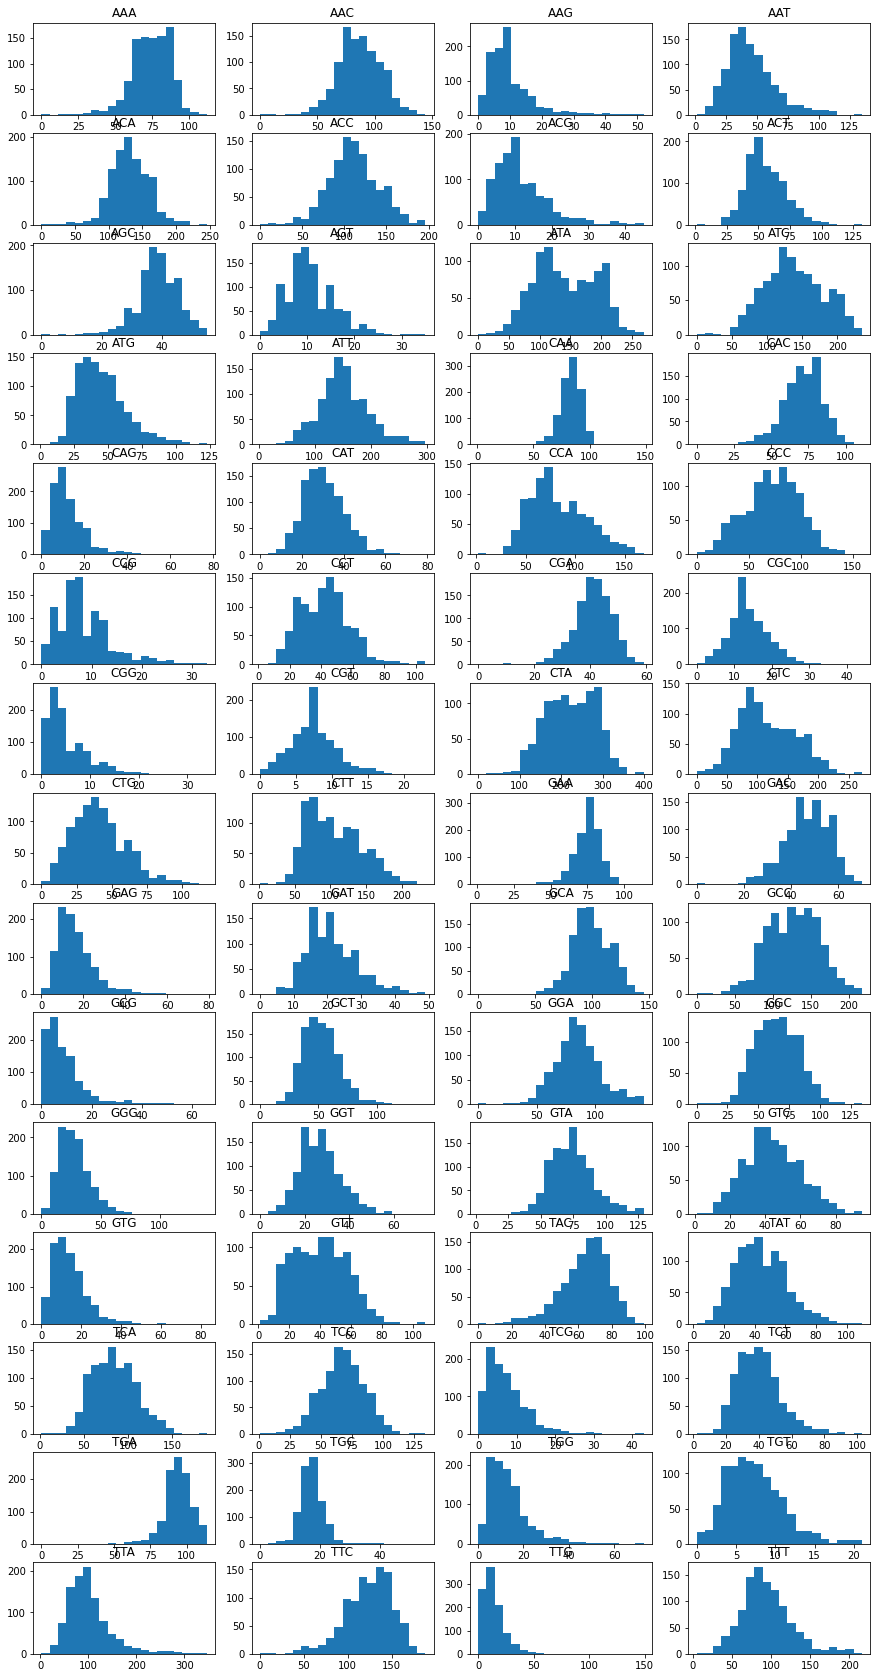

In [447]:
fig, ax = plt.subplots(15, 4, figsize=(15,30))
ax = ax.ravel()
for i in range(60):
    codon = the_matrix.Codon[i]
    ax[i].hist(the_matrix.loc[the_matrix.Codon == codon, 'CodonUsage'], bins=20)
    ax[i].set_title(codon)
plt.show()

In [440]:
glm_dms_sp.loc[:, 'Const'::2]

Const    TrnaGe   AAUsage  DummyCognate  DummyMutSpecMatch
0     2.684421  0.010752  0.002780      0.147525           0.955151
1     2.737947  0.015330  0.003000      0.094807           0.762163
2     2.823243 -0.004402  0.003353      0.387258           0.782643
3     2.734864  0.006920  0.002854      0.133482           0.935623
4     2.952320  0.009824  0.002747      0.093247           0.623634
...        ...       ...       ...           ...                ...
1020  2.568339  0.030219  0.003279      0.195706           0.673010
1021  2.924767 -0.016796  0.003213      0.402839           0.903152
1022  2.794080  0.021115  0.002595     -0.044190           0.652059
1023  2.440134  0.024511  0.002824      0.151849           0.918171
1024  2.798773  0.018656  0.002637      0.034992           0.726779

[1025 rows x 5 columns]

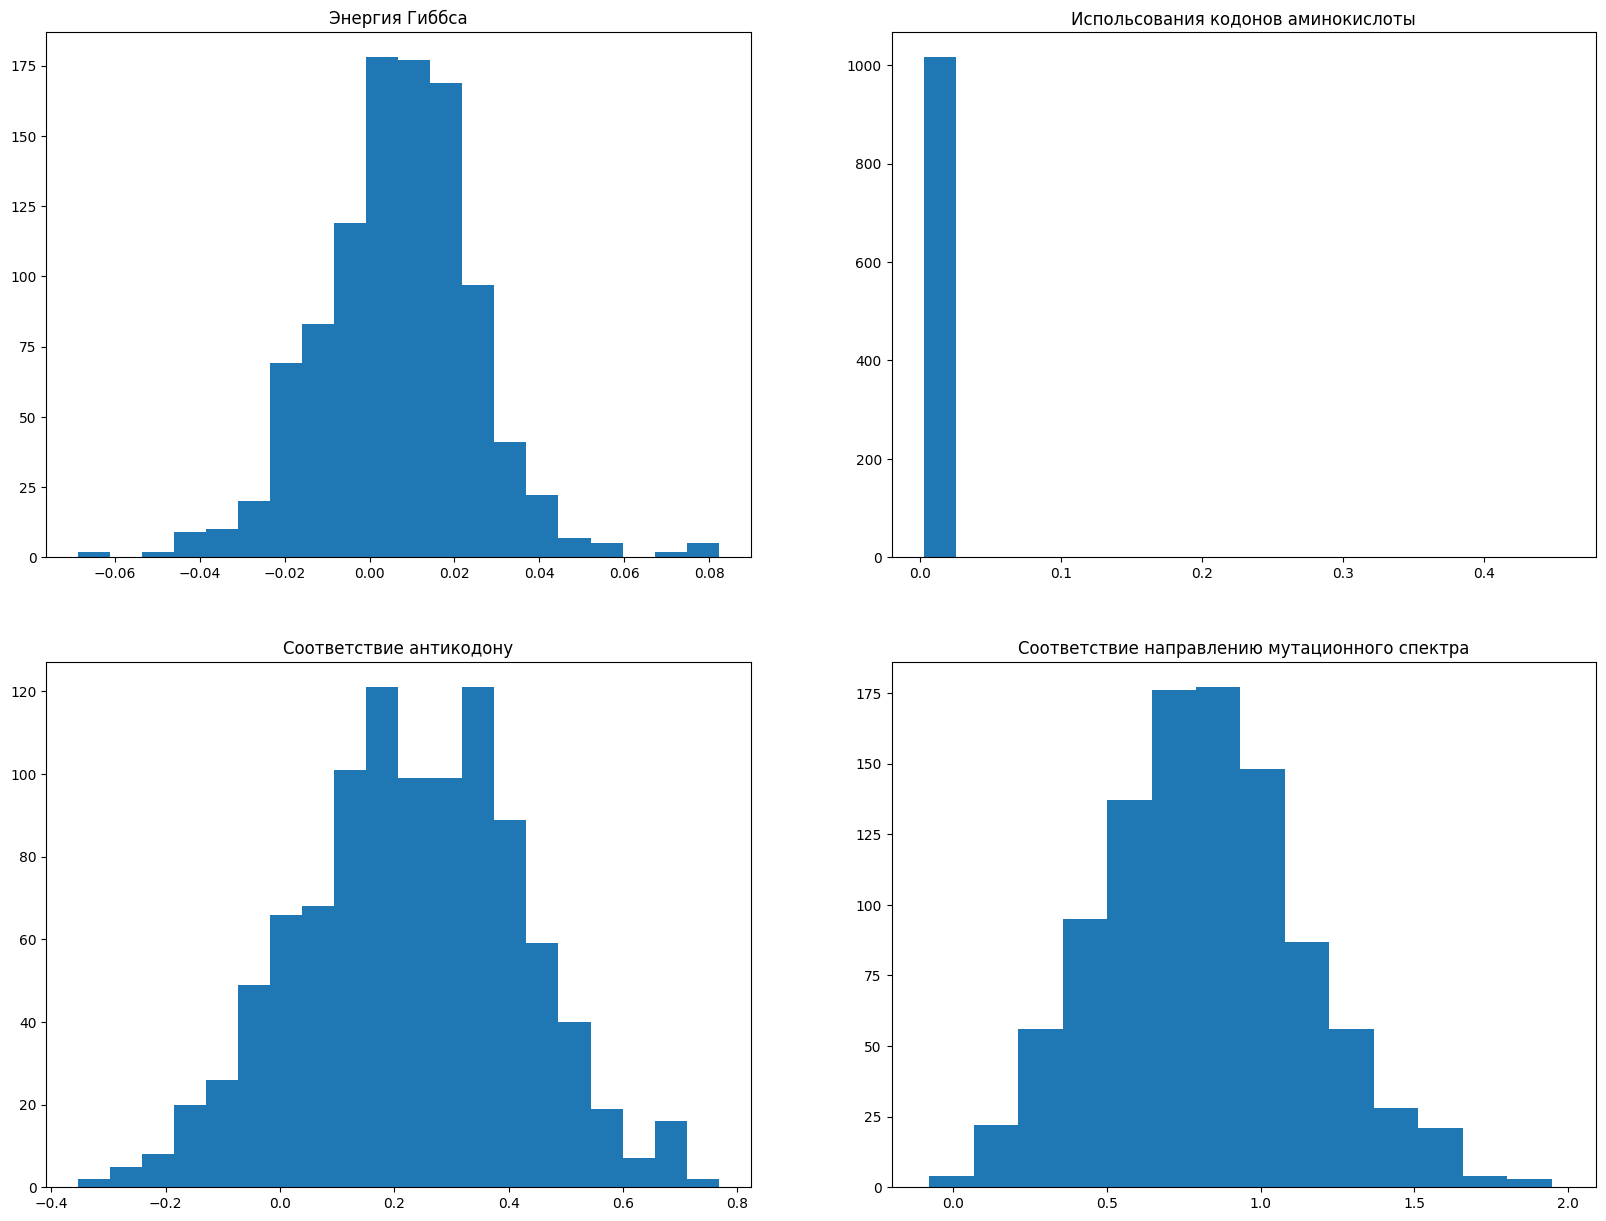

In [18]:
fig, ax = plt.subplots(2,2, figsize=(20,15), facecolor='white')
ax = ax.ravel()
labels = ['Энергия Гиббса', 'Испольсования кодонов аминокислоты', 
          'Соответствие антикодону', 'Соответствие направлению мутационного спектра']
for i, predictor in enumerate(glm_dms_sp.loc[:, 'TrnaGe'::2].columns):
    ax[i].hist(glm_dms_sp.loc[:, predictor], bins=20)
    if i == 3:
        ax[i].set_xlim(-0.2)  
    # ax[i].set_ylabel('')
    # ax[i].set_xlabel('')
    ax[i].set_title(labels[i])

In [19]:
glm_dms_sp

Species     Const       Const_pv    TrnaGe     TrnaGe_pv  \
0        Abalistes_stellaris  2.684421   0.000000e+00  0.010752  5.055323e-04   
1             Ablennes_hians  2.737947  2.385193e-211  0.015330  8.053896e-04   
2           Abronia_graminea  2.823243   0.000000e+00 -0.004402  3.220251e-01   
3       Abudefduf_vaigiensis  2.734864  2.710178e-167  0.006920  1.494054e-01   
4     Acanthaluteres_brownii  2.952320  3.379400e-290  0.009824  1.751049e-02   
...                      ...       ...            ...       ...           ...   
1012       Zaglossus_bruijni  2.568339  1.275806e-143  0.030219  1.275378e-06   
1013  Zalophus_californianus  2.924767  1.889121e-210 -0.016796  4.075118e-03   
1014        Zanclus_cornutus  2.794080  7.626099e-275  0.021115  2.196516e-08   
1015    Zebrasoma_flavescens  2.440134  1.390995e-157  0.024511  6.050880e-08   
1016              Zeus_faber  2.798773   0.000000e+00  0.018656  1.151173e-07   

       AAUsage     AAUsage_pv  DummyCognate  DummyCognate_pv  \
0     0.002780  9.730683e-125      0.147525     4.814273e-04   
1     0.003000  1.171397e-118      0.094807     2.725784e-02   
2     0.003353  4.150738e-127      0.387258     1.778586e-19   
3     0.002854  5.452051e-154      0.133482     1.487110e-03   
4     0.002747  7.700123e-128      0.093247     3.055328e-02   
...        ...            ...           ...              ...   
1012  0.003279  8.247966e-122      0.195706     4.716219e-06   
1013  0.003213  1.817979e-157      0.402839     1.358538e-21   
1014  0.002595  1.427744e-126     -0.044190     3.083701e-01   
1015  0.002824  2.550570e-152      0.151849     3.622376e-04   
1016  0.002637   2.728251e-76      0.034992     4.190812e-01   

      DummyMutSpecMatch  DummyMutSpecMatch_pv  
0              0.955151          3.427345e-91  
1              0.762163          4.609461e-62  
2              0.782643          8.004509e-60  
3              0.935623          9.517373e-90  
4              0.623634          6.676153e-44  
...                 ...                   ...  
1012           0.673010          8.755329e-49  
1013           0.903152          1.579778e-77  
1014           0.652059          4.980161e-49  
1015           0.918171          1.270811e-84  
1016           0.726779          1.328067e-57  

[1017 rows x 11 columns]

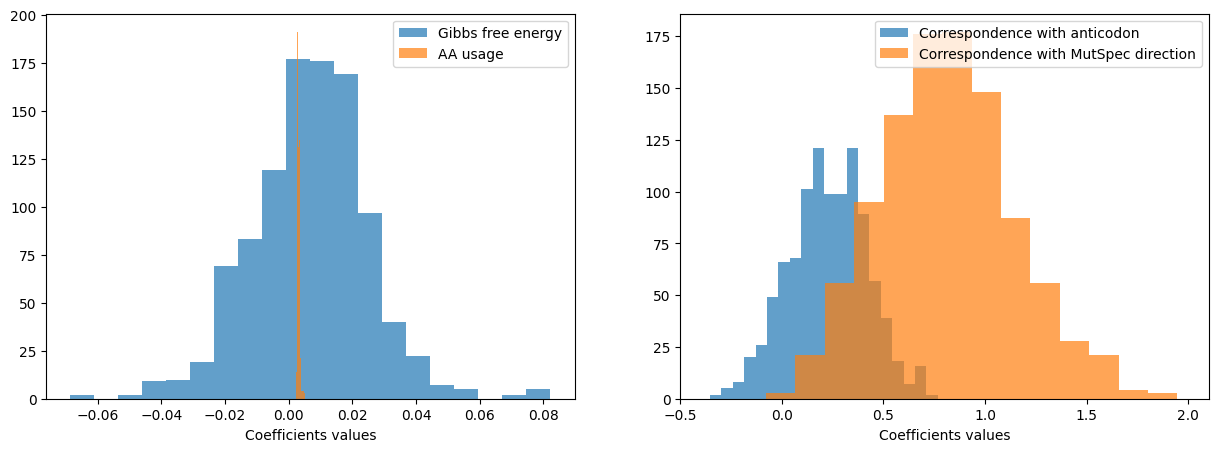

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), facecolor='white')
ax = ax.ravel()
labels = ['Gibbs free energy', 'AA usage', 
          'Сorrespondence with anticodon', 'Correspondence with MutSpec direction']
for i, predictor in enumerate(glm_dms_sp.loc[:, 'TrnaGe'::2].columns):
    if i in [0, 1]:
        ax[0].hist(glm_dms_sp.loc[:, predictor], bins=20, alpha=0.7, label=labels[i])
        # ax[0].set_title(labels[i])
        ax[0].set_xlabel('Coefficients values')
        ax[0].legend()
        
    else:
        ax[1].hist(glm_dms_sp.loc[:, predictor], bins=20, alpha=0.7, label=labels[i])
        # ax[1].set_title(labels[i])
        ax[1].set_xlabel('Coefficients values')
        ax[1].set_xlim(-0.5, 2.1) 
        ax[1].legend()
    # if i == 3:
    #      
    # ax[i].set_ylabel('')
    # ax[i].set_xlabel('')
    

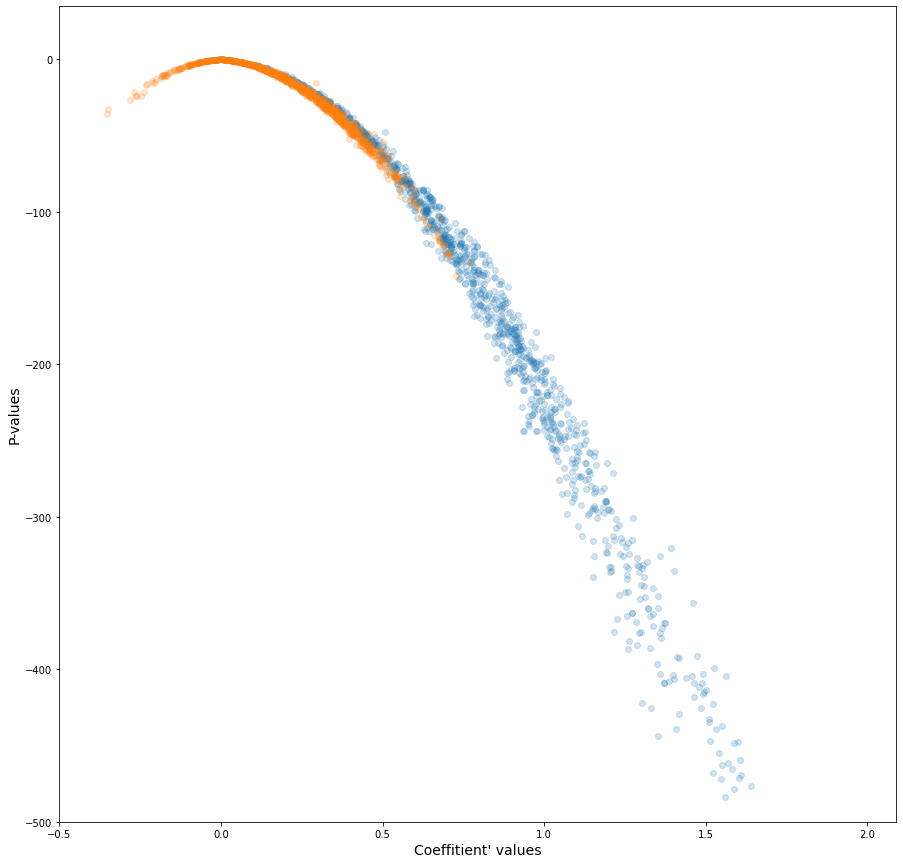

In [529]:
plt.figure(figsize=(15,15), facecolor='white')
plt.scatter(glm_dms_sp.DummyMutSpecMatch, np.log(glm_dms_sp.DummyMutSpecMatch_pv), alpha=0.2)
plt.scatter(glm_dms_sp.DummyCognate, np.log(glm_dms_sp.DummyCognate_pv), alpha=0.2)
plt.ylim(-500,)
plt.xlim(-.5,)
plt.ylabel('P-values', fontsize=14)
plt.xlabel("Coeffitient' values", fontsize=14)
plt.show()

In [512]:
glm_dms_sp.iloc[np.where(glm_dms_sp.DummyMutSpecMatch < -0.5)]



Species     Const       Const_pv    TrnaGe  TrnaGe_pv   
30  Albula_glossodonta  3.891184  5.854722e-230 -0.007678   0.228381  \

     AAUsage    AAUsage_pv  DummyCognate  DummyCognate_pv  DummyMutSpecMatch   
30  0.003348  3.875609e-73      0.295052     1.514244e-07          -0.944406  \

    DummyMutSpecMatch_pv  
30          1.916832e-72

# Cognate-common test

In [39]:
ratio_trna_12 = CU_12_fraction[CU_12_fraction.index.isin(trna_cu_df.index)]
ratio_trna_13 = CU_13_fraction[CU_13_fraction.index.isin(trna_cu_df.index)]
ratio_trna_12

AAA       AAC       AAG       AAT       ACA  \
Species                                                                    
Abalistes_stellaris     0.017650  0.022339  0.001931  0.010756  0.034197   
Ablennes_hians          0.020954  0.022057  0.000827  0.012683  0.036118   
Abronia_graminea        0.022148  0.025194  0.002492  0.016334  0.047619   
Abudefduf_vaigiensis    0.021165  0.023364  0.000000  0.008796  0.029137   
Acanthaluteres_brownii  0.015690  0.023397  0.004679  0.007707  0.031654   
...                          ...       ...       ...       ...       ...   
Zaglossus_bruijni       0.020741  0.026549  0.003595  0.014381  0.035122   
Zalophus_californianus  0.024046  0.024599  0.002488  0.016307  0.040077   
Zanclus_cornutus        0.014341  0.019029  0.005792  0.012135  0.025372   
Zebrasoma_flavescens    0.018452  0.022583  0.001928  0.009364  0.034150   
Zeus_faber              0.020127  0.019024  0.001930  0.014613  0.030604   

                             ACC       ACG       ACT  AGA       AGC  ...  \
Species                                                              ...   
Abalistes_stellaris     0.037231  0.002482  0.010756  0.0  0.012410  ...   
Ablennes_hians          0.031431  0.000551  0.015991  0.0  0.010201  ...   
Abronia_graminea        0.033776  0.002492  0.014950  0.0  0.010520  ...   
Abudefduf_vaigiensis    0.034360  0.004398  0.013194  0.0  0.012919  ...   
Acanthaluteres_brownii  0.030003  0.004129  0.012662  0.0  0.012937  ...   
...                          ...       ...       ...  ...       ...  ...   
Zaglossus_bruijni       0.027931  0.001936  0.019635  0.0  0.005254  ...   
Zalophus_californianus  0.030404  0.004146  0.015202  0.0  0.010779  ...   
Zanclus_cornutus        0.030061  0.004964  0.018478  0.0  0.010480  ...   
Zebrasoma_flavescens    0.030295  0.001652  0.014872  0.0  0.011842  ...   
Zeus_faber              0.029501  0.000551  0.016267  0.0  0.010753  ...   

                             TCG       TCT       TGA       TGC       TGG  \
Species                                                                    
Abalistes_stellaris     0.001655  0.008825  0.028406  0.005240  0.003309   
Ablennes_hians          0.000827  0.012131  0.027847  0.004136  0.002757   
Abronia_graminea        0.001661  0.010797  0.025748  0.004430  0.001938   
Abudefduf_vaigiensis    0.002474  0.009896  0.028587  0.005223  0.003299   
Acanthaluteres_brownii  0.004129  0.010460  0.025048  0.004955  0.006056   
...                          ...       ...       ...       ...       ...   
Zaglossus_bruijni       0.001383  0.010232  0.023783  0.003319  0.004701   
Zalophus_californianus  0.003040  0.009674  0.025428  0.005804  0.001935   
Zanclus_cornutus        0.003034  0.014065  0.025097  0.004137  0.006619   
Zebrasoma_flavescens    0.001377  0.010190  0.027816  0.004682  0.003856   
Zeus_faber              0.001379  0.012683  0.026744  0.003860  0.004411   

                             TGT       TTA       TTC       TTG       TTT  
Species                                                                   
Abalistes_stellaris     0.001655  0.029509  0.036404  0.003861  0.025648  
Ablennes_hians          0.002206  0.038048  0.031707  0.002757  0.031155  
Abronia_graminea        0.003322  0.031838  0.027962  0.002769  0.028516  
Abudefduf_vaigiensis    0.001649  0.015943  0.040682  0.002199  0.022815  
Acanthaluteres_brownii  0.002477  0.020644  0.037710  0.006331  0.022296  
...                          ...       ...       ...       ...       ...  
Zaglossus_bruijni       0.003319  0.039823  0.030420  0.005254  0.032080  
Zalophus_californianus  0.000276  0.023494  0.040077  0.002764  0.018795  
Zanclus_cornutus        0.002482  0.017375  0.037783  0.005516  0.024269  
Zebrasoma_flavescens    0.001377  0.019829  0.040209  0.003305  0.020931  
Zeus_faber              0.002481  0.039427  0.020678  0.003584  0.039151  

[944 rows x 64 columns]

## Fisher

In [ ]:
aa = 'Ala'
ac_typicality = trna_cu_df[aa] == cognate_acs[aa]
ac_ratio_list = []
for species in trna_cu_df[aa].index:  # ratio value for real anticodon for fiven aa and species
    ac = trna_cu_df[aa][species]
    cognate_codon = str(Seq(ac).reverse_complement())
    ac_ratio_list.append(ratio_trna_12.loc[species, cognate_codon])
ac_ratio_series = pd.Series(ac_ratio_list, index=trna_cu_df[aa].index)
ac_most_freq_codon = ac_ratio_series == ratio_trna_12[aa_dict_full[aa]].max(axis=1)
a = (ac_typicality & ac_most_freq_codon).sum()
b = (ac_typicality & ~ac_most_freq_codon).sum()
c = (~ac_typicality & ac_most_freq_codon).sum()
d = (~ac_typicality & ~ac_most_freq_codon).sum()
contingency_table = np.array([[a,b], [c, d]])
contingency_table

array([[213, 787],
       [  0,   2]], dtype=int64)

In [ ]:
# max codon == anticodon cognate codon
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
stats_dict = {i:{} for i in ['fisher', 'adj_odds', 'ci', 'chisquare']}
odds_dict = {}
contingency_table_list = []
for aa in cognate_acs:
    ac_typicality = trna_cu_df[aa] == cognate_acs[aa]
    ac_ratio_list = []
    for species in trna_cu_df[aa].index:  # ratio value for real anticodon for fiven aa and species
        ac = trna_cu_df[aa][species]
        cognate_codon = str(Seq(ac).reverse_complement())
        ac_ratio_list.append(ratio_trna_12.loc[species, cognate_codon])
    ac_ratio_series = pd.Series(ac_ratio_list, index=trna_cu_df[aa].index)
    ac_most_freq_codon = ac_ratio_series == ratio_trna_12[aa_dict_full[aa]].max(axis=1)
    a = (ac_typicality & ac_most_freq_codon).sum()
    b = (ac_typicality & ~ac_most_freq_codon).sum()
    c = (~ac_typicality & ac_most_freq_codon).sum()
    d = (~ac_typicality & ~ac_most_freq_codon).sum()
    contingency_table = np.array([[a,b], [c, d]])
    contingency_table_list.append(contingency_table)
    print(contingency_table, aa, sep='\t')

    adjusted_table = contingency_table + 0.5

    # Calculate adjusted odds ratio manually
    odds_treatment = adjusted_table[0, 0] / adjusted_table[0, 1]
    odds_no_treatment = adjusted_table[1, 0] / adjusted_table[1, 1]
    adjusted_or = odds_treatment / odds_no_treatment

    # Calculate the standard error of the log odds ratio
    se_log_or = np.sqrt(1/adjusted_table[0, 0] + 1/adjusted_table[0, 1] + 
                        1/adjusted_table[1, 0] + 1/adjusted_table[1, 1])

    # Calculate the confidence intervals
    z = 1.96  # for 95% confidence interval
    log_or = np.log(adjusted_or)
    ci = z * se_log_or    
    fisher_result = fisher_exact(contingency_table+1)
    chi_result = chi2_contingency(contingency_table+1)
    odds_result = odds_ratio(contingency_table)
    odds_ci = odds_result.confidence_interval()
    stats_dict['fisher'][aa] = fisher_result[1]
    stats_dict['chisquare'][aa] = chi_result[1]
    stats_dict['adj_odds'][aa] = log_or
    stats_dict['ci'][aa] = ci
    odds_dict[aa] = [odds_result.statistic, odds_ci[0], odds_ci[1]]

[[213 787]
 [  0   2]]	Ala
[[982  16]
 [  0   4]]	Arg
[[904  98]
 [  0   0]]	Asn
[[930  71]
 [  0   1]]	Asp
[[940  60]
 [  0   2]]	Cys
[[998   4]
 [  0   0]]	Gln
[[990  11]
 [  0   1]]	Glu
[[718 283]
 [  0   1]]	Gly
[[952  49]
 [  0   1]]	His
[[427 575]
 [  0   0]]	Ile
[[838 164]
 [  0   0]]	Leu1
[[996   6]
 [  0   0]]	Leu2
[[990  12]
 [  0   0]]	Lys
[[ 74 928]
 [  0   0]]	Met
[[719 281]
 [  1   1]]	Phe
[[518 484]
 [  0   0]]	Pro
[[989  12]
 [  0   1]]	Ser1
[[645 357]
 [  0   0]]	Ser2
[[648 354]
 [  0   0]]	Thr
[[998   4]
 [  0   0]]	Trp
[[798 204]
 [  0   0]]	Tyr
[[816 184]
 [  0   2]]	Val


In [32]:
tuple_list = []
for idx, i in enumerate(contingency_table_list):
    t = tuple(contingency_table_list[idx].reshape(4))
    # print(f'tRNA{idx+1} <- matrix(c{t}, nrow = 2)')
    # print(f'list({[f'matrix(c{t}, nrow = 2)' for i in range(22)]})')

# Mantel-Haenszel chi-squared test with continuity correction

# data:  tables
# Mantel-Haenszel X-squared = 96.87, df = 1, p-value < 2.2e-16
# alternative hypothesis: true common odds ratio is not equal to 1
# 95 percent confidence interval:
#    8.618542 254.641559
# sample estimates:
# common odds ratio
#          46.84698

list(matrix(c(213, 787, 0, 2), nrow = 2)),
list(matrix(c(982, 16, 0, 4), nrow = 2)),
list(matrix(c(904, 98, 0, 0), nrow = 2)),
list(matrix(c(930, 71, 0, 1), nrow = 2)),
list(matrix(c(940, 60, 0, 2), nrow = 2)),
list(matrix(c(998, 4, 0, 0), nrow = 2)),
list(matrix(c(990, 11, 0, 1), nrow = 2)),
list(matrix(c(718, 283, 0, 1), nrow = 2)),
list(matrix(c(952, 49, 0, 1), nrow = 2)),
list(matrix(c(427, 575, 0, 0), nrow = 2)),
list(matrix(c(838, 164, 0, 0), nrow = 2)),
list(matrix(c(996, 6, 0, 0), nrow = 2)),
list(matrix(c(990, 12, 0, 0), nrow = 2)),
list(matrix(c(74, 928, 0, 0), nrow = 2)),
list(matrix(c(719, 281, 1, 1), nrow = 2)),
list(matrix(c(518, 484, 0, 0), nrow = 2)),
list(matrix(c(989, 12, 0, 1), nrow = 2)),
list(matrix(c(645, 357, 0, 0), nrow = 2)),
list(matrix(c(648, 354, 0, 0), nrow = 2)),
list(matrix(c(998, 4, 0, 0), nrow = 2)),
list(matrix(c(798, 204, 0, 0), nrow = 2)),
list(matrix(c(816, 184, 0, 2), nrow = 2)),


In [16]:
from statsmodels.stats.contingency_tables import StratifiedTable
cmh_test = StratifiedTable(contingency_table_list)
result = cmh_test.test_null_odds()
result.pvalue == 0

True

In [ ]:
# max codon == typical codon
stats_dict = {i:{} for i in ['fisher', 'adj_odds', 'ci']}
odds_dict = {}
for aa in cognate_acs:
    ac_typicality = trna_cu_df[aa] == cognate_acs[aa]
    ac_most_freq_codon = ratio_trna_12[cognate_codons[aa]] == ratio_trna_12[aa_dict_full[aa]].max(axis=1)
    a = (ac_typicality & ac_most_freq_codon).sum()
    b = (ac_typicality & ~ac_most_freq_codon).sum()
    c = (~ac_typicality & ac_most_freq_codon).sum()
    d = (~ac_typicality & ~ac_most_freq_codon).sum()
    contingency_table = np.array([[a,b], [c, d]])

    adjusted_table = contingency_table + 0.5

    # Calculate adjusted odds ratio manually
    odds_treatment = adjusted_table[0, 0] / adjusted_table[0, 1]
    odds_no_treatment = adjusted_table[1, 0] / adjusted_table[1, 1]
    adjusted_or = odds_treatment / odds_no_treatment

    # Calculate the standard error of the log odds ratio
    se_log_or = np.sqrt(1/adjusted_table[0, 0] + 1/adjusted_table[0, 1] + 
                        1/adjusted_table[1, 0] + 1/adjusted_table[1, 1])

    # Calculate the confidence intervals
    z = 1.96  # for 95% confidence interval
    log_or = np.log(adjusted_or)
    ci = z * se_log_or    
    fisher_result = fisher_exact(contingency_table+1)
    odds_result = odds_ratio(contingency_table)
    odds_ci = odds_result.confidence_interval()
    stats_dict['fisher'][aa] = fisher_result[1]
    stats_dict['adj_odds'][aa] = log_or
    stats_dict['ci'][aa] = ci
    odds_dict[aa] = [odds_result.statistic, odds_ci[0], odds_ci[1]]
    print(aa, contingency_table.tolist(), sep='\t')

Ala	[[213, 787], [0, 2]]
Arg	[[982, 16], [4, 0]]
Asn	[[904, 98], [0, 0]]
Asp	[[930, 71], [1, 0]]
Cys	[[940, 60], [2, 0]]
Gln	[[998, 4], [0, 0]]
Glu	[[990, 11], [1, 0]]
Gly	[[718, 283], [0, 1]]
His	[[952, 49], [1, 0]]
Ile	[[427, 575], [0, 0]]
Leu1	[[838, 164], [0, 0]]
Leu2	[[996, 6], [0, 0]]
Lys	[[990, 12], [0, 0]]
Met	[[74, 928], [0, 0]]
Phe	[[719, 281], [1, 1]]
Pro	[[518, 484], [0, 0]]
Ser1	[[989, 12], [1, 0]]
Ser2	[[645, 357], [0, 0]]
Thr	[[648, 354], [0, 0]]
Trp	[[998, 4], [0, 0]]
Tyr	[[798, 204], [0, 0]]
Val	[[816, 184], [2, 0]]


In [23]:
stats_dict['chisquare']

{'Ala': 1.0,
 'Arg': 2.114719554712574e-34,
 'Asn': 0.4761442462987868,
 'Asp': 0.004602306776445355,
 'Cys': 4.040073720013735e-06,
 'Gln': 7.234894011722532e-06,
 'Glu': 6.120384646886313e-13,
 'Gly': 0.40681804738744076,
 'His': 0.00044399981913274713,
 'Ile': 1.0,
 'Leu1': 0.7458394286192225,
 'Leu2': 0.00011442831788890076,
 'Lys': 0.0043318363035650875,
 'Met': 0.3500497232409997,
 'Phe': 0.6798391476400818,
 'Pro': 1.0,
 'Ser1': 3.838876183973189e-12,
 'Ser2': 1.0,
 'Thr': 1.0,
 'Trp': 7.234894011722532e-06,
 'Tyr': 0.8739331634263734,
 'Val': 0.024301475373831045}

In [15]:
stats_dict['fisher']

{'Ala': 1.0,
 'Arg': 1.8322834169391407e-08,
 'Asn': 0.18901516275481436,
 'Asp': 0.015262861789836588,
 'Cys': 0.0009401537680064468,
 'Gln': 0.011898756713450637,
 'Glu': 0.000535740188115524,
 'Gly': 0.19625211211177362,
 'His': 0.00760794098464455,
 'Ile': 1.0,
 'Leu1': 0.30292869647784926,
 'Leu2': 0.015849183505929593,
 'Lys': 0.027652987547352695,
 'Met': 0.14545562446218213,
 'Phe': 0.31711089430009093,
 'Pro': 1.0,
 'Ser1': 0.0006177479926293461,
 'Ser2': 1.0,
 'Thr': 1.0,
 'Trp': 0.011898756713450637,
 'Tyr': 0.3677734587499875,
 'Val': 0.02220307322676018}

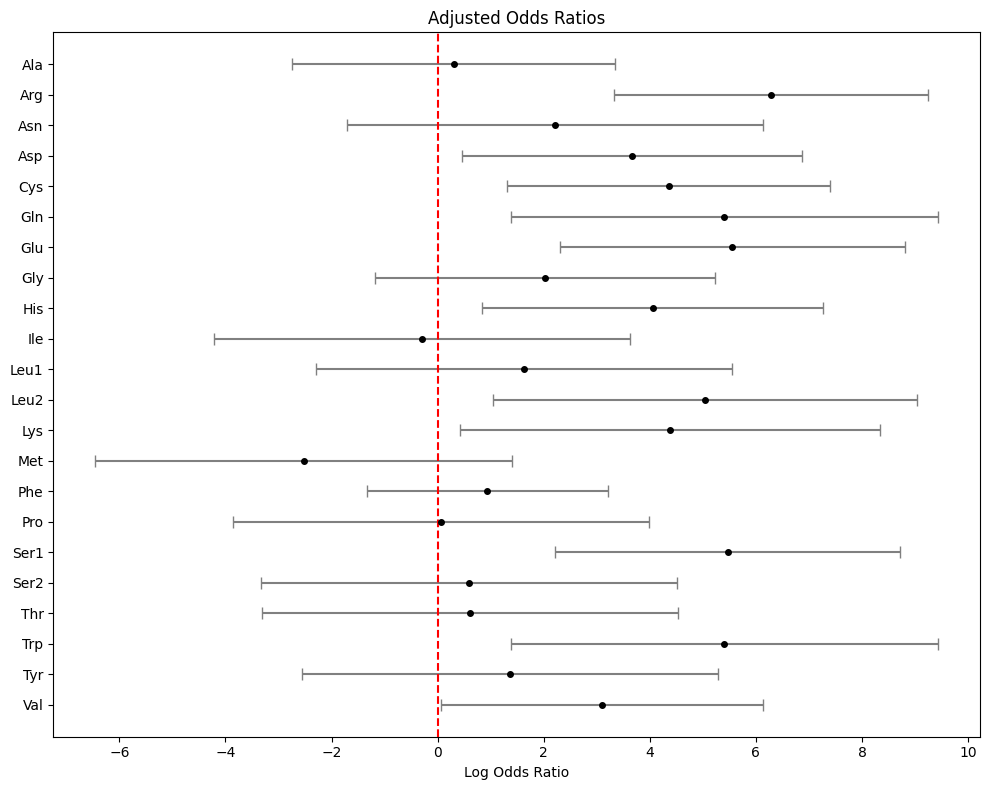

In [173]:
aas = [f"{aa}" for aa in stats_dict['adj_odds'].keys()]
or_list = list(stats_dict['adj_odds'].values())
ci_list = list(stats_dict['ci'].values())

fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
ax.errorbar(or_list, range(len(or_list)), xerr=ci_list, fmt='o', color='black', ecolor='gray', capsize=4, markersize=4)
ax.axvline(x=0, color='red', linestyle='--')
ax.set_yticks(range(len(aas)))
ax.set_yticklabels(aas)
ax.set_xlabel('Log Odds Ratio')
ax.set_title('Adjusted Odds Ratios')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## wilcoxon/binomial

In [25]:
trna_cu_df

AA                      Ala  Arg  Asn  Asp  Cys  Gln  Glu  Gly  His  Ile  ...  \
Species                                                                   ...   
Abalistes_stellaris     TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  ...   
Ablennes_hians          TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  ...   
Abronia_graminea        TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  ...   
Abudefduf_vaigiensis    TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  ...   
Acanthaluteres_brownii  TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  ...   
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
Zaglossus_bruijni       TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  ...   
Zalophus_californianus  TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  ...   
Zanclus_cornutus        TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  ...   
Zebrasoma_flavescens    TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  ...   
Zeus_faber              TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  ...   

AA                      Lys  Met  Phe  Pro Ser1 Ser2  Thr  Trp  Tyr  Val  
Species                                                                   
Abalistes_stellaris     TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Ablennes_hians          TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Abronia_graminea        TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Abudefduf_vaigiensis    TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Acanthaluteres_brownii  TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
Zaglossus_bruijni       TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Zalophus_californianus  TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Zanclus_cornutus        TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Zebrasoma_flavescens    TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Zeus_faber              TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  

[1002 rows x 22 columns]

In [ ]:
binom_dict = {}
for aa in cognate_acs:
    # ac_typicality = trna_cu_df[aa] == aa_cognate_ac[aa]
    ac_ratio_list = []
    for species in trna_cu_df[aa].index:  # ratio value for real anticodon for fiven aa and species
        ac = trna_cu_df[aa][species]
        cognate_codon = str(Seq(ac).reverse_complement())
        ac_ratio_list.append(ratio_trna_12.loc[species, cognate_codon])
    ac_ratio_series = pd.Series(ac_ratio_list, index=trna_cu_df[aa].index)
    ac_most_freq_codon = ac_ratio_series == ratio_trna_12[aa_dict_full[aa]].max(axis=1)
    binom_result = binomtest(ac_most_freq_codon.sum(), len(trna_cu_df), 1/len(aa_dict_full[aa]), alternative='greater')
    print(ac_most_freq_codon.sum(), aa, len(aa_dict_full[aa]))
    binom_dict[aa] = binom_result.pvalue
binom_dict

213 Ala 4
982 Arg 4
904 Asn 2
930 Asp 2
940 Cys 2
998 Gln 2
990 Glu 2
718 Gly 4
952 His 2
427 Ile 2
838 Leu1 4
996 Leu2 2
990 Lys 2
74 Met 2
720 Phe 2
518 Pro 4
989 Ser1 2
645 Ser2 4
648 Thr 4
998 Trp 2
798 Tyr 2
816 Val 4


{'Ala': 0.9975741470563075,
 'Arg': 0.0,
 'Asn': 2.5001217245438395e-164,
 'Asp': 3.492699496952142e-191,
 'Cys': 1.3076634341062773e-202,
 'Gln': 9.780049239192249e-292,
 'Glu': 4.7270394050485096e-275,
 'Gly': 1.4988796933914909e-210,
 'His': 2.5805852078261087e-217,
 'Ile': 0.999998794044453,
 'Leu1': 0.0,
 'Leu2': 3.25030172078901e-287,
 'Lys': 4.7270394050485096e-275,
 'Met': 1.0,
 'Phe': 4.464422430962375e-45,
 'Pro': 4.0462200726242515e-73,
 'Ser1': 3.6035474548894525e-273,
 'Ser2': 9.495091456609383e-152,
 'Thr': 5.8411866342251116e-154,
 'Trp': 9.780049239192249e-292,
 'Tyr': 7.899485576510221e-84,
 'Val': 6.700655107944011e-308}

## TukeyHSP

In [285]:
codon_redundancy = {group:[] for group in ['4_fold', '2_fold_AG', '2_fold_CT']}
codon_redundancy['4_fold'] = ['Ala', 'Arg','Gly', 'Leu1', 'Pro', 'Ser2', 'Thr', 'Val']
codon_redundancy['2_fold_AG'] = ['Gln', 'Glu', 'Leu2', 'Lys', 'Met', 'Trp']
codon_redundancy['2_fold_CT'] = ['Asn', 'Asp', 'Cys', 'His', 'Ile', 'Phe', 'Ser1', 'Tyr']

In [333]:
trna_cu_df[(trna_cu_df==cognate_acs.values()).all(axis=1)]

AA                      Ala  Arg  Asn  Asp  Cys  Gln  Glu  Gly  His  Ile Leu1  \
Species                                                                         
Abalistes_stellaris     TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  TAG   
Ablennes_hians          TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  TAG   
Abronia_graminea        TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  TAG   
Abudefduf_vaigiensis    TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  TAG   
Acanthaluteres_brownii  TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  TAG   
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
Zaglossus_bruijni       TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  TAG   
Zalophus_californianus  TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  TAG   
Zanclus_cornutus        TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  TAG   
Zebrasoma_flavescens    TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  TAG   
Zeus_faber              TGC  TCG  GTT  GTC  GCA  TTG  TTC  TCC  GTG  GAT  TAG   

AA                     Leu2  Lys  Met  Phe  Pro Ser1 Ser2  Thr  Trp  Tyr  Val  
Species                                                                        
Abalistes_stellaris     TAA  TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Ablennes_hians          TAA  TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Abronia_graminea        TAA  TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Abudefduf_vaigiensis    TAA  TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Acanthaluteres_brownii  TAA  TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
Zaglossus_bruijni       TAA  TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Zalophus_californianus  TAA  TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Zanclus_cornutus        TAA  TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Zebrasoma_flavescens    TAA  TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  
Zeus_faber              TAA  TTT  CAT  GAA  TGG  GCT  TGA  TGT  TCA  GTA  TAC  

[930 rows x 22 columns]

In [ ]:
def tukey_plot(aa_list, ratio_trna, exclude_exp=True):
    if len(aa_list) == 22:
        fig, ax = plt.subplots(4, 3, figsize=(6,8), facecolor='white', dpi=300)  # 
    elif len(aa_list) == 8:
        fig, ax = plt.subplots(2, 4, figsize=(4,20), facecolor='white', dpi=300)  # 
    elif len(aa_list) == 6:
        fig, ax = plt.subplots(2, 3, figsize=(4,12), facecolor='white', dpi=300)  # 
    ax = ax.ravel()
    if exclude_exp:
        data = trna_cu_df[(trna_cu_df == cognate_acs.values()).all(axis=1)]
    else:
        data = trna_cu_df
    for i, aa in enumerate(aa_list):
        # ac_ratio_list = []  # extraction ratio values for real cognate codon for given aa and species 
        # for species in data[aa].index:  
        #     ac = data[aa][species]
        #     cognate_codon = str(Seq(ac).reverse_complement())
        #     ac_ratio_list.append(ratio_trna_df.loc[species, cognate_codon])
        # ac_ratio_series = pd.Series(ac_ratio_list, index=data[aa].index)
        cognate_codon = str(Seq(cognate_acs[aa]).reverse_complement())
        codons_series_list = [ratio_trna.loc[data.index, codon] for codon in aa_dict_full[aa]]
        if len(aa_dict_full[aa])==4:
            anova_result = f_oneway(codons_series_list[0], codons_series_list[1], codons_series_list[2], codons_series_list[3])
            groups = [aa_dict_full[aa][0]]*len(data) + [aa_dict_full[aa][1]]*len(data) + [aa_dict_full[aa][2]]*len(data) + [aa_dict_full[aa][3]]*len(data)
        else:
            anova_result = f_oneway(codons_series_list[0], codons_series_list[1])
            groups = [aa_dict_full[aa][0]]*len(data) + [aa_dict_full[aa][1]]*len(data)
        if anova_result.pvalue < 0.05:
            tukey_result = pairwise_tukeyhsd(pd.concat(codons_series_list), groups)
        tukey_dict[aa] = tukey_result.pvalues
        anova_dict[aa] = anova_result.pvalue
        tukey_result.plot_simultaneous(comparison_name=cognate_codon, ax=ax[i])
        if aa == 'Ser1':
            aa = 'Ser(AGY)'
        elif aa == 'Ser2':
            aa = 'Ser(TCN)'
        elif aa == 'Leu1':
            aa = 'Leu(CTN)'
        elif aa == 'Leu2':
            aa = 'Leu(TTR)'
        ax[i].set_title(f'{aa}')
        ax[i].set_xlim(left=0)
    plt.subplots_adjust(wspace=0.3, hspace=0.5, bottom=0.5)
    if len(aa_list) == 6:
        plt.subplots_adjust(right=0.7)
    plt.show()

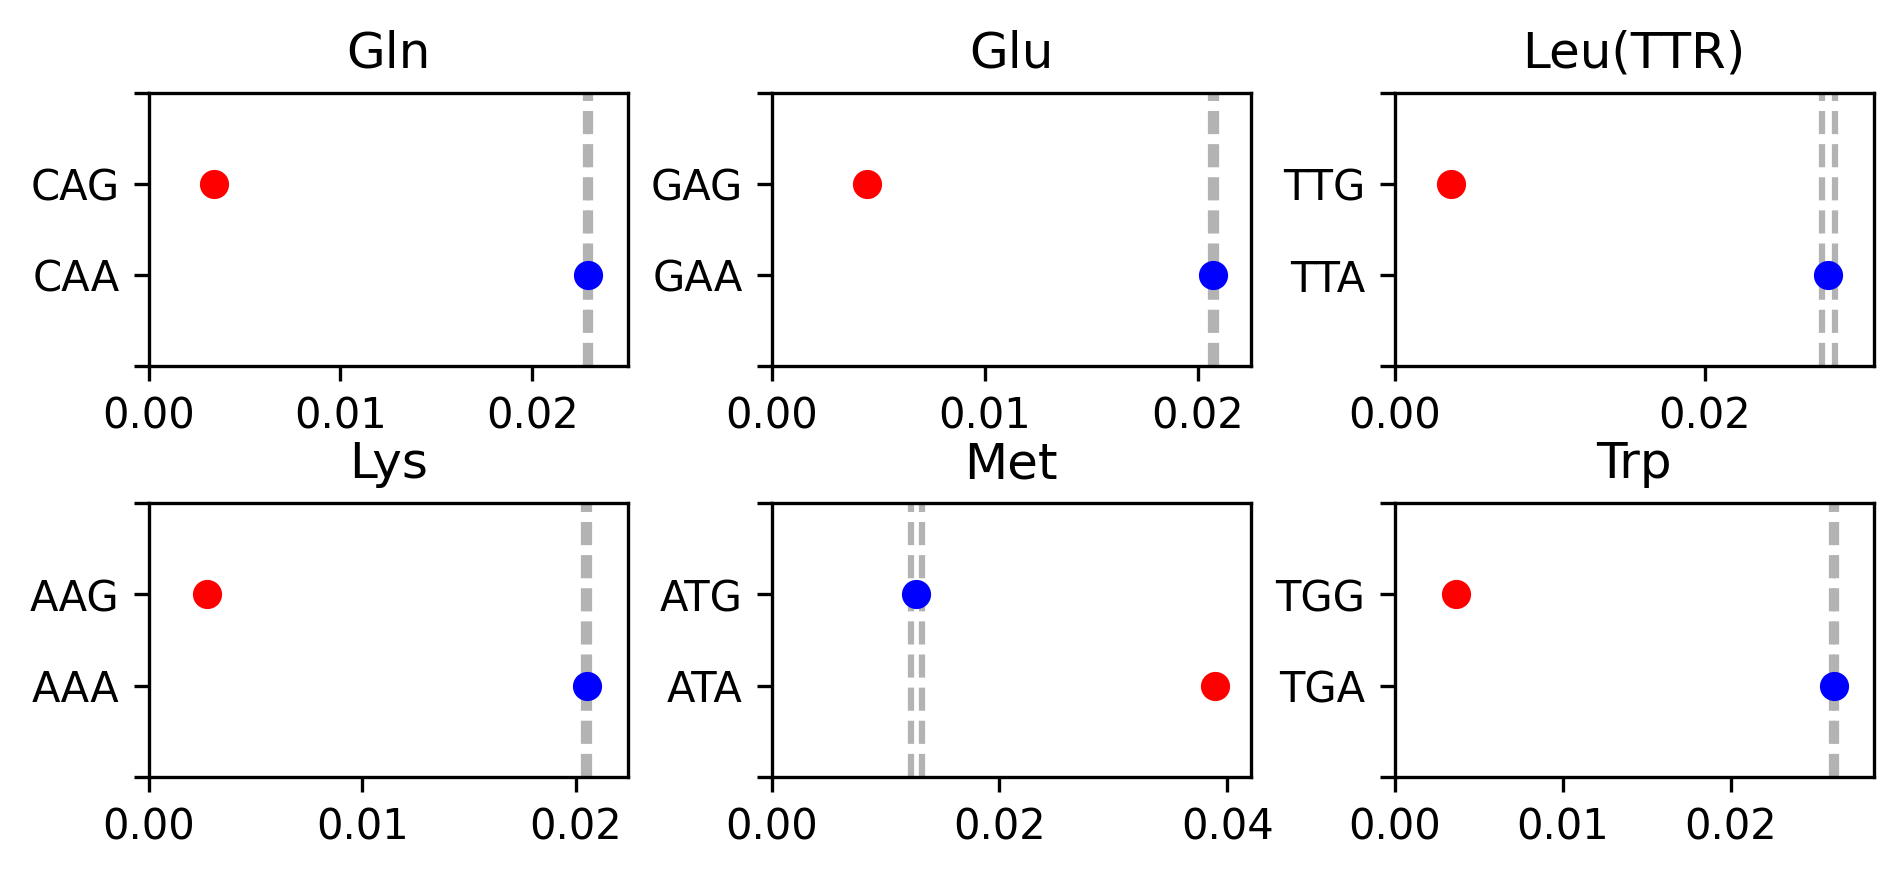

In [ ]:
tukey_dict = {}
anova_dict = {}
tukey_plot(codon_redundancy['2_fold_AG'], ratio_trna_12)

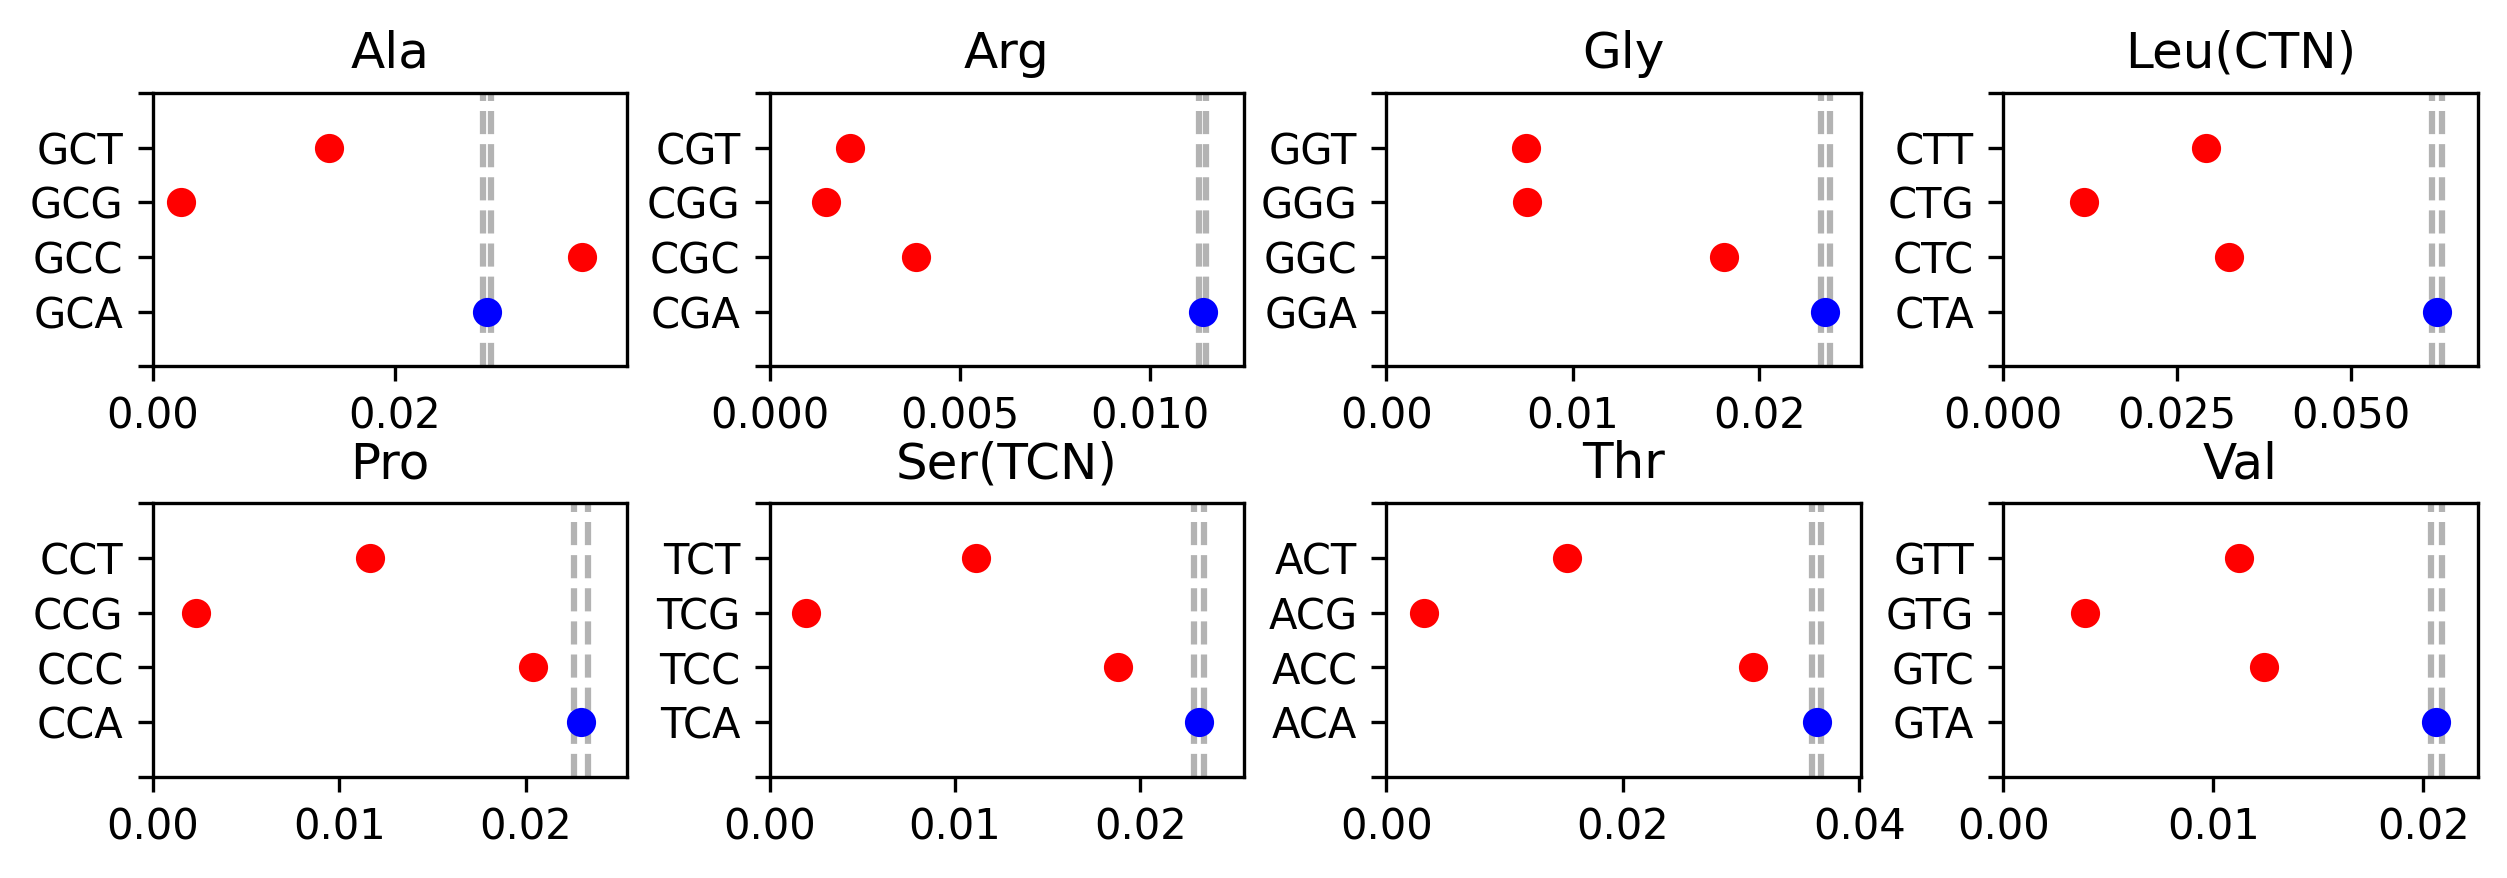

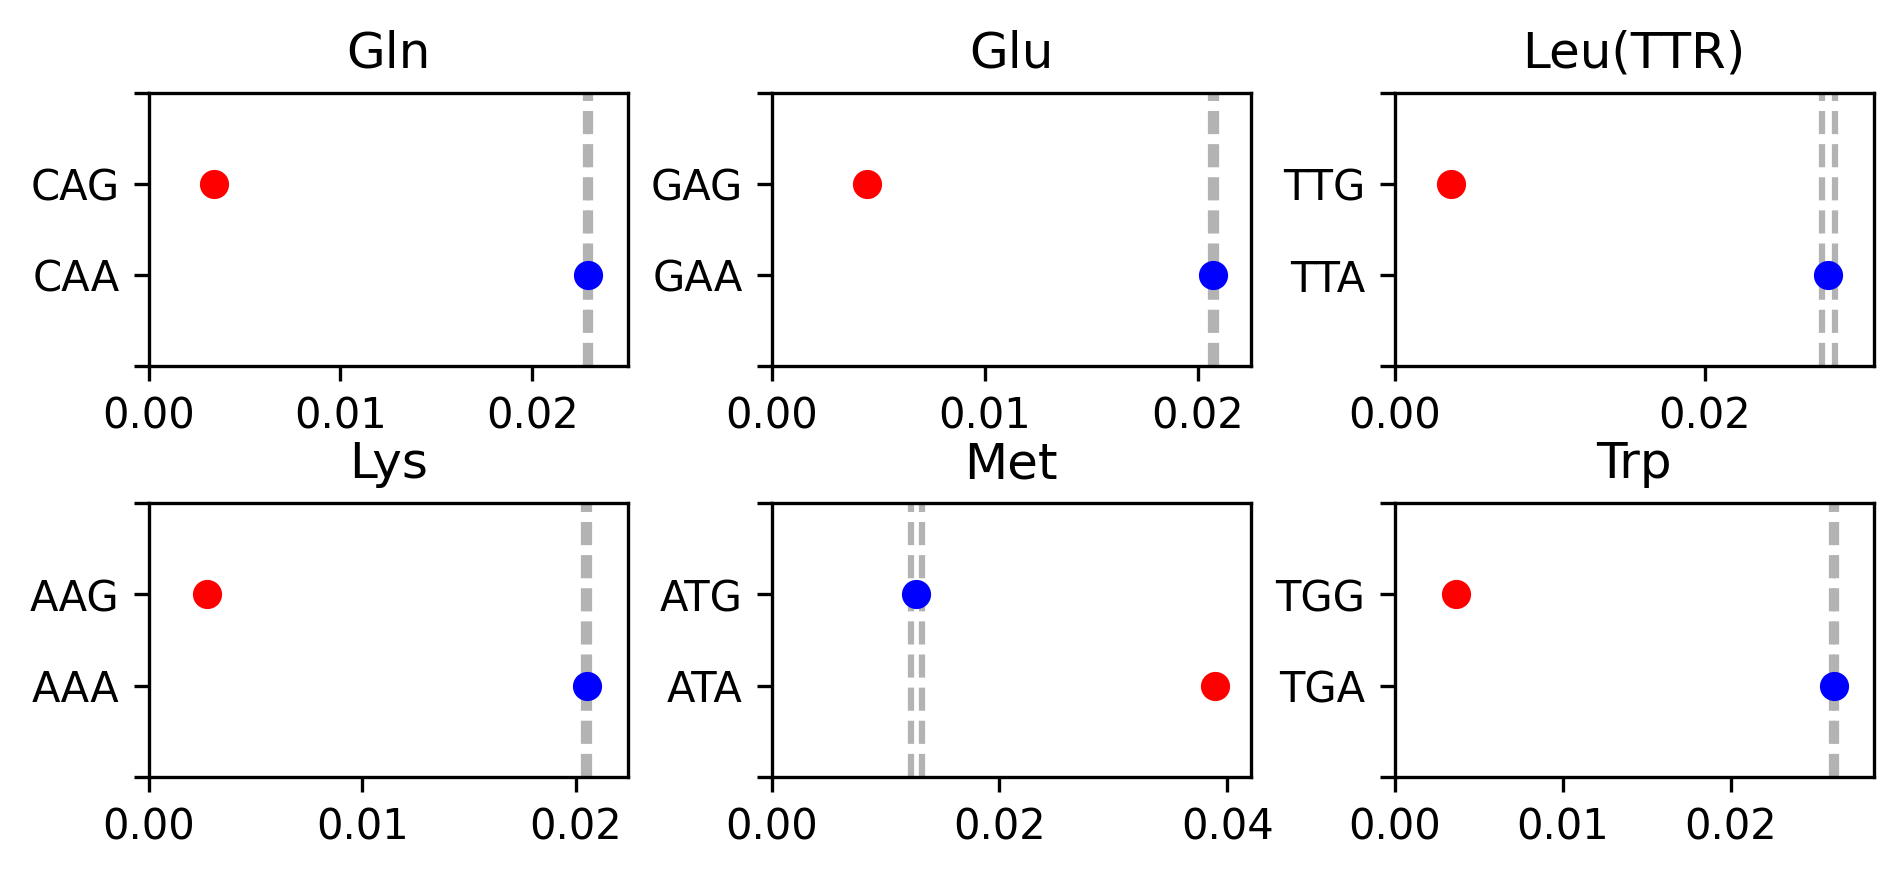

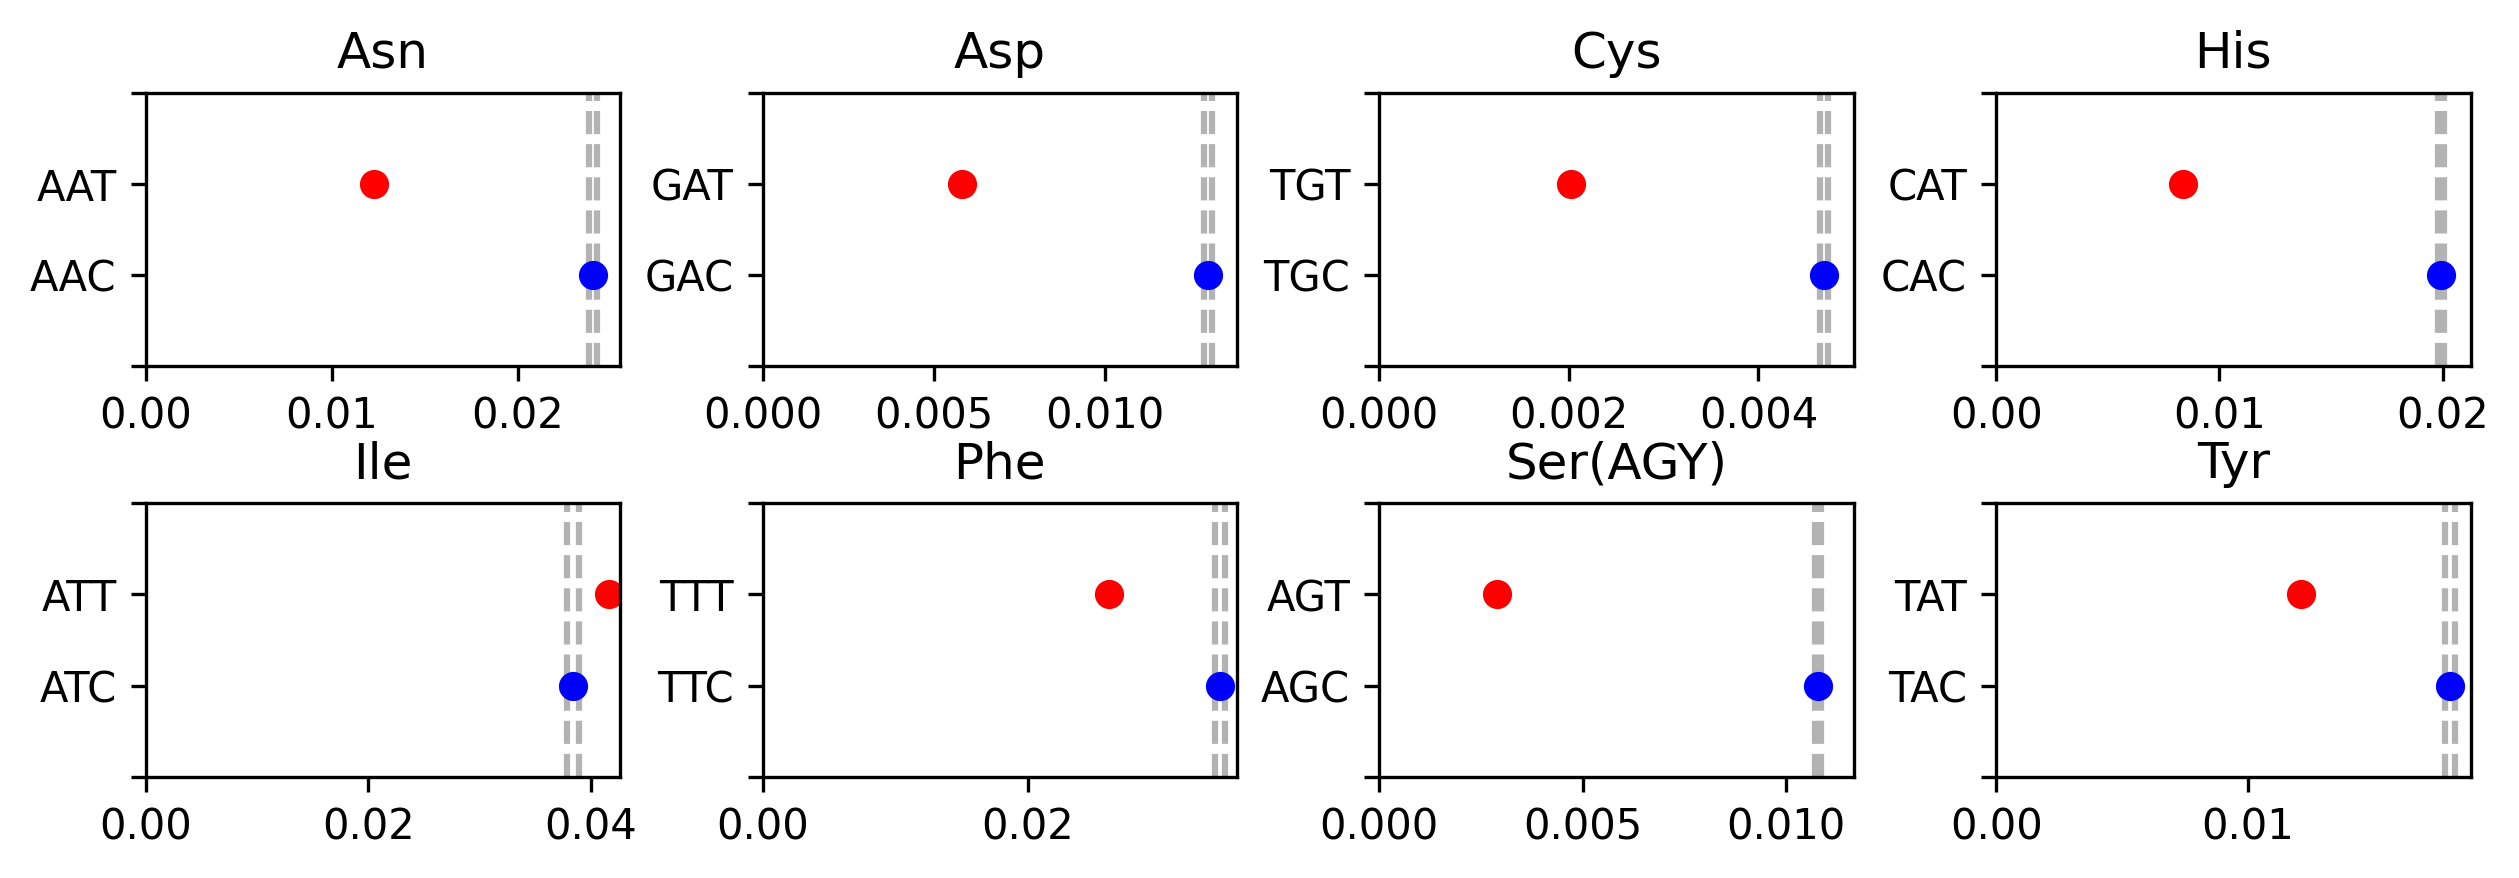

In [ ]:
for degeneracy in codon_redundancy:
    tukey_dict = {}
    tukey_plot(codon_redundancy[degeneracy], ratio_trna_12)
    # print(tukey_dict)

<Axes: >

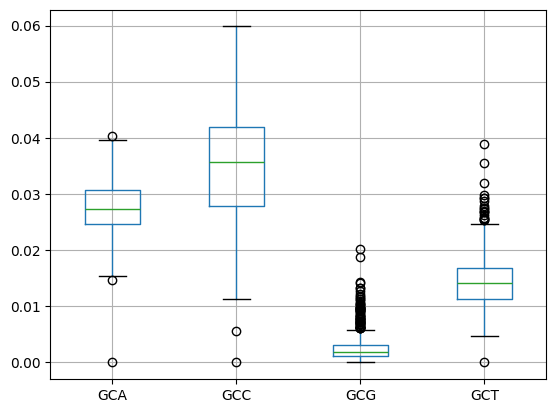

In [ ]:
dic = ratio_trna_12.loc[:, 'GCA':'GCT'].to_dict()
ratio_trna_12.loc[:, 'GCA':'GCT'].boxplot()

In [57]:
res = tukey_hsd(list(dic['GCA'].values()), list(dic['GCC'].values()), list(dic['GCG'].values()), list(dic['GCT'].values()))
print(res)


Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.008     0.000    -0.008    -0.007
 (0 - 2)      0.025     0.000     0.024     0.026
 (0 - 3)      0.013     0.000     0.012     0.014
 (1 - 0)      0.008     0.000     0.007     0.008
 (1 - 2)      0.033     0.000     0.032     0.033
 (1 - 3)      0.021     0.000     0.020     0.021
 (2 - 0)     -0.025     0.000    -0.026    -0.024
 (2 - 1)     -0.033     0.000    -0.033    -0.032
 (2 - 3)     -0.012     0.000    -0.013    -0.011
 (3 - 0)     -0.013     0.000    -0.014    -0.012
 (3 - 1)     -0.021     0.000    -0.021    -0.020
 (3 - 2)      0.012     0.000     0.011     0.013



In [ ]:
data = trna_cu_df[(trna_cu_df==cognate_acs.values()).all(axis=1)]
for aa in aa_dict_full:
    codons_series_list = [ratio_trna_12.loc[data.index, codon] for codon in aa_dict_full[aa]]
    if len(aa_dict_full[aa]) == 4:
        groups = [aa_dict_full[aa][0]]*len(data) + [aa_dict_full[aa][1]]*len(data) + [aa_dict_full[aa][2]]*len(data) + [aa_dict_full[aa][3]]*len(data)
    else:
        groups = [aa_dict_full[aa][0]]*len(data) + [aa_dict_full[aa][1]]*len(data)
    res = pairwise_tukeyhsd(pd.concat(codons_series_list), groups)
    print(aa)
    print(res)
# res.plot_simultaneous()

Phe
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   TTC    TTT  -0.0078   0.0 -0.0085 -0.007   True
--------------------------------------------------
Leu2
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   TTA    TTG  -0.0243   0.0 -0.0252 -0.0235   True
---------------------------------------------------
Ser2
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   TCA    TCC  -0.0044   0.0  -0.005 -0.0039   True
   TCA    TCG   -0.021   0.0 -0.0216 -0.0205   True
   TCA    TCT  -0.0119   0.0 -0.0125 -0.0114   True
   TCC    TCG  -0.0166   0.0 -0.0172 -0.0161   True
   TCC    TCT  -0.0075   0.0 -0.0081  -0.007   True
   TCG    TCT   0.0091   0.0  0.0086  0.0097   True
--

In [17]:
tukey_dict

{'Ala': array([1.1967094e-12, 1.1967094e-12, 1.1967094e-12, 1.1967094e-12,
        1.1967094e-12, 1.1967094e-12]),
 'Arg': array([1.1967094e-12, 1.1967094e-12, 1.1967094e-12, 1.1967094e-12,
        1.1967094e-12, 1.1967094e-12]),
 'Asn': array([2.76889622e-13]),
 'Asp': array([2.76889622e-13]),
 'Cys': array([2.76889622e-13]),
 'Gln': array([2.76889622e-13]),
 'Glu': array([2.76889622e-13]),
 'Gly': array([1.19670940e-12, 1.19670940e-12, 1.19670940e-12, 1.19670940e-12,
        1.19670940e-12, 8.65741902e-01]),
 'His': array([2.76889622e-13]),
 'Ile': array([4.57356375e-12]),
 'Leu1': array([1.19670940e-12, 1.19670940e-12, 1.19670940e-12, 1.19670940e-12,
        7.60817386e-08, 1.19670940e-12]),
 'Leu2': array([2.76889622e-13])}

In [ ]:
ttest_ind(ratio_trna_12[aa_dict_full['Ile'][0]], ratio_trna_12[aa_dict_full['Ile'][1]])

TtestResult(statistic=6.91294508650663, pvalue=6.359280664645147e-12, df=2002.0)

In [ ]:
f_oneway(ratio_trna_12[aa_dict_full['Ile'][0]], ratio_trna_12[aa_dict_full['Ile'][1]])

F_onewayResult(statistic=47.78880976905623, pvalue=6.359280664640052e-12)

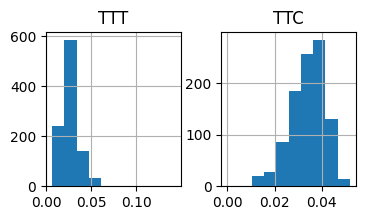

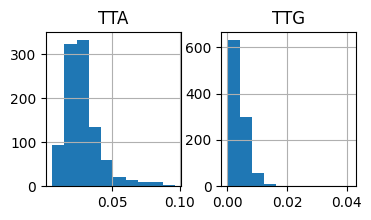

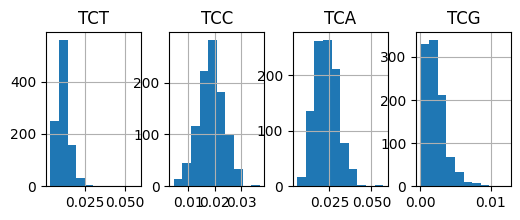

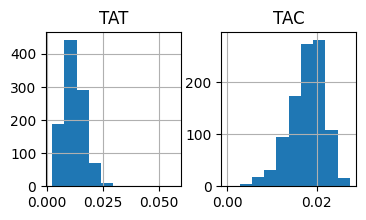

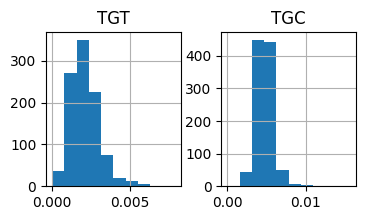

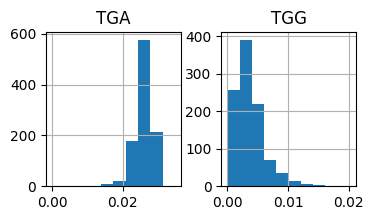

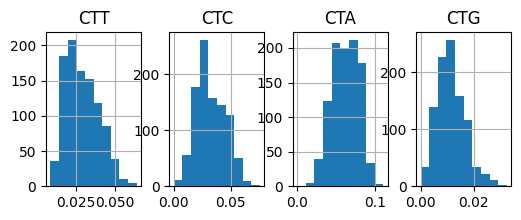

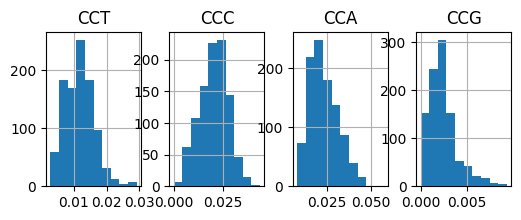

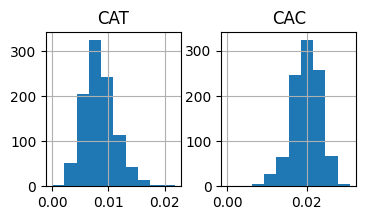

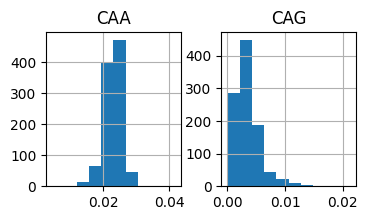

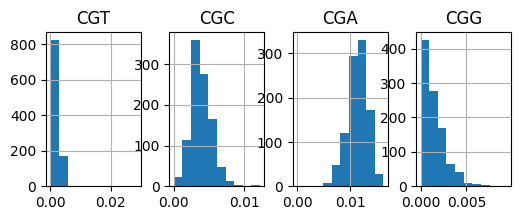

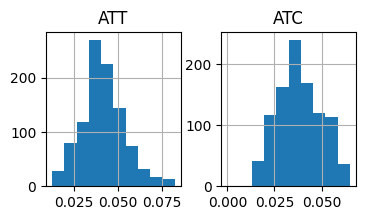

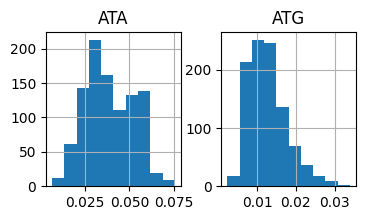

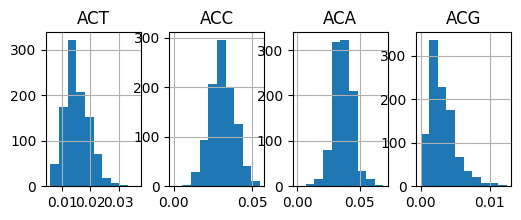

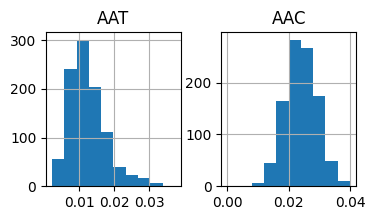

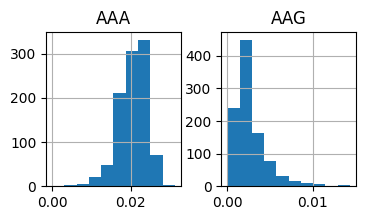

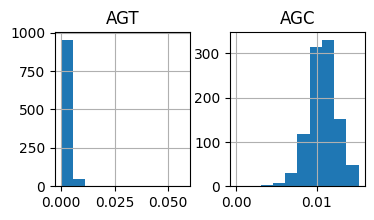

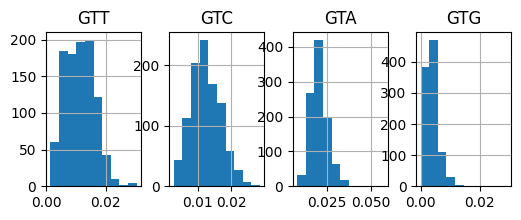

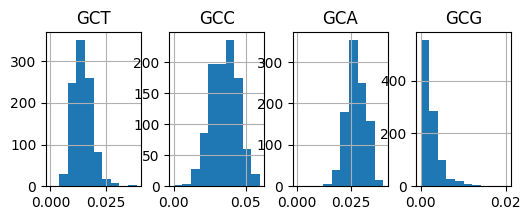

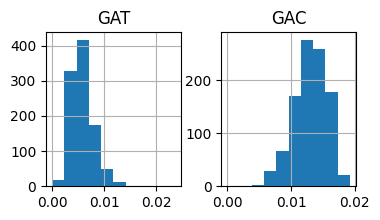

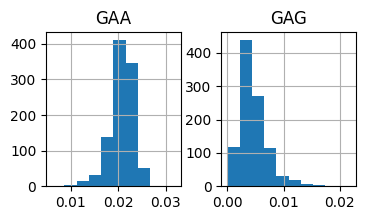

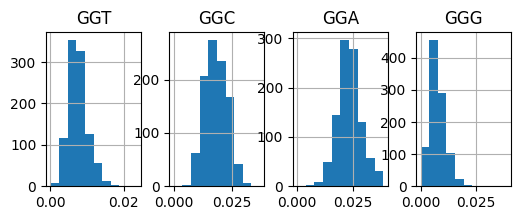

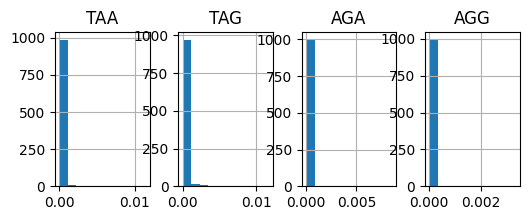

In [ ]:
for aa in aa_dict_full:
    if len(aa_dict_full[aa]) == 2:
        ratio_trna_12.loc[:, aa_dict_full[aa]].hist(figsize=(4, 2))
    else:
        ratio_trna_12.loc[:, aa_dict_full[aa]].hist(figsize=(6, 2), layout=(1 ,4))
    plt.show()

In [221]:
for atypical_ac_species_dict

{'Chaunax_abei': ['Ala_Ac', 'CGC'],
 'Chaunax_tosaensis': ['Ala_Ac', 'CGC'],
 'Cyclemys_atripons': ['Arg_Ac', 'CCG'],
 'Odontobutis_platycephala': ['Arg_Ac', 'CCG'],
 'Ciona_intestinalis': ['Gly_Ac', 'TCT', 'Met_Ac', 'TAT'],
 'Cervus_nippon_yakushimae': ['Phe_Ac', 'AAA'],
 'Canis_lupus_laniger': ['Val_Ac', 'CAC'],
 'Chlamydosaurus_kingii': ['Val_Ac', 'AAC'],
 'Pseudalutarius_nasicornis': ['Phe_Ac', 'AAA']}